In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import itertools, os, sys

sys.path.append('..')
from data.load_data import *
from src.map import *
from src.robot import *
from src.slam import *
from src.utils import *

In [2]:
import pickle

MAP_XLIM = (-25, 25)
MAP_YLIM = (-25, 25)
MAP_RESOLUTION = 0.05

belief = 0.8
MAP_LOGODDS_OCCUPIED_DIFF = np.log(belief/(1-belief))
MAP_LOGODDS_FREE_DIFF = np.log((1-belief)/belief)*.5
MAP_LOGODDS_LIM = (-100, 100)

N_PARTICLES = 128
N_EFF_THRESHOLD = 4
PREDICT_NOISE_SIGMA = np.diag([1e-3, 1e-3, 1e-3])
MAP_LOGODDS_OCCUPIED_THRESHOLD = np.log(9)

SAVE_MAP_FIG_FNAME_TEMPLATE = '../fig/MAP_4/{}.jpg'
SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE = '../fig/MAP_TEXTURE_4/{}.jpg'

with open('../data/train4.pkl', 'rb') as f:
    datas = pickle.load(f)

In [3]:
from p2_utils import *
from multiprocessing import Pool
import cv2

logodds = Map2D(xlim=MAP_XLIM, ylim=MAP_YLIM, resolution=MAP_RESOLUTION)

state = { 'x': 0, 'y': 0, 'theta': 0 }
for di, data in enumerate(datas):
    for i, key in enumerate(['x', 'y', 'theta']):
        state[key] += data['lidar_delta_pose'][0, i]
        
    if di % 1 == 0:
        lidar_scan = data['lidar_scan']
        lidar_scan_points = np.hstack([data['lidar_scan_points'], np.ones((data['lidar_scan_points'].shape[0], 1))])
        t = Transform(**state, **data)
        lidar_scan_points_w = t.chain('wTb', 'bTh', 'hTl') @ lidar_scan_points.T
        lidar_scan_points_w = lidar_scan_points_w.T[:, :3]
        lidar_scan_points_w = lidar_scan_points_w[lidar_scan_points_w[:, 2] > 0.1, :]
        lidar_scan_points_w = lidar_scan_points_w[logodds.in_map(lidar_scan_points_w), :2]
        
        lidar_scan_indices = logodds.coordinate_to_index(lidar_scan_points_w)
        
        mask = cv2.drawContours(image=np.zeros_like(logodds.data), 
                                contours=[lidar_scan_indices.reshape((-1,1,2)).astype(np.int32)], 
                                contourIdx =-1, 
                                color = MAP_LOGODDS_FREE_DIFF, 
                                thickness=-1)
        logodds.data += mask
        logodds.data[lidar_scan_indices[:, 1], lidar_scan_indices[:, 0]] += MAP_LOGODDS_OCCUPIED_DIFF - MAP_LOGODDS_FREE_DIFF
        logodds.data = np.clip(logodds.data, *MAP_LOGODDS_LIM)
        
logodds.data.max()

100.0

1.0 0.0
(1001, 1001)


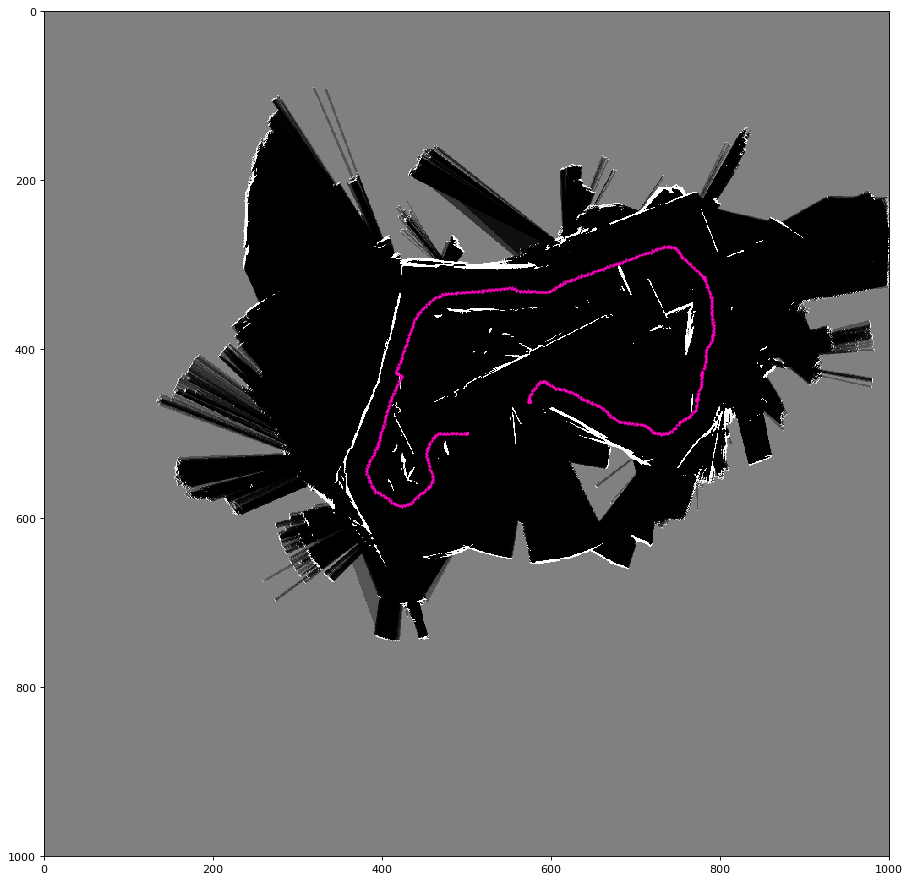

In [4]:
import pylab
from src.util import *

gamma = 1.0 - 1.0/(1.0 + np.exp(logodds.data))
print(gamma.max(), gamma.min())
print(logodds.data.shape)

state = np.array([0, 0, 0], dtype=np.float64)
posx = []
posy = []

for i, data in enumerate(datas):
    state[0] += data['lidar_delta_pose'][0, 0]
    state[1] += data['lidar_delta_pose'][0, 1]
    state[2] += data['lidar_delta_pose'][0, 2]
    
    x, y = logodds.coordinate_to_index([state[0], state[1]]).reshape(-1)
    if i % 20 == 0:
        posx.append(x)
        posy.append(y)

plot_map(gamma, [posx, posy], 20)

In [5]:
%load_ext autoreload
%autoreload 2
from src.slam import ParticleFilterSLAM

slam = ParticleFilterSLAM(
    n_particles=N_PARTICLES,
    n_efficient_threshold=N_EFF_THRESHOLD,
    map_xlim=MAP_XLIM,
    map_ylim=MAP_YLIM,
    map_resolution=MAP_RESOLUTION,
    map_logodds_lim=MAP_LOGODDS_LIM,
    map_logodds_occupied_diff=MAP_LOGODDS_OCCUPIED_DIFF,
    map_logodds_free_diff=MAP_LOGODDS_FREE_DIFF,
    map_logodds_occupied_threshold=MAP_LOGODDS_OCCUPIED_THRESHOLD,
    predict_noise_sigma=PREDICT_NOISE_SIGMA
)

states = [np.array([0, 0, 0])]
for i, data in enumerate(datas):
    with slam.set_robot_data(**data):
        u = slam.predict_particles(data['lidar_delta_pose'][0, :])
        corr, neff = slam.update_particles()

        states.append(slam.robot_state)

        if i % 1 == 0:
            print(i, slam.robot_state, neff, corr.max(), corr.min())
            slam.update_map_logodds()
        
        if i % 10 == 0:
            slam.update_map_texture()
            
        if i % 50 == 0:
            if SAVE_MAP_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(1.0 - slam.map_prob, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
                
            if SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(slam.map_texture_trimmed, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
        plt.close('all')

0 [-0.10013833 -0.11270816 -0.01848481] 127.99999999999997 0.0 0.0
1 [-0.18812374 -0.21556355 -0.06080754] 127.99999999999997 0.0 0.0
2 [-0.11727432 -0.21855725 -0.03684447] 23.396268972617907 24.0 0.0
3 [-0.13059468 -0.21648311 -0.04450908] 1.0000334076101773 476.0 5.0
4 [-0.11986326 -0.20049089 -0.03869454] 1.7012638755104885 492.0 132.0
5 [-0.11200184 -0.20238811 -0.03849866] 1.2031039510284467 684.0 187.0
6 [-0.12190033 -0.20768262 -0.03706457] 1.6562264684426116 690.0 147.0
7 [-0.12335477 -0.201683   -0.04139503] 1.0993629073650144 690.0 161.0
8 [-0.1145245  -0.20473819 -0.0363867 ] 1.0993286607469426 696.0 179.0
9 [-0.10873408 -0.20472525 -0.04215973] 3.001828375078995 693.0 171.0
10 [-0.11742945 -0.21292496 -0.04144532] 1.1141464490147475 694.0 174.0
11 [-0.11390215 -0.21552867 -0.03500169] 1.0000000119725885 689.0 162.0
12 [-0.11250885 -0.19488245 -0.039253  ] 1.7663528014831642 695.0 168.0
13 [-0.11790908 -0.20982454 -0.03736767] 1.0018571968817849 693.0 186.0
14 [-0.11840859 

115 [-0.09142069 -0.21978183 -0.04237535] 1.203200174295116 698.0 165.0
116 [-0.08808747 -0.2198391  -0.04284826] 1.90901757065198 697.0 184.0
117 [-0.10003733 -0.23153201 -0.0408605 ] 1.013749945586046 699.0 183.0
118 [-0.10076558 -0.21824187 -0.04491015] 4.258601808809775 697.0 156.0
119 [-0.10351195 -0.22468267 -0.04567308] 1.0000000000013642 698.0 114.0
120 [-0.10069435 -0.22898352 -0.04133941] 1.7364808527872435 697.0 152.0
121 [-0.09322385 -0.21087421 -0.04675393] 3.0681913458170547 697.0 193.0
122 [-0.10112026 -0.22366962 -0.03947849] 2.162672837306427 699.0 168.0
123 [-0.10223954 -0.22202328 -0.04146941] 2.4892167635496274 700.0 210.0
124 [-0.09142831 -0.22304441 -0.03990252] 1.8457700083646802 697.0 180.0
125 [-0.10504664 -0.20872653 -0.04060022] 2.4300961208514664 697.0 199.0
126 [-0.09709028 -0.23184412 -0.04092733] 3.458169329827686 698.0 171.0
127 [-0.09359431 -0.21192724 -0.04130102] 2.500600720006523 698.0 192.0
128 [-0.10184229 -0.227347   -0.03700044] 2.752201341587085

229 [-0.09174485 -0.21349149 -0.04514691] 3.572627309472352 698.0 195.0
230 [-0.09436429 -0.22490635 -0.04178494] 3.7730324449742123 697.0 217.0
231 [-0.10364042 -0.21565831 -0.03827387] 3.542671357482536 699.0 153.0
232 [-0.10450676 -0.21059157 -0.03987398] 3.726712044387112 697.0 204.0
233 [-0.10674689 -0.22480124 -0.04272282] 2.4264629362680594 699.0 200.0
234 [-0.10385312 -0.21335493 -0.03949116] 1.1436889951367888 699.0 178.0
235 [-0.09572162 -0.2123293  -0.04309847] 2.125684467760713 698.0 206.0
236 [-0.09510807 -0.22783516 -0.04345108] 1.650303122352671 698.0 253.0
237 [-0.09450698 -0.2368199  -0.0407714 ] 2.140347772936508 698.0 207.0
238 [-0.09631953 -0.22599737 -0.0414373 ] 1.492517518271407 700.0 159.0
239 [-0.08668049 -0.22749867 -0.04480988] 3.1579569229001208 697.0 211.0
240 [-0.10486059 -0.21433982 -0.04039286] 3.8333884231257063 699.0 207.0
241 [-0.09422969 -0.20724803 -0.0408782 ] 1.0741759842820433 697.0 189.0
242 [-0.10545097 -0.21953783 -0.038866  ] 1.82309295691486

343 [-0.0948543  -0.21776827 -0.04414633] 3.4307474351365133 699.0 172.0
344 [-0.0883029  -0.23493189 -0.04418642] 4.393945476343191 696.0 189.0
345 [-0.10357893 -0.21775415 -0.04183764] 1.0 698.0 152.0
346 [-0.09951402 -0.22507367 -0.03994085] 3.313101552180123 699.0 187.0
347 [-0.10518455 -0.225366   -0.04131376] 5.2732780995495165 697.0 149.0
348 [-0.09630959 -0.21838763 -0.0302666 ] 1.271328471040333 697.0 157.0
349 [-0.10670226 -0.22817    -0.04148207] 1.5802679253942782 697.0 201.0
350 [-0.09882187 -0.22774347 -0.04094837] 1.6807369621289336 699.0 226.0
351 [-0.10240676 -0.22228785 -0.04193799] 2.001599980299306 700.0 143.0
352 [-0.09501557 -0.22347066 -0.0448165 ] 5.254052875254578 700.0 202.0
353 [-0.09338956 -0.2354577  -0.03966357] 1.0000000005584297 699.0 158.0
354 [-0.10021148 -0.22587071 -0.03626032] 3.1729818992327425 699.0 218.0
355 [-0.09434954 -0.20953294 -0.04094635] 3.223527346071763 697.0 139.0
356 [-0.09950427 -0.23230547 -0.04032642] 4.261052878035797 699.0 203.0


457 [-0.11626076 -0.23903348 -0.03966584] 1.1000307434227554 699.0 143.0
458 [-0.08648477 -0.22083923 -0.04399932] 5.092475666072325 697.0 196.0
459 [-0.09172008 -0.21250219 -0.04929417] 1.0000006133212571 697.0 161.0
460 [-0.10393116 -0.22613384 -0.03936217] 1.6005872128538108 699.0 219.0
461 [-0.10781925 -0.22744041 -0.03985537] 1.516655518424596 698.0 241.0
462 [-0.09658581 -0.23045244 -0.03437996] 2.9122970654451845 698.0 228.0
463 [-0.09981736 -0.20857412 -0.04429206] 5.48322811191757 698.0 177.0
464 [-0.09537856 -0.20851429 -0.04244248] 1.6480542736638317 699.0 186.0
465 [-0.10277421 -0.22538194 -0.04007855] 3.5443291829715142 699.0 276.0
466 [-0.09658839 -0.23501058 -0.03581671] 2.3848343147499107 698.0 143.0
467 [-0.10658683 -0.22190868 -0.0408026 ] 2.6848561661483727 699.0 224.0
468 [-0.08315973 -0.23003594 -0.04280976] 3.5278445182115568 697.0 239.0
469 [-0.09667005 -0.21946516 -0.0354049 ] 3.448226342490055 698.0 220.0
470 [-0.09310876 -0.21048112 -0.03569401] 4.918859938683

571 [-0.07819164 -0.22100397 -0.0432441 ] 1.7364939166900666 639.0 167.0
572 [-0.09469966 -0.23273027 -0.03818396] 8.615903628881638 635.0 234.0
573 [-0.10292544 -0.22609867 -0.03831092] 2.0982131537020474 633.0 181.0
574 [-0.10008149 -0.23765188 -0.03840986] 8.114318428894904 630.0 313.0
575 [-0.09242858 -0.23107883 -0.03478035] 1.0384820359192892 631.0 200.0
576 [-0.10523831 -0.21104263 -0.04307645] 6.739353670830357 629.0 330.0
577 [-0.09350276 -0.23431538 -0.03587764] 1.6480948787230447 628.0 223.0
578 [-0.10390567 -0.23759838 -0.04233441] 9.378417629156019 625.0 260.0
579 [-0.08495323 -0.22981595 -0.04038598] 1.0373944671625877 625.0 211.0
580 [-0.09707962 -0.21968156 -0.0413971 ] 3.9784498621943047 623.0 244.0
581 [-0.08465392 -0.23193273 -0.04364785] 6.8810097387155285 623.0 279.0
582 [-0.08507725 -0.22319137 -0.03429405] 2.684229031023256 621.0 210.0
583 [-0.0882036  -0.23655837 -0.03229088] 5.765387732872683 621.0 313.0
584 [-0.08155584 -0.22181314 -0.03617685] 2.3777590128612

685 [-0.10052138 -0.23378899 -0.04235851] 1.0137255118223536 650.0 186.0
686 [-0.09480587 -0.2513461  -0.03553828] 7.765462806076283 648.0 270.0
687 [-0.09241428 -0.23302546 -0.03284851] 1.1189191964853995 652.0 214.0
688 [-0.08441884 -0.2538679  -0.03725802] 10.348402338371592 652.0 342.0
689 [-0.0837966  -0.24715675 -0.03195343] 1.248609138298021 651.0 262.0
690 [-0.09650355 -0.2147164  -0.0435244 ] 4.479370283599277 653.0 340.0
691 [-0.10106323 -0.21108579 -0.04573996] 1.0049719127490164 655.0 218.0
692 [-0.0879419  -0.25730743 -0.0348299 ] 7.155813452489707 655.0 317.0
693 [-0.09754133 -0.25698413 -0.03125263] 1.6937328626371622 656.0 203.0
694 [-0.08905208 -0.22754876 -0.04714011] 10.923035655252697 659.0 319.0
695 [-0.09312687 -0.21242794 -0.04332749] 1.5740418836903585 664.0 260.0
696 [-0.09868041 -0.2288006  -0.04207373] 5.666778835992048 667.0 188.0
697 [-0.10066609 -0.22447229 -0.03677378] 2.273513118440154 671.0 168.0
698 [-0.09398185 -0.22819808 -0.04047331] 8.3888097130786

799 [-0.09517125 -0.255312   -0.04057068] 2.036457455556143 698.0 201.0
800 [-0.09390482 -0.22549469 -0.03702552] 8.014570790186236 698.0 327.0
801 [-0.09143924 -0.24390872 -0.04828773] 1.0134755129483874 699.0 199.0
802 [-0.0963806  -0.24314041 -0.03443545] 4.876468043539917 698.0 256.0
803 [-0.08483508 -0.22191829 -0.02921814] 1.2658767131679058 699.0 287.0
804 [-0.10616149 -0.24442843 -0.03794099] 6.819564824574567 697.0 353.0
805 [-0.10006644 -0.21962189 -0.04095121] 1.1142421726729335 698.0 233.0
806 [-0.09735739 -0.23981285 -0.03932417] 4.470774598322108 698.0 331.0
807 [-0.08595183 -0.22037959 -0.04366937] 1.0368765757629226 699.0 212.0
808 [-0.09134544 -0.25189193 -0.03017605] 8.236181125623691 698.0 320.0
809 [-0.09455563 -0.20690706 -0.04588913] 1.2658023211633238 698.0 229.0
810 [-0.09005401 -0.22830587 -0.03431511] 6.236919954737455 698.0 311.0
811 [-0.09055057 -0.2338337  -0.0318779 ] 1.281641529147625 699.0 218.0
812 [-0.09518782 -0.23526949 -0.04029841] 8.45108268692272 

913 [-0.09314724 -0.21331402 -0.03837278] 9.596265947335088 697.0 321.0
914 [-0.09241612 -0.23003596 -0.03660546] 1.9083197019747948 697.0 226.0
915 [-0.08718044 -0.24180071 -0.03818813] 7.07914867102081 699.0 381.0
916 [-0.10787082 -0.23786504 -0.04187316] 1.6483671966140452 697.0 251.0
917 [-0.10204124 -0.23493005 -0.03968914] 9.575565311183352 700.0 329.0
918 [-0.08273463 -0.20996704 -0.0480225 ] 1.000000041681006 697.0 252.0
919 [-0.09628357 -0.22682666 -0.03953793] 7.137989384522933 697.0 282.0
920 [-0.09218412 -0.2386367  -0.03744458] 1.2811928928663543 699.0 162.0
921 [-0.0930764  -0.22147919 -0.03725382] 9.037079702682782 699.0 282.0
922 [-0.08780008 -0.21776917 -0.04720012] 3.294701061348833 699.0 267.0
923 [-0.08754525 -0.2494469  -0.03923133] 9.71234144989219 700.0 295.0
924 [-0.08722435 -0.20868745 -0.03859961] 1.2723583273067287 699.0 240.0
925 [-0.09489851 -0.22408509 -0.04549333] 10.814109267241143 699.0 375.0
926 [-0.10229744 -0.2456852  -0.04093803] 1.4182946442734736 

1027 [-0.09903851 -0.22162343 -0.03881373] 7.131390246279205 700.0 358.0
1028 [-0.10678514 -0.2380233  -0.04250111] 1.001915484822444 699.0 268.0
1029 [-0.10363836 -0.23313983 -0.03984219] 6.717399705823567 699.0 372.0
1030 [-0.08418831 -0.23554029 -0.04504032] 2.909517031226541 702.0 243.0
1031 [-0.09447104 -0.24076375 -0.03353386] 5.567845439032702 699.0 313.0
1032 [-0.09678091 -0.22585127 -0.03572437] 2.0885793838175357 699.0 237.0
1033 [-0.08783868 -0.25122489 -0.0363112 ] 7.082253834903306 698.0 358.0
1034 [-0.10224345 -0.25758833 -0.03282584] 1.152024023502239 699.0 249.0
1035 [-0.09614738 -0.23383669 -0.03194283] 7.386099434743307 699.0 352.0
1036 [-0.09657298 -0.2179143  -0.03419274] 1.0470105877399085 699.0 222.0
1037 [-0.0968748  -0.23461651 -0.03326092] 13.25828331284813 699.0 289.0
1038 [-0.09966585 -0.25928646 -0.03624534] 2.0553687256700046 698.0 193.0
1039 [-0.08517717 -0.24564352 -0.02894697] 7.693415640930399 698.0 307.0
1040 [-0.09110748 -0.22315568 -0.04481428] 1.306

1139 [-0.08991923 -0.25673985 -0.03755428] 1.0001578353479885 697.0 262.0
1140 [-0.09712928 -0.23241173 -0.04117978] 7.9105235960624025 698.0 339.0
1141 [-0.08662446 -0.22759054 -0.03223226] 2.259862351123787 698.0 249.0
1142 [-0.08886084 -0.25147818 -0.03038204] 4.415340743750582 697.0 316.0
1143 [-0.08323663 -0.25300763 -0.02943949] 1.0134752824561606 700.0 251.0
1144 [-0.09938767 -0.24399954 -0.03782581] 6.424680844097122 698.0 278.0
1145 [-0.10898577 -0.22342252 -0.03805033] 1.6541391198978928 698.0 206.0
1146 [-0.08450759 -0.22841519 -0.03908524] 9.592551820740034 699.0 345.0
1147 [-0.09750163 -0.2332584  -0.03986588] 2.000012371205064 697.0 220.0
1148 [-0.10021487 -0.22316738 -0.04151128] 12.402417614920255 699.0 346.0
1149 [-0.09263701 -0.20639435 -0.04462581] 1.753943728814871 697.0 265.0
1150 [-0.08798525 -0.25589301 -0.03504345] 8.112996881764202 699.0 325.0
1151 [-0.09261908 -0.24172707 -0.0305289 ] 1.2728834278896906 699.0 254.0
1152 [-0.09111344 -0.24357515 -0.03414883] 10

1249 [-0.09256758 -0.25560713 -0.03353435] 2.0002513442084444 699.0 259.0
1250 [-0.10139077 -0.23217257 -0.03842598] 9.558874672949658 699.0 312.0
Updating map texture......
1251 [-0.08764708 -0.24933999 -0.0325699 ] 1.0005845002095632 698.0 276.0
1252 [-0.09795678 -0.25510414 -0.03752712] 13.813274146588457 700.0 358.0
1253 [-0.07760404 -0.24450679 -0.03083024] 2.4211842252940587 698.0 181.0
1254 [-0.0894417  -0.2449309  -0.03459854] 7.489938376535197 699.0 265.0
1255 [-0.09633433 -0.21003798 -0.04133902] 1.2716036935387347 699.0 248.0
1256 [-0.09871597 -0.21874634 -0.04176199] 6.054257721479548 700.0 356.0
1257 [-0.09524475 -0.24769792 -0.04465286] 1.0137594563976833 699.0 234.0
1258 [-0.10223436 -0.25472599 -0.03759268] 7.503456343894044 698.0 299.0
1259 [-0.09665477 -0.23567235 -0.03213447] 1.313062301352338 701.0 261.0
1260 [-0.09823104 -0.24374363 -0.03728693] 13.700193437232247 698.0 318.0
Updating map texture......
1261 [-0.08888774 -0.23723573 -0.04672071] 1.6569122142168646 7

/home/jevan0307/ECE276A-PR2-SLAM/src/slam.py:168: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(self.weights) + corr


1299 [-0.07576342 -0.25070407 -0.03266374] 1.2658022459277465 702.0 216.0
1300 [-0.09705889 -0.23923041 -0.03983572] 9.023500088933016 701.0 363.0
Updating map texture......
1301 [-0.08588173 -0.25569958 -0.0376719 ] 1.803492012536831 704.0 231.0
1302 [-0.07729381 -0.26185943 -0.03450268] 10.284445923668873 705.0 338.0
1303 [-0.08030132 -0.25054816 -0.0397609 ] 1.0217081046753596 707.0 198.0
1304 [-0.09739614 -0.27221773 -0.03690054] 6.210603925084782 702.0 326.0
1305 [-0.07225987 -0.2693441  -0.03041435] 1.1627493458550342 706.0 216.0
1306 [-0.09035355 -0.23873667 -0.03508945] 7.656523852636539 705.0 357.0
1307 [-0.06393514 -0.24549247 -0.04089694] 2.143210388935175 702.0 246.0
1308 [-0.07756852 -0.25908185 -0.04502063] 12.492557482377611 707.0 321.0
1309 [-0.08416688 -0.27105168 -0.04791473] 2.3531203841377026 709.0 228.0
1310 [-0.07398482 -0.26116012 -0.04696517] 10.568140055421688 711.0 367.0
Updating map texture......
1311 [-0.07386702 -0.28849248 -0.03208591] 1.2036087690092783 7

/home/jevan0307/ECE276A-PR2-SLAM/src/slam.py:168: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(self.weights) + corr


1325 [-0.07414759 -0.31234392 -0.04862587] 1.766352521077062 713.0 232.0
1326 [-0.07037713 -0.28759496 -0.05477412] 8.591199580484425 714.0 350.0
1327 [-0.07389507 -0.26748204 -0.04879705] 2.2962343683894617 713.0 229.0
1328 [-0.08532719 -0.29198651 -0.04842971] 9.057324152442067 711.0 354.0
1329 [-0.08485011 -0.25364148 -0.04664415] 3.2253925941055703 712.0 226.0
1330 [-0.07341685 -0.2715122  -0.05020005] 11.476637798854444 709.0 347.0
Updating map texture......
1331 [-0.06090155 -0.26842851 -0.04936803] 1.9590227290455873 709.0 225.0
1332 [-0.08832614 -0.23491254 -0.04900916] 11.183739960622871 705.0 332.0
1333 [-0.08277128 -0.25455612 -0.03598625] 1.9242742887429625 701.0 276.0
1334 [-0.09548346 -0.2379127  -0.04400676] 13.375642175317868 700.0 248.0
1335 [-0.10129354 -0.23366911 -0.04826331] 1.3915816563647467 703.0 232.0
1336 [-0.08566219 -0.21182641 -0.05247882] 9.194219746939453 700.0 326.0
1337 [-0.06961747 -0.22252651 -0.04346511] 1.9765430815854508 699.0 222.0
1338 [-0.081632

/home/jevan0307/ECE276A-PR2-SLAM/src/slam.py:168: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(self.weights) + corr


1373 [-0.07042613 -0.24090928 -0.06227059] 1.000762462125302 699.0 199.0
1374 [-0.07915768 -0.23496734 -0.050008  ] 18.64509988960328 701.0 311.0
1375 [-0.06594082 -0.21235882 -0.06525899] 5.309977751195528 701.0 218.0
1376 [-0.05629553 -0.24309227 -0.05591061] 1.0056300674350842 699.0 168.0
1377 [-0.06609041 -0.21478278 -0.06549319] 17.578333617394144 702.0 339.0
1378 [-0.05609811 -0.22439632 -0.067038  ] 3.6490968243891566 704.0 262.0
1379 [-0.08080255 -0.24910767 -0.04923229] 13.122908908479545 702.0 304.0
1380 [-0.08053059 -0.21458151 -0.05431956] 3.7360734628235206 703.0 223.0
Updating map texture......
1381 [-0.07473917 -0.25930584 -0.05000667] 16.283974679816428 705.0 283.0
1382 [-0.06128268 -0.27102172 -0.04919906] 3.0064875880298167 708.0 197.0
1383 [-0.07838153 -0.26180938 -0.05457067] 6.9284653735576605 711.0 363.0
1384 [-0.08274583 -0.25074638 -0.05815883] 1.3171530642673606 712.0 200.0
1385 [-0.06707431 -0.27286258 -0.05681943] 12.727161851873195 714.0 347.0
1386 [-0.08115

/home/jevan0307/ECE276A-PR2-SLAM/src/slam.py:168: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(self.weights) + corr


1413 [-0.07245849 -0.23298035 -0.06266489] 1.6503614329022376 706.0 196.0
1414 [-0.09001306 -0.22638777 -0.06834123] 10.221300944683133 706.0 278.0
1415 [-0.07149178 -0.23529221 -0.07264658] 1.0576834008008158 704.0 307.0
1416 [-0.07859589 -0.22468969 -0.06224231] 12.08519452115324 702.0 273.0
1417 [-0.07731942 -0.20944371 -0.06948018] 1.77838948998078 699.0 212.0
1418 [-0.06754275 -0.19819    -0.07272609] 7.337388607407224 700.0 311.0
1419 [-0.05468452 -0.18901964 -0.07331739] 1.0403441462051704 696.0 166.0
1420 [-0.05296652 -0.19993973 -0.06731758] 16.155681896087998 694.0 282.0
Updating map texture......
1421 [-0.0813088  -0.20254177 -0.06242131] 2.1845595647304634 694.0 223.0
1422 [-0.08305006 -0.18826821 -0.0625025 ] 8.059274480665785 694.0 300.0
1423 [-0.07045835 -0.19341598 -0.05720759] 3.35854058033622 693.0 261.0
1424 [-0.07333506 -0.18872173 -0.04731655] 15.128993362188227 692.0 281.0
1425 [-0.07164174 -0.20732747 -0.04597251] 1.7025720784926477 690.0 204.0
1426 [-0.07322051 

1521 [ 0.11930652 -0.2916372  -0.06280677] 4.54715944780743 714.0 237.0
1522 [ 0.106606   -0.29085187 -0.06183767] 1.0013912092462052 717.0 245.0
1523 [ 0.1169817  -0.29379138 -0.0646381 ] 3.9533693405868973 717.0 239.0
1524 [ 0.11173827 -0.26168038 -0.071505  ] 4.014410740073072 715.0 307.0
1525 [ 0.10347417 -0.26723164 -0.06918314] 1.8137626548805976 714.0 188.0
1526 [ 0.13019941 -0.26055396 -0.07301797] 2.472032928985972 717.0 315.0
1527 [ 0.12186012 -0.28758179 -0.06973529] 3.1720001561012894 712.0 294.0
1528 [ 0.13564534 -0.26758592 -0.06760867] 2.8771944262252616 707.0 281.0
1529 [ 0.13555732 -0.25687078 -0.0671461 ] 3.6740920863578492 710.0 290.0
1530 [ 0.14052763 -0.24421449 -0.0652838 ] 1.7799312768810678 708.0 287.0
Updating map texture......
1531 [ 0.14596032 -0.27949241 -0.05964842] 5.130287899375023 707.0 270.0
1532 [ 0.14246191 -0.26542116 -0.06241366] 1.0002513825234798 708.0 245.0
1533 [ 0.13696272 -0.25367321 -0.0630749 ] 7.197290323547296 709.0 288.0
1534 [ 0.10252118

1631 [ 0.4104027  -0.20894292  0.00695487] 3.217067784816555 728.0 199.0
1632 [ 0.41604066 -0.21831761  0.00339646] 1.7269128796491733 727.0 279.0
1633 [ 0.40070862 -0.20608395  0.00340067] 2.0561014671266276 728.0 295.0
1634 [ 4.20933539e-01 -2.15086565e-01  2.82291479e-04] 2.692810509175852 726.0 322.0
1635 [ 0.42722646 -0.18620796 -0.00476699] 1.010528886049343 731.0 302.0
1636 [ 0.43676766 -0.21551135 -0.01537891] 1.668702096089247 737.0 278.0
1637 [ 0.446623   -0.22594481 -0.02221502] 2.804239651285685 740.0 301.0
1638 [ 0.46012626 -0.22983573 -0.02553532] 1.6145764879520286 741.0 265.0
1639 [ 0.46426561 -0.2445099  -0.03108988] 1.4216910839314296 745.0 326.0
1640 [ 0.47525362 -0.26011982 -0.02931932] 1.9886696464620666 743.0 269.0
Updating map texture......
1641 [ 0.46976819 -0.24920387 -0.03071452] 4.27180359516275 743.0 293.0
1642 [ 0.46399278 -0.24387457 -0.02578252] 1.013475508825858 744.0 247.0
1643 [ 0.46668638 -0.26082531 -0.0211901 ] 1.4080741778342536 746.0 262.0
1644 [ 

1739 [ 0.76120219 -0.20585049  0.02112128] 1.0010420936318318 835.0 269.0
1740 [ 0.77148371 -0.20295179  0.01554523] 1.265802501458235 845.0 293.0
Updating map texture......
1741 [ 0.76848643 -0.18852295  0.0044714 ] 1.1449927410040233 836.0 273.0
1742 [ 0.77282574 -0.20172065 -0.00296372] 1.0136144282858854 851.0 241.0
1743 [ 0.79013548 -0.20109902 -0.01190081] 1.09974288213299 858.0 251.0
1744 [ 0.79014395 -0.20041394 -0.01677345] 1.0000356871906393 861.0 276.0
1745 [ 0.78403218 -0.19648809 -0.01622704] 1.982710661825027 865.0 289.0
1746 [ 0.79649405 -0.19788058 -0.01791586] 1.0000000827992626 857.0 324.0
1747 [ 0.80842172 -0.20210722 -0.0108329 ] 1.005222385533296 852.0 244.0
1748 [ 0.81755904 -0.18517115 -0.00644525] 1.0000064118248335 855.0 258.0
1749 [ 0.80609708 -0.19958844  0.00612304] 2.001943299045828 851.0 268.0
1750 [ 0.8194559  -0.18809209  0.00859262] 2.1400687632356745 836.0 297.0
Updating map texture......
1751 [ 0.8241369  -0.18830169  0.01511035] 1.042442685075458 834

1847 [ 1.06339884 -0.21750805 -0.01242992] 1.1045187424516052 812.0 213.0
1848 [ 1.07401233 -0.21238387 -0.00814483] 1.1045188411239188 798.0 242.0
1849 [ 1.0636519  -0.20951388 -0.00781819] 1.00000008280381 796.0 245.0
1850 [ 1.08112263 -0.19978754 -0.00437831] 1.1012737666501013 776.0 240.0
Updating map texture......
1851 [ 1.09752139e+00 -1.99249557e-01  9.02548180e-04] 1.0000001138169 796.0 238.0
1852 [ 1.08063686 -0.20359982  0.00727849] 1.306836187391309 806.0 233.0
1853 [ 1.07669688 -0.21209511  0.01275661] 1.0000925239253033 811.0 261.0
1854 [ 1.05793284 -0.19999722  0.01435412] 1.0000045218417868 849.0 233.0
1855 [ 1.06375408 -0.18998913  0.01585387] 1.271429246124291 833.0 259.0
1856 [ 1.05142309 -0.21353005  0.02696155] 1.4183092241810602 828.0 268.0
1857 [ 1.06702292 -0.20044253  0.01944973] 1.106546120181177 842.0 238.0
1858 [ 1.08320157 -0.20452193  0.02085117] 1.6481644074983774 831.0 194.0
1859 [ 1.08854306 -0.21277634  0.02368459] 1.0002873315339296 838.0 227.0
1860 [ 

1955 [ 1.3363537  -0.15132717  0.12171435] 1.664564676709566 895.0 214.0
1956 [ 1.32369726 -0.14329965  0.11300098] 1.0000008368749769 888.0 200.0
1957 [ 1.33589325 -0.13891586  0.10040845] 1.000000084121213 893.0 200.0
1958 [ 1.33828952 -0.14660764  0.08980491] 1.1012418077668988 880.0 177.0
1959 [ 1.3401436  -0.14079807  0.08368105] 1.0000000000770797 910.0 165.0
1960 [ 1.33794207 -0.14114639  0.08489512] 1.000671150738614 882.0 207.0
Updating map texture......
1961 [ 1.35618734 -0.1415957   0.08119635] 1.0000908883565212 893.0 226.0
1962 [ 1.35726881 -0.14568105  0.08477321] 1.0049574755012527 908.0 186.0
1963 [ 1.36489246 -0.16711389  0.0913538 ] 1.0993279499640762 914.0 180.0
1964 [ 1.37099004 -0.16359678  0.09694358] 1.113532310199401 918.0 191.0
1965 [ 1.36761167 -0.16566425  0.10310289] 1.0006709252557882 911.0 168.0
1966 [ 1.39147733 -0.17544594  0.11251339] 2.006871083276543 915.0 127.0
1967 [ 1.39264818 -0.16611565  0.1263536 ] 1.0995872698031264 916.0 193.0
1968 [ 1.3844431

2063 [ 1.55313261 -0.03834302  0.55049085] 1.648069350329729 884.0 164.0
2064 [ 1.56630925 -0.03384585  0.54609914] 1.5640520521557808 882.0 132.0
2065 [ 1.55116223 -0.02304143  0.54272121] 1.6488687796290769 868.0 162.0
2066 [ 1.55580018 -0.02682897  0.54469455] 1.0000000041325166 891.0 223.0
2067 [ 1.56701336 -0.0335405   0.55355205] 1.0000914421532157 874.0 219.0
2068 [ 1.56571093 -0.02275061  0.55539669] 1.006786581875784 839.0 214.0
2069 [ 1.55771169 -0.03580496  0.56991266] 1.0000006422650347 870.0 224.0
2070 [ 1.55633661 -0.02296811  0.58155873] 1.0000907999076323 864.0 186.0
Updating map texture......
2071 [ 1.56483435 -0.02865096  0.5947072 ] 1.000095407648603 862.0 192.0
2072 [ 1.56458461 -0.04211935  0.60302017] 1.013475282297389 859.0 171.0
2073 [ 1.57633026 -0.03241854  0.61660646] 1.0101758301425983 859.0 229.0
2074 [ 1.58028643 -0.03363442  0.61637558] 1.783119404423947 879.0 189.0
2075 [ 1.58911304 -0.03466852  0.61356916] 1.0000004501412911 864.0 147.0
2076 [ 1.5846835

2173 [1.74770993 0.01065637 0.8447124 ] 1.6022574015544802 887.0 169.0
2174 [1.75927277 0.02770184 0.84260149] 1.0000123714986617 880.0 208.0
2175 [1.75257411e+00 5.05846576e-04 8.19938710e-01] 2.0000025004902455 887.0 154.0
2176 [1.75166265 0.04110605 0.80499025] 1.0009317877944193 894.0 178.0
2177 [1.74730722 0.05182138 0.797332  ] 1.0141846059089878 909.0 188.0
2178 [1.73710393 0.02775037 0.78788374] 1.0000000828024458 905.0 214.0
2179 [1.73478506 0.05054489 0.78483842] 1.0011776723340513 948.0 214.0
2180 [1.71714194 0.071663   0.78897231] 2.135385661551661 941.0 228.0
Updating map texture......
2181 [1.72280835 0.06985443 0.80274149] 1.0000000001036824 950.0 167.0
2182 [1.71302291 0.08118998 0.8065675 ] 1.6483516527091786 957.0 223.0
2183 [1.70653157 0.07847317 0.81668228] 1.0993280144485522 956.0 216.0
2184 [1.6874106  0.08062774 0.82062739] 2.0414562977742396 935.0 194.0
2185 [1.67608579 0.09406    0.83867683] 1.0366189934780647 929.0 257.0
2186 [1.66459693 0.0915683  0.84672723]

2285 [1.77374102 0.26746569 1.11070162] 2.000761726197479 939.0 252.0
2286 [1.78107075 0.26228862 1.11624156] 1.0002513712868049 940.0 266.0
2287 [1.78482308 0.26446003 1.12068346] 1.2779086848934789 941.0 156.0
2288 [1.77656216 0.25312596 1.11419706] 1.6494977222344145 936.0 229.0
2289 [1.79051179 0.27541948 1.1115742 ] 1.6480566030697308 949.0 218.0
2290 [1.79608889 0.24614863 1.10026374] 1.6480718204406464 949.0 246.0
Updating map texture......
2291 [1.78895453 0.23830539 1.09237148] 1.013568674065944 946.0 195.0
2292 [1.78855345 0.24714501 1.08737792] 1.099328163697622 952.0 270.0
2293 [1.79569773 0.23660812 1.09023514] 1.03661902448179 941.0 220.0
2294 [1.80872299 0.25078607 1.08420177] 1.2819592169005039 930.0 197.0
2295 [1.79718085 0.25930689 1.07971738] 1.2050942175927337 951.0 183.0
2296 [1.79340638 0.27051017 1.0778908 ] 1.0385005494186617 950.0 312.0
2297 [1.79617907 0.25850628 1.07620692] 1.0005851868104427 950.0 249.0
2298 [1.79276846 0.26983477 1.06918403] 2.0018314240489

2397 [1.9506134  0.49792684 1.03703041] 1.0000045207344719 1037.0 312.0
2398 [1.94446988 0.53292216 1.04373363] 1.000000084315163 1020.0 290.0
2399 [1.94090849 0.50907872 1.0458016 ] 1.001857810708144 1035.0 258.0
2400 [1.9537691  0.50820738 1.05215233] 1.0000003400537458 1039.0 278.0
Updating map texture......
2401 [1.94656604 0.52308904 1.0535162 ] 1.0000023206531272 1040.0 301.0
2402 [1.95200948 0.54266713 1.05536726] 1.654023760419863 1044.0 347.0
2403 [1.94583458 0.54463887 1.05623349] 1.0006768293996995 1036.0 279.0
2404 [1.94864852 0.55679218 1.04984224] 1.2658041765591441 1041.0 281.0
2405 [1.95751025 0.56076199 1.05555466] 1.017397775594894 1027.0 282.0
2406 [1.94208684 0.57321061 1.04521618] 1.0154364766979012 1031.0 290.0
2407 [1.94644492 0.56287962 1.04545461] 1.0185041330057392 1037.0 301.0
2408 [1.94709032 0.57899635 1.04866832] 1.648054279832541 1036.0 282.0
2409 [1.95191882 0.5680654  1.05441466] 1.6980464213747413 1028.0 279.0
2410 [1.9426508  0.57775255 1.06000458] 1.

2509 [2.06764341 0.80068296 1.29769824] 2.0049667210647857 1015.0 281.0
2510 [2.0647911  0.79895404 1.29624817] 1.001823775148418 1008.0 282.0
Updating map texture......
2511 [2.06889014 0.82761487 1.29733549] 1.375905870556156 1017.0 360.0
2512 [2.06495277 0.8228897  1.29775162] 1.0134752822317141 1014.0 275.0
2513 [2.05044046 0.81516538 1.29968694] 1.0000006120113567 1005.0 281.0
2514 [2.04882702 0.84223449 1.30149899] 1.0993676436016522 1014.0 359.0
2515 [2.04103318 0.81581936 1.30928224] 1.0153112499906625 1009.0 292.0
2516 [2.03974415 0.81955554 1.31918758] 2.043651964160554 1006.0 312.0
2517 [2.03266774 0.83636759 1.32284358] 1.1019543923153263 1002.0 321.0
2518 [2.03526934 0.80404102 1.33006633] 1.0416716589728598 1003.0 327.0
2519 [2.04440452 0.83459498 1.34463437] 1.0052429262921856 1011.0 300.0
2520 [2.04449317 0.83360718 1.350372  ] 1.0002513429236792 1004.0 345.0
Updating map texture......
2521 [2.03964745 0.81515521 1.34637297] 2.041707096740728 1008.0 278.0
2522 [2.039719

2621 [2.0502239  1.03048111 1.56702517] 1.7695476211325833 1003.0 371.0
2622 [2.05035103 1.06854551 1.55275415] 1.6649768828585707 1001.0 363.0
2623 [2.06085262 1.05204171 1.54244242] 1.7092353067719264 1013.0 318.0
2624 [2.06044204 1.06602884 1.53124077] 1.0021046954251474 1016.0 287.0
2625 [2.06412258 1.06298472 1.51893202] 1.0000000000006821 1025.0 352.0
2626 [2.06873195 1.06486768 1.51822971] 1.001823853909205 1003.0 361.0
2627 [2.07216075 1.08210889 1.51189514] 1.2959660143005476 982.0 307.0
2628 [2.08166565 1.11042661 1.52087628] 1.0141843387560812 995.0 352.0
2629 [2.0845704  1.10239966 1.53022867] 1.403121009089022 1007.0 351.0
2630 [2.08337369 1.12216993 1.53420108] 1.0043215613524044 1008.0 275.0
Updating map texture......
2631 [2.07962478 1.13473404 1.54058218] 1.0522054578580888 988.0 319.0
2632 [2.08861347 1.12810304 1.54667077] 2.3100263807686314 993.0 371.0
2633 [2.08472468 1.13098288 1.54925302] 1.648096522447801 993.0 351.0
2634 [2.08190588 1.12367805 1.55095414] 1.004

2733 [2.0040291  1.35448511 1.64915122] 1.0000334034015772 1022.0 345.0
2734 [2.01040117 1.36379242 1.65951462] 1.0000002555377903 1019.0 304.0
2735 [2.00662887 1.34965972 1.6657845 ] 1.005204914969487 990.0 330.0
2736 [2.00920296 1.36543013 1.67709106] 1.6713808740333649 1013.0 334.0
2737 [2.00936863 1.38141322 1.68241169] 1.2808516501440186 1023.0 385.0
2738 [2.01740779 1.37710404 1.68692614] 1.0000139931620446 1021.0 331.0
2739 [2.01960667 1.39117386 1.68357905] 1.0419423277500819 1018.0 386.0
2740 [2.01599026 1.3911736  1.6768325 ] 1.002495329133775 1020.0 306.0
Updating map texture......
2741 [2.02038957 1.36763523 1.67370638] 1.0000000000015916 1014.0 358.0
2742 [2.02267501 1.37881878 1.6673082 ] 1.6540236555059278 1020.0 387.0
2743 [2.01564244 1.38797901 1.6617788 ] 1.0000000058555543 1023.0 369.0
2744 [2.02514823 1.38097386 1.66379879] 1.0000000000020464 1013.0 327.0
2745 [2.022834   1.38334288 1.6594586 ] 1.0002519542191644 1021.0 387.0
2746 [2.02036356 1.37939409 1.65605887] 

2845 [1.9950148  1.65290894 1.69980681] 1.0004936696611235 1040.0 377.0
2846 [2.00020369 1.65768081 1.70393845] 1.0171506067397338 1049.0 387.0
2847 [2.00297797 1.63751325 1.71534952] 1.0000000345853555 1052.0 361.0
2848 [1.99542213 1.64679417 1.71941753] 1.6505642693691007 1055.0 354.0
2849 [1.99990306 1.65434393 1.72050568] 1.0134757353748864 1053.0 423.0
2850 [1.99669007 1.65931287 1.72281179] 1.00000069460808 1046.0 393.0
Updating map texture......
2851 [1.99222842 1.67734081 1.72401616] 1.0366190090771537 1043.0 382.0
2852 [1.98224991 1.65977447 1.7205992 ] 1.004957474174805 1048.0 353.0
2853 [1.97509268 1.68810412 1.71900654] 1.0018406712618644 1033.0 346.0
2854 [1.96785199 1.70388538 1.71458939] 1.6543363916866953 1045.0 384.0
2855 [1.95647918 1.71701234 1.70283288] 1.0000045511226465 1026.0 392.0
2856 [1.95757335 1.71712043 1.69989081] 1.000670925385933 1039.0 416.0
2857 [1.95264424 1.73661513 1.69437943] 1.0000061967382248 1039.0 411.0
2858 [1.9483175  1.6919796  1.69482534] 1

2957 [1.9661872  1.99684457 1.73343824] 2.422008274980414 1030.0 350.0
2958 [1.96113658 1.97156596 1.72470666] 2.391938817017683 1031.0 398.0
2959 [1.9678651  1.97546147 1.72120725] 1.0052383940273395 1051.0 438.0
2960 [1.96559426 1.97919365 1.7120353 ] 1.6496730476651162 1047.0 424.0
Updating map texture......
2961 [1.95794478 1.97465548 1.70750876] 1.0007620111156492 1048.0 405.0
2962 [1.96168128 2.00062396 1.70860591] 1.0000045247949294 1046.0 333.0
2963 [1.95301212 1.97665162 1.70643471] 1.0000051630281033 1054.0 318.0
2964 [1.9501798  1.97050013 1.70446512] 1.7663504492966673 1021.0 393.0
2965 [1.94445808 1.96025567 1.71358842] 1.0018238453167991 1047.0 377.0
2966 [1.94136136 1.97259521 1.71589037] 1.0018237624145936 1057.0 411.0
2967 [1.93622964 2.00434477 1.7167038 ] 2.000001306408212 1046.0 348.0
2968 [1.93844599 1.97807855 1.71689767] 1.2816834204118013 1034.0 390.0
2969 [1.93585243 1.99933229 1.71931337] 1.000000000557975 1043.0 342.0
2970 [1.94050338 1.97128356 1.71730978] 2

3069 [1.8995186  2.23083153 1.5712494 ] 1.6481644074983774 1053.0 337.0
3070 [1.89621366 2.2277333  1.56686766] 1.000004520686723 1056.0 383.0
Updating map texture......
3071 [1.89291957 2.25379352 1.56152622] 1.0000001132980334 1045.0 411.0
3072 [1.90080475 2.25610579 1.56082486] 1.265802923437413 1063.0 349.0
3073 [1.8994011  2.2505743  1.54738536] 1.0001030888695426 1058.0 397.0
3074 [1.90505837 2.23753074 1.53418613] 1.000090800417223 1048.0 322.0
3075 [1.91384646 2.25747211 1.53220562] 1.0366215383450639 1062.0 401.0
3076 [1.91517902 2.2512946  1.51807465] 1.0154027289015344 1056.0 390.0
3077 [1.91670996 2.26260657 1.51494437] 1.0184658812488512 1052.0 430.0
3078 [1.92465409 2.3070496  1.50811671] 1.3759039404388271 1011.0 319.0
3079 [1.93701185 2.28639611 1.52588136] 1.0000000000004547 1045.0 285.0
3080 [1.93606608 2.26751863 1.52561938] 1.2658394753394633 1050.0 370.0
Updating map texture......
3081 [1.94600577 2.286094   1.53590006] 1.0001031722028555 1024.0 322.0
3082 [1.94232

3181 [1.9056209  2.53776074 1.3910408 ] 1.6488625563427926 1020.0 379.0
3182 [1.91094656 2.5723559  1.40311779] 1.1298266805485566 1048.0 317.0
3183 [1.91284318 2.57297962 1.40498999] 1.265815929373536 1035.0 310.0
3184 [1.91316622 2.57869136 1.411297  ] 1.2658022290943087 1043.0 300.0
3185 [1.92088051 2.58588396 1.42697964] 1.6608150354161595 1000.0 267.0
3186 [1.91922802 2.57657333 1.42240046] 1.0270542708347676 1013.0 377.0
3187 [1.93116938 2.57095756 1.43208836] 1.0010087530136096 1019.0 251.0
3188 [1.93114614 2.56643384 1.43146247] 1.0000954035261527 1019.0 366.0
3189 [1.93765836 2.55083793 1.43623518] 1.0006710080070782 1015.0 298.0
3190 [1.93955274 2.59050156 1.4323037 ] 1.0366197011298284 1006.0 328.0
Updating map texture......
3191 [1.93873961 2.59805702 1.43298167] 1.0369627540281896 1012.0 349.0
3192 [1.9346629  2.59193181 1.43096108] 2.2644160606793697 1012.0 370.0
3193 [1.94162466 2.59146266 1.43746541] 1.0000456936234885 1004.0 363.0
3194 [1.93652668 2.58091949 1.42915755

3293 [1.9828771  2.8025394  1.23635134] 1.0 1002.0 279.0
3294 [1.98610874 2.79179172 1.23616214] 1.0366189934735863 1011.0 334.0
3295 [1.98267654 2.78039588 1.23514189] 1.0007043439078342 989.0 322.0
3296 [1.98606093 2.78966681 1.23276241] 1.000037954600301 1010.0 228.0
3297 [1.98311061 2.79555093 1.22915479] 1.001823762424844 1013.0 306.0
3298 [1.98208619 2.81458951 1.23171717] 1.000000011205657 1016.0 323.0
3299 [1.97970284 2.81802865 1.22602337] 1.0006709558557905 1010.0 338.0
3300 [1.97594728 2.79411587 1.23246487] 1.0000000015281785 1011.0 380.0
Updating map texture......
3301 [1.97208644 2.78953371 1.22740837] 1.0153135321799824 993.0 268.0
3302 [1.96877013 2.83593824 1.22848107] 1.0000334146073813 1002.0 326.0
3303 [1.9640188  2.84231371 1.2267269 ] 1.000000000233058 1005.0 346.0
3304 [1.96379794 2.84120634 1.21973482] 1.0 1007.0 380.0
3305 [1.96522073 2.83233002 1.21475393] 1.0000334034015772 1010.0 305.0
3306 [1.96056154 2.85480595 1.20421013] 1.0 1010.0 336.0
3307 [1.95778919

3405 [2.06645087 2.95818506 1.14358395] 1.959896616358141 1049.0 379.0
3406 [2.06432691 2.98277125 1.13582336] 1.013544212056043 1040.0 275.0
3407 [2.07032113 2.96239025 1.14367067] 1.0000006424698984 1057.0 327.0
3408 [2.07862188 2.95478045 1.14813122] 1.09932801637673 1043.0 341.0
3409 [2.08993769 2.94773739 1.15877307] 1.1429643799147398 1031.0 326.0
3410 [2.09166877 2.9515639  1.15532119] 2.0135199302458515 1050.0 345.0
Updating map texture......
3411 [2.09677602 2.97333284 1.16007472] 1.0995584587613874 1053.0 342.0
3412 [2.09636194 2.97000015 1.16760104] 1.0738862668417608 1042.0 374.0
3413 [2.09695115 2.94769628 1.164271  ] 2.6265930252371974 1048.0 329.0
3414 [2.1028236  2.97545387 1.17106323] 1.0000910249400212 1044.0 384.0
3415 [2.10183551 2.96578633 1.17299506] 1.0025098806750399 1017.0 336.0
3416 [2.10433226 2.97679001 1.18030271] 2.0269846444016553 1021.0 339.0
3417 [2.10066732 2.96653533 1.17554911] 1.0366547212584605 1015.0 436.0
3418 [2.10186033 2.9629618  1.17183828] 1

3517 [2.18714765 3.23575887 1.17431481] 1.000002274872924 1015.0 416.0
3518 [2.18709204 3.22591815 1.19087866] 1.0000002250981324 1019.0 312.0
3519 [2.18677928 3.22816758 1.20656343] 1.11344758441129 1004.0 292.0
3520 [2.18389612 3.21370669 1.21518643] 1.000000035140602 1015.0 411.0
Updating map texture......
3521 [2.18598382 3.24989612 1.23027325] 1.0996121390044244 1014.0 347.0
3522 [2.18308941 3.26291371 1.23436982] 1.0000000127602109 1001.0 307.0
3523 [2.18034906 3.2699155  1.24172644] 1.0995181009905488 1007.0 271.0
3524 [2.17651714 3.26907865 1.25725869] 1.0367114253179206 1033.0 407.0
3525 [2.17127745 3.27197325 1.25986359] 1.6919860904244202 1039.0 354.0
3526 [2.17109226 3.28705155 1.25484941] 1.0000006424703531 1034.0 307.0
3527 [2.17001663 3.30721401 1.24242789] 1.0000047457301664 1023.0 451.0
3528 [2.16650658 3.31858032 1.23379812] 1.2658022334413928 1028.0 298.0
3529 [2.16435502 3.31891197 1.22653485] 1.000000225275484 1032.0 360.0
3530 [2.16601236 3.31447488 1.22457871] 1.

3629 [2.29332704 3.52814263 1.29539385] 2.0134535249909704 1020.0 299.0
3630 [2.28927439 3.50953254 1.29026761] 1.000704372329312 1023.0 432.0
Updating map texture......
3631 [2.28627283 3.53351188 1.28784293] 1.0018237737060622 1010.0 375.0
3632 [2.28543886 3.51267778 1.28275273] 1.0018617328852413 1024.0 332.0
3633 [2.27725764 3.54201849 1.28255919] 1.0366530815509756 994.0 445.0
3634 [2.27697885 3.52360059 1.28122486] 1.0000124540231408 1014.0 434.0
3635 [2.27376568 3.51423131 1.28313414] 1.2658022288341286 1021.0 436.0
3636 [2.26946917 3.53869376 1.2894252 ] 1.3502999541497758 1006.0 454.0
3637 [2.26263202 3.51782033 1.29598874] 1.0000045206587562 1022.0 377.0
3638 [2.26552258 3.51973552 1.30732707] 1.0366189955958283 1016.0 415.0
3639 [2.26908256 3.53550919 1.30926566] 1.6480543153646354 1020.0 412.0
3640 [2.26644149 3.5332636  1.31987445] 1.0141552483077472 1025.0 456.0
Updating map texture......
3641 [2.26424616 3.53425666 1.31544252] 1.0000017458679973 992.0 339.0
3642 [2.26785

3741 [2.29275336 3.82767849 1.47417086] 1.266825485784451 1014.0 344.0
3742 [2.29097512 3.84550556 1.46363817] 1.0000000153395379 1003.0 380.0
3743 [2.2883663  3.81190387 1.46695352] 1.1003019300552683 1009.0 379.0
3744 [2.28655543 3.82847414 1.46025686] 1.0 1018.0 315.0
3745 [2.29422044 3.85492324 1.44860466] 1.0000002250740307 1027.0 427.0
3746 [2.29612548 3.81193548 1.43957772] 1.0994230120416109 1021.0 340.0
3747 [2.30173733 3.85513378 1.4313421 ] 1.0000047457294843 1035.0 344.0
3748 [2.30764321 3.85153497 1.41792513] 1.6480545448337218 1035.0 320.0
3749 [2.31148096 3.84801896 1.41992064] 1.6503761726516095 1042.0 278.0
3750 [2.31589837 3.87630372 1.41090431] 1.7664073789644474 1025.0 409.0
Updating map texture......
3751 [2.32344503 3.86524831 1.41055328] 1.6920454508337979 994.0 394.0
3752 [2.32839673 3.88805521 1.42709863] 1.0210758229310475 1035.0 296.0
3753 [2.33318079 3.89112463 1.44005628] 1.0000908127872468 1015.0 390.0
3754 [2.33292306 3.86699444 1.44631501] 1.000000002560

3853 [2.2981118  4.15471096 1.31754776] 1.0012000724685515 1067.0 356.0
3854 [2.29782975 4.16259613 1.32583384] 1.0407871729907623 1056.0 386.0
3855 [2.29982913 4.14813911 1.32554144] 1.266077407777067 1062.0 413.0
3856 [2.29713013 4.16136578 1.32876739] 1.00184233430139 1070.0 353.0
3857 [2.29636705 4.16912117 1.33130607] 1.1047778175866205 1065.0 371.0
3858 [2.29978422 4.14695295 1.34355979] 1.0014374605659966 1065.0 323.0
3859 [2.30133117 4.17059628 1.3392098 ] 1.2886995229949119 1060.0 353.0
3860 [2.30269218 4.15492562 1.3480895 ] 1.0006851064986995 1067.0 370.0
Updating map texture......
3861 [2.31316719 4.16430417 1.34658961] 2.0000351537437178 1061.0 360.0
3862 [2.31074824 4.16493672 1.34447291] 1.982702541399306 1062.0 289.0
3863 [2.31790163 4.17636842 1.33252717] 1.019147744002926 1067.0 359.0
3864 [2.32454009 4.18689364 1.31672455] 1.6483523764819636 1060.0 373.0
3865 [2.32279445 4.15662205 1.31340524] 1.1006475062630796 1076.0 424.0
3866 [2.32792298 4.14470566 1.30876009] 1.

3965 [2.41285525 4.36721715 1.10511577] 1.0001076112782181 1005.0 333.0
3966 [2.41434537 4.36698213 1.10581473] 1.0003395355634892 997.0 351.0
3967 [2.41869204 4.37321219 1.10543199] 2.038571137269018 991.0 280.0
3968 [2.40874165 4.37913116 1.10477933] 1.000033658937444 998.0 278.0
3969 [2.41899106 4.38916682 1.10745897] 1.2716409279334042 993.0 271.0
3970 [2.41147235 4.37596641 1.1186456 ] 1.064140249951831 991.0 275.0
Updating map texture......
3971 [2.40767297 4.40503984 1.11855659] 1.2658029465952023 995.0 316.0
3972 [2.40746857 4.39895063 1.12933432] 1.0000336589399452 1000.0 289.0
3973 [2.42213826 4.40116677 1.13659284] 1.6540642149170854 985.0 267.0
3974 [2.40458732 4.42906052 1.13732999] 1.265802484375838 997.0 309.0
3975 [2.41681166 4.42165478 1.1424578 ] 1.0000047569354218 1002.0 313.0
3976 [2.41817147 4.43684204 1.14077437] 1.0366215384303874 999.0 354.0
3977 [2.4059871  4.45740427 1.12995308] 1.1013809491524167 998.0 292.0
3978 [2.41106179 4.45274448 1.11900928] 1.418294975

4077 [2.60966128 4.61848743 0.833048  ] 1.664263831958683 898.0 230.0
4078 [2.62142801 4.63231833 0.82958186] 1.001823762418466 904.0 219.0
4079 [2.62265807 4.629025   0.82627046] 1.0000122884539522 900.0 244.0
4080 [2.62860376 4.62112233 0.82114022] 1.0367120481659036 892.0 213.0
Updating map texture......
4081 [2.6139846  4.62975325 0.81078024] 1.6502518499689691 898.0 232.0
4082 [2.61714477 4.63600753 0.80068115] 1.0018237640086565 892.0 233.0
4083 [2.61963978 4.63061427 0.79236077] 1.0049592242729708 879.0 203.0
4084 [2.61738703 4.65026389 0.78341491] 1.000000000557975 880.0 257.0
4085 [2.60873355 4.64454067 0.78118402] 1.0000002377924075 880.0 225.0
4086 [2.61988652 4.65419077 0.77794921] 1.0993281647139523 892.0 239.0
4087 [2.60963883 4.65140776 0.78343471] 1.648094518740719 914.0 190.0
4088 [2.61301836 4.65269253 0.78277366] 1.2659034670087574 911.0 176.0
4089 [2.59423482 4.65245815 0.7844448 ] 1.001825427549497 891.0 150.0
4090 [2.60893972 4.65533584 0.7910743 ] 1.0000000000754

4191 [2.76809931 4.80488152 0.55312961] 1.0134758981481886 851.0 187.0
4192 [2.74644582 4.79556888 0.55237242] 1.0000000155330329 849.0 186.0
4193 [2.76822538 4.79816673 0.54650921] 1.0861593113042032 849.0 196.0
4194 [2.77357533 4.80269581 0.54199018] 1.666815767268053 810.0 207.0
4195 [2.77119546 4.79419355 0.53571551] 1.0135683661624013 837.0 188.0
4196 [2.77177137 4.79360521 0.52657259] 1.0000045558004265 830.0 164.0
4197 [2.76625565 4.79243239 0.51947644] 1.0137283049431884 838.0 201.0
4198 [2.77891333 4.80251282 0.50786484] 1.0003667332186434 820.0 213.0
4199 [2.78586649 4.78704498 0.50027892] 1.0738845471911915 824.0 187.0
4200 [2.79127955 4.78810662 0.49562693] 1.1134698897185389 819.0 182.0
Updating map texture......
4201 [2.81728637 4.79003507 0.49499589] 1.000000225703856 819.0 192.0
4202 [2.82272382 4.78201992 0.50119937] 1.2658394707116287 802.0 195.0
4203 [2.82299799 4.79143298 0.50242445] 1.0000122884246203 790.0 179.0
4204 [2.83098496 4.78274972 0.50903269] 1.0002468196

4303 [3.05633142 4.9660728  0.35758236] 1.0153161039899867 747.0 167.0
4304 [3.04864929 4.96139845 0.36061005] 1.0003376306674152 767.0 173.0
4305 [3.05936807 4.95236312 0.36821484] 2.0372259592394917 785.0 200.0
4306 [3.04437413 4.94752768 0.37045124] 1.006785753057215 777.0 184.0
4307 [3.06306362 4.95721742 0.37572463] 1.0000000000832188 775.0 195.0
4308 [3.05949075 4.95917304 0.37733394] 1.6480542773305078 750.0 176.0
4309 [3.05943436 4.94625266 0.38662651] 1.0000908859004352 768.0 185.0
4310 [3.07916644 4.9406745  0.38646407] 1.000045951693736 765.0 156.0
Updating map texture......
4311 [3.06804927 4.93859017 0.3875986 ] 1.958703041669841 761.0 151.0
4312 [3.08595103 4.93163672 0.38250386] 1.000259109772755 741.0 179.0
4313 [3.07057223 4.93096854 0.37683291] 1.0018239876899961 748.0 166.0
4314 [3.06804686 4.93360508 0.37013436] 1.0021043389244488 739.0 150.0
4315 [3.08249589 4.93316118 0.36265509] 1.9587422177393758 745.0 173.0
4316 [3.08319648 4.93195725 0.35510103] 1.000036877297

4415 [3.32954763 5.03941412 0.31662108] 1.0000907998603343 686.0 142.0
4416 [3.33791325 5.03382834 0.32093107] 1.3065433884608373 685.0 125.0
4417 [3.31736307 5.02409013 0.32610121] 1.1386213349741243 681.0 146.0
4418 [3.30405421 5.02016446 0.33179214] 1.099586628983583 679.0 155.0
4419 [3.2958272  5.02218305 0.33875516] 1.0007663195533676 678.0 128.0
4420 [3.29301423 5.01509074 0.35211557] 2.0929315213576443 662.0 135.0
Updating map texture......
4421 [3.29036912 5.03072992 0.36549194] 1.006576870036702 671.0 134.0
4422 [3.31813449 5.02378517 0.38240303] 1.0000006120893459 684.0 128.0
4423 [3.31827486 5.02197821 0.3865933 ] 4.088830232505331 655.0 148.0
4424 [3.33984922 5.03535423 0.39517654] 1.0049583128379236 679.0 97.0
4425 [3.31701188 5.03363379 0.41192284] 1.0000000577567802 675.0 132.0
4426 [3.3368026  5.05194307 0.42308172] 2.0021286206325 678.0 133.0
4427 [3.33476009 5.05665893 0.42627499] 1.0366190064283585 688.0 135.0
4428 [3.35256613 5.06313559 0.42205034] 1.671080000991952

4527 [3.61868913 5.1367311  0.4676182 ] 1.648106268095816 677.0 116.0
4528 [3.62333062 5.14870529 0.47407608] 1.0043602712525146 693.0 109.0
4529 [3.65548445 5.13883162 0.48331266] 1.019824785638617 688.0 114.0
4530 [3.62894286 5.14411445 0.48590683] 1.3760093300921707 677.0 117.0
Updating map texture......
4531 [3.64837887 5.14456097 0.48467094] 1.0135673404795993 681.0 75.0
4532 [3.67060709 5.15593666 0.47977305] 2.0364956962655913 681.0 112.0
4533 [3.66632153 5.1630582  0.47701826] 1.041792208517991 683.0 92.0
4534 [3.64932277 5.1722232  0.47115192] 1.1012394178828109 695.0 109.0
4535 [3.64540852 5.18274591 0.46523925] 1.7664656531026437 684.0 91.0
4536 [3.6588991  5.18284633 0.46952491] 1.9228882442429345 684.0 91.0
4537 [3.66760267 5.18927802 0.47263304] 1.0049574738974048 690.0 115.0
4538 [3.65712644 5.18276738 0.482545  ] 1.0916469716810835 694.0 104.0
4539 [3.65990033 5.19366787 0.49112815] 1.1522366606504677 697.0 113.0
4540 [3.64254474 5.20465707 0.49740081] 1.042982078360210

4639 [3.7949443  5.28418609 0.57979612] 1.2659174484060869 758.0 153.0
4640 [3.80553835 5.25924373 0.58719244] 1.6643042363415934 748.0 168.0
Updating map texture......
4641 [3.80055697 5.2639908  0.59427449] 2.1027270513271725 745.0 150.0
4642 [3.80323411 5.27817397 0.60041504] 1.0373065815459277 748.0 161.0
4643 [3.80611161 5.28204981 0.61225525] 1.038488649873749 751.0 147.0
4644 [3.80085431 5.27376281 0.62852019] 1.0000459173892033 771.0 147.0
4645 [3.82165131 5.28706225 0.64036467] 1.9702684532237686 771.0 110.0
4646 [3.81286996 5.29383087 0.6493295 ] 1.0007105298042867 780.0 158.0
4647 [3.83338534 5.30268374 0.65857356] 1.005048500008282 784.0 130.0
4648 [3.80492272 5.32366194 0.65878083] 1.0056300574406265 783.0 167.0
4649 [3.80007849 5.32173328 0.65337656] 1.0 811.0 219.0
4650 [3.81280762 5.33493251 0.64490494] 1.000181645585405 794.0 206.0
Updating map texture......
4651 [3.80375383 5.3354682  0.63749554] 1.0134752822241098 821.0 199.0
4652 [3.80232405 5.34120699 0.6320954 ] 1

4753 [4.08787422 5.41112695 0.38363329] 1.0 797.0 215.0
4754 [4.072596   5.40809548 0.367869  ] 1.0049637559079774 748.0 207.0
4755 [4.08184011 5.41817807 0.35779591] 1.0000045206864956 816.0 184.0
4756 [4.07827656 5.42542226 0.35100583] 1.6919896815637447 785.0 187.0
4757 [4.07968504 5.42943904 0.34326336] 1.036618994041623 779.0 188.0
4758 [4.12342137 5.43264981 0.34182826] 1.9586989476767678 774.0 192.0
4759 [4.12016736 5.43336619 0.33548735] 1.0000122884246203 830.0 222.0
4760 [4.11821905 5.43952215 0.33608017] 1.0000000004104095 822.0 182.0
Updating map texture......
4761 [4.10013344 5.43824283 0.33938549] 1.100031144194868 828.0 192.0
4762 [4.0701422  5.44358343 0.33758852] 1.0000002250703928 830.0 194.0
4763 [4.11634288 5.45059709 0.33682004] 1.000000060920003 844.0 184.0
4764 [4.08847533 5.4400624  0.33506104] 2.0000000002057807 820.0 204.0
4765 [4.12334088 5.4446969  0.33052805] 1.004959367249415 829.0 217.0
4766 [4.08829174 5.44419563 0.32876326] 1.265802262794282 824.0 191.0

4867 [4.35653623 5.51690649 0.05344965] 1.000000694808851 757.0 196.0
4868 [4.32931495 5.51929691 0.0474312 ] 1.000672588795597 748.0 165.0
4869 [4.32334376 5.51512531 0.03939395] 1.0000000000277396 741.0 195.0
4870 [4.34478672 5.51033278 0.03658569] 1.0000334187298037 749.0 192.0
Updating map texture......
4871 [4.34706723 5.50320771 0.03870748] 1.2863724596369268 739.0 168.0
4872 [4.33821308 5.49782271 0.03912826] 1.0156527041044938 747.0 150.0
4873 [4.37069791 5.49883696 0.04289891] 1.000124288373613 747.0 182.0
4874 [4.3750666  5.48907097 0.04959363] 1.0006771125665688 745.0 181.0
4875 [4.36806594 5.4876409  0.05325011] 1.6502659276826634 740.0 198.0
4876 [4.35643356 5.49395923 0.05598711] 1.0368039461247152 741.0 197.0
4877 [4.36718446 5.48805712 0.05771412] 1.013724010669285 746.0 160.0
4878 [4.38829285 5.4796648  0.06127935] 1.0053876754262108 747.0 199.0
4879 [4.37456999 5.48273839 0.05220283] 1.0993280157178402 750.0 194.0
4880 [4.41095889 5.47902565 0.04600091] 1.001823762414

4977 [ 4.64278033  5.52826508 -0.06784706] 1.000000004122512 696.0 159.0
4978 [ 4.64925193  5.53108966 -0.06528183] 1.0000131258664995 701.0 222.0
4979 [ 4.66498011  5.52892556 -0.05785645] 1.000676094269356 696.0 165.0
4980 [ 4.63451239  5.53309936 -0.05481632] 1.0067863558436367 706.0 190.0
Updating map texture......
4981 [ 4.65359066  5.53113647 -0.0468647 ] 1.0187167088634344 693.0 208.0
4982 [ 4.65684052  5.53387348 -0.04485905] 1.0134798394481852 699.0 208.0
4983 [ 4.65878905  5.53546787 -0.04065452] 2.371415084643891 694.0 231.0
4984 [ 4.66309657  5.53591211 -0.03931854] 1.2658209820431159 695.0 166.0
4985 [ 4.65029073  5.52221045 -0.03620473] 1.1284384757115014 701.0 209.0
4986 [ 4.66743804  5.52721336 -0.04482583] 1.0506272192383557 691.0 163.0
4987 [ 4.66575981  5.51768911 -0.05081955] 1.0000047459373047 698.0 182.0
4988 [ 4.65394001  5.51824081 -0.06246827] 1.0018239881763245 697.0 169.0
4989 [ 4.65680874  5.50802727 -0.0688819 ] 1.0000045552410846 693.0 175.0
4990 [ 4.68898

5085 [ 4.91720104  5.54827077 -0.06565112] 1.6483524669778091 653.0 183.0
5086 [ 4.91994431  5.53115965 -0.06345279] 1.1027449913770073 649.0 170.0
5087 [ 4.91044016  5.53241792 -0.06231288] 1.0173978590352049 661.0 178.0
5088 [ 4.91407264  5.53070099 -0.06276624] 1.3759183042798169 654.0 177.0
5089 [ 4.88921264  5.53501258 -0.06278505] 1.2658027778098302 659.0 166.0
5090 [ 4.90061316  5.53453787 -0.06396525] 1.0184664787446804 649.0 179.0
Updating map texture......
5091 [ 4.90842484  5.53267674 -0.05236239] 1.0385680220917732 655.0 152.0
5092 [ 4.9064187   5.53195348 -0.04409228] 1.6928995392099502 658.0 170.0
5093 [ 4.89814734  5.54050977 -0.03659271] 1.0002597220254754 660.0 182.0
5094 [ 4.91338679  5.54373717 -0.02272273] 1.0000016645747227 661.0 225.0
5095 [ 4.926627    5.54701668 -0.01106784] 1.0235943040290347 655.0 172.0
5096 [ 4.90464764e+00  5.55195947e+00 -2.82743570e-04] 1.6644292492966377 663.0 187.0
5097 [4.93466902 5.56383486 0.01032564] 1.0099457504938856 666.0 182.0
50

5191 [ 5.15590001  5.67032289 -0.12152301] 1.1045319109086436 722.0 210.0
5192 [ 5.15865952  5.6551458  -0.1239421 ] 1.0000125962971682 737.0 176.0
5193 [ 5.16359323  5.64619676 -0.12628645] 1.0006744781161672 714.0 179.0
5194 [ 5.18091472  5.65221828 -0.14350676] 1.0000051324650587 729.0 187.0
5195 [ 5.1594436   5.65399644 -0.15066876] 1.0760430764949807 715.0 219.0
5196 [ 5.18630042  5.64583501 -0.14692583] 1.0000000112340788 702.0 206.0
5197 [ 5.17654049  5.63426081 -0.13818986] 1.2734668679213181 689.0 189.0
5198 [ 5.19241163  5.64174868 -0.13527017] 1.099329668958699 705.0 210.0
5199 [ 5.17579304  5.64344275 -0.13200761] 1.0007166342567437 726.0 239.0
5200 [ 5.20597305  5.63742534 -0.12800369] 1.002742508750281 720.0 184.0
Updating map texture......
5201 [ 5.20034869  5.634678   -0.12086143] 1.2678369681667705 730.0 253.0
5202 [ 5.19488231  5.63970768 -0.12290098] 1.0000018881279953 729.0 225.0
5203 [ 5.18916572  5.64591858 -0.12393182] 1.0000061838030836 727.0 234.0
5204 [ 5.2119

5299 [ 5.44678311  5.69793826 -0.15348987] 1.2658030033004444 739.0 206.0
5300 [ 5.44868025  5.69063833 -0.15634979] 1.000000000075488 739.0 209.0
Updating map texture......
5301 [ 5.45499336  5.68934308 -0.15073749] 1.000000000075488 753.0 205.0
5302 [ 5.4424141   5.6946724  -0.15323156] 1.0366192225896647 731.0 212.0
5303 [ 5.44732401  5.69005212 -0.14304029] 1.0000334146351215 745.0 201.0
5304 [ 5.44424861  5.67956233 -0.1344025 ] 1.0155850037356917 725.0 246.0
5305 [ 5.47371267  5.67908416 -0.13302914] 1.00091782775588 737.0 204.0
5306 [ 5.47253774  5.67570383 -0.1289006 ] 1.0000000062068466 718.0 232.0
5307 [ 5.48150206  5.6661007  -0.13180619] 1.0049591451994246 735.0 195.0
5308 [ 5.45639863  5.66322956 -0.13778826] 1.2674136935626867 738.0 226.0
5309 [ 5.46795315  5.64284528 -0.13613179] 1.000372704592688 735.0 256.0
5310 [ 5.45691296  5.66145587 -0.15288679] 1.0000907998594248 706.0 183.0
Updating map texture......
5311 [ 5.45829149  5.64237492 -0.14935752] 1.000035334747871 72

5407 [ 5.73817996  5.63408426 -0.23005212] 1.0000122884246203 694.0 211.0
5408 [ 5.71557613  5.63114581 -0.22715019] 1.0000000002089564 703.0 223.0
5409 [ 5.7216611   5.62540266 -0.21782624] 1.0006709556608004 688.0 177.0
5410 [ 5.70309073  5.62558247 -0.21907808] 1.00024743168974 699.0 214.0
Updating map texture......
5411 [ 5.71287135  5.62252882 -0.22001102] 1.0 705.0 190.0
5412 [ 5.70767674  5.62593779 -0.22326632] 1.0000000041222847 691.0 177.0
5413 [ 5.71314884  5.625042   -0.22398441] 1.0000000827988078 707.0 211.0
5414 [ 5.71611517  5.61417834 -0.21747302] 1.2815873064297414 681.0 163.0
5415 [ 5.72327936  5.61225397 -0.21068995] 1.0049575156621098 670.0 213.0
5416 [ 5.74985836  5.62020865 -0.20747728] 1.0134753697254166 657.0 178.0
5417 [ 5.75358906  5.61466099 -0.19499563] 1.3065420025960701 664.0 220.0
5418 [ 5.7368947   5.6186073  -0.18147658] 1.266091112054606 637.0 187.0
5419 [ 5.75354852  5.61903501 -0.17654512] 1.6480563772168235 672.0 214.0
5420 [ 5.74584077  5.61568654

5515 [ 5.98733975  5.56690396 -0.2533769 ] 1.0067858258062174 674.0 168.0
5516 [ 6.00515987  5.56969449 -0.26809306] 1.6642693715629258 646.0 148.0
5517 [ 6.01257245  5.56670078 -0.2729715 ] 2.000012904334581 635.0 160.0
5518 [ 6.00213095  5.54778714 -0.27420439] 1.0000021131985857 653.0 146.0
5519 [ 6.02153205  5.53978003 -0.27027364] 1.0 628.0 147.0
5520 [ 6.03071041  5.53949191 -0.26533924] 1.0000045212167334 625.0 144.0
Updating map texture......
5521 [ 6.00263055  5.53569013 -0.25763434] 2.002070497005437 628.0 140.0
5522 [ 6.03916202  5.53786021 -0.25309172] 1.0000000000038654 625.0 143.0
5523 [ 6.03123658  5.52901191 -0.24884151] 1.000000000075488 644.0 104.0
5524 [ 6.02777993  5.52967671 -0.25041599] 1.0002713995896906 650.0 161.0
5525 [ 6.03378812  5.52978944 -0.24954939] 1.2658022294690376 631.0 163.0
5526 [ 6.03224857  5.53467491 -0.25858883] 1.0000045321452713 643.0 150.0
5527 [ 6.04365042  5.53044438 -0.26047131] 1.000670955650562 645.0 141.0
5528 [ 6.07441719  5.53740893 

5623 [ 6.31496906  5.57205986 -0.16789319] 1.000107834826296 687.0 152.0
5624 [ 6.32441225  5.56500264 -0.15971983] 1.0135824102522581 676.0 188.0
5625 [ 6.30004319  5.55626827 -0.14529319] 2.002499275247412 692.0 200.0
5626 [ 6.29912237  5.5576972  -0.14331707] 2.0886818944822068 667.0 186.0
5627 [ 6.34259549  5.55052723 -0.13031476] 1.036653892188821 695.0 202.0
5628 [ 6.31523078  5.55618405 -0.12832389] 1.2658072689945643 692.0 188.0
5629 [ 6.33117194  5.54528537 -0.12297752] 1.0000000015165824 711.0 167.0
5630 [ 6.31843028  5.54053309 -0.12375763] 1.0049821118208597 709.0 160.0
Updating map texture......
5631 [ 6.33410339  5.53331155 -0.12827927] 2.0134562564604783 712.0 197.0
5632 [ 6.32626889  5.53127947 -0.13125122] 1.0000000002053184 697.0 164.0
5633 [ 6.30987798  5.53347344 -0.14331891] 1.0000140343056587 713.0 177.0
5634 [ 6.32000124  5.55216096 -0.15044912] 1.0134759600857068 681.0 209.0
5635 [ 6.34910754  5.54056319 -0.14909075] 1.0025862116731388 695.0 176.0
5636 [ 6.33977

5731 [ 6.58224062  5.50247346 -0.03869896] 1.0019146455838097 796.0 261.0
5732 [ 6.56528019  5.50386138 -0.03757548] 1.0522992072156514 786.0 274.0
5733 [ 6.58808334  5.50195942 -0.02980968] 1.0366870021772467 799.0 248.0
5734 [ 6.58918791  5.50108798 -0.02822071] 1.6480542736638317 796.0 227.0
5735 [ 6.58952739  5.50042281 -0.0278675 ] 1.0385266701824571 794.0 237.0
5736 [ 6.61165727  5.50312883 -0.02453936] 1.0018360635524006 776.0 237.0
5737 [ 6.57260906  5.49070332 -0.01817669] 1.0000122899791932 760.0 224.0
5738 [ 6.58489453  5.50655765 -0.01944553] 1.1001256183322374 769.0 227.0
5739 [ 6.58503290e+00  5.50052854e+00 -5.19477525e-03] 1.0384897209854735 791.0 231.0
5740 [ 6.60151537e+00  5.50366546e+00 -1.22262866e-04] 1.0 797.0 248.0
Updating map texture......
5741 [6.60821366e+00 5.51524398e+00 4.70002259e-03] 1.0134876641631794 790.0 214.0
5742 [6.63492738 5.51307118 0.01202931] 1.0000006118801619 797.0 268.0
5743 [6.6153147  5.52156919 0.01256992] 1.013475282222727 815.0 179.0


5833 [6.75164383 5.57349815 0.02607565] 1.09932792749858 855.0 192.0
5834 [6.74977512 5.57109508 0.04351859] 1.0000908303207137 863.0 194.0
5835 [6.78356827 5.57101763 0.04914897] 1.6480542736638317 863.0 256.0
5836 [6.7566103  5.5634833  0.06066714] 1.266077441679256 863.0 307.0
5837 [6.77224579 5.55407534 0.07127922] 1.2658397216494268 873.0 263.0
5838 [6.76769379 5.54799059 0.07258586] 1.0008074873370956 883.0 232.0
5839 [6.77809184 5.56653091 0.06447939] 2.1374028741403075 875.0 231.0
5840 [6.79011626 5.55860691 0.06529149] 1.0068813848474758 887.0 251.0
Updating map texture......
5841 [6.78916685 5.55681918 0.05552184] 3.474580501958028 883.0 258.0
5842 [6.76710481 5.56083806 0.05102449] 1.0049574754240191 892.0 250.0
5843 [6.81032131 5.54868121 0.05076245] 1.102036056930422 878.0 187.0
5844 [6.77816378 5.55002944 0.05306003] 1.0007043400165507 887.0 190.0
5845 [6.77676826 5.54641449 0.05201391] 1.000000011205657 875.0 163.0
5846 [6.80728367 5.54699074 0.0563888 ] 1.05058772696688

5945 [ 7.08916732  5.54237099 -0.034571  ] 1.0993536960528398 881.0 265.0
5946 [ 7.06888982  5.54213362 -0.03459455] 1.0000907998594248 917.0 243.0
5947 [ 7.07332931  5.54072738 -0.03432029] 1.0006709251802495 918.0 265.0
5948 [ 7.09189181  5.54865584 -0.03396713] 1.0000000000013642 940.0 230.0
5949 [ 7.09345474  5.54957494 -0.02670348] 1.0000334034015772 925.0 270.0
5950 [ 7.09909689  5.55815967 -0.01952622] 1.9999999999997797 942.0 286.0
Updating map texture......
5951 [ 7.11928685  5.56033804 -0.01911475] 1.6480597252618956 928.0 306.0
5952 [ 7.09729304  5.55239805 -0.01425773] 1.6480542736638317 933.0 247.0
5953 [ 7.09059245  5.55601495 -0.0105143 ] 1.0000000000759428 947.0 253.0
5954 [ 7.07678226e+00  5.55057608e+00 -6.25601614e-03] 1.0995181007755475 933.0 235.0
5955 [ 7.09781661e+00  5.54771281e+00 -2.24880910e-03] 1.0 947.0 259.0
5956 [7.07860418e+00 5.54709821e+00 2.16067116e-03] 1.0000959325849452 935.0 273.0
5957 [7.09148004e+00 5.54252088e+00 6.19754333e-03] 1.0993326614136

6055 [ 7.37678403  5.59210032 -0.02201348] 1.0049574738935203 982.0 250.0
6056 [ 7.36143498  5.59288619 -0.03269842] 1.0 990.0 221.0
6057 [ 7.38694877  5.57972721 -0.03716752] 1.0003377439452465 933.0 262.0
6058 [ 7.39190525  5.58711976 -0.05364425] 1.0366190777610402 982.0 260.0
6059 [ 7.40971404  5.57738937 -0.05821039] 1.0 981.0 196.0
6060 [ 7.42367382  5.573389   -0.06376064] 1.0 979.0 300.0
Updating map texture......
6061 [ 7.40813951  5.57048845 -0.0679114 ] 1.6480542736795702 957.0 263.0
6062 [ 7.40667723  5.56410433 -0.0662166 ] 1.0000122996581549 980.0 211.0
6063 [ 7.39555811  5.55308105 -0.05681068] 1.03847559200693 978.0 198.0
6064 [ 7.41374373  5.54811965 -0.04871547] 1.0000909654643522 989.0 220.0
6065 [ 7.43724348  5.54191838 -0.0380995 ] 1.0000000000004547 937.0 260.0
6066 [ 7.42621038  5.54267351 -0.03063971] 1.0000334034015772 986.0 259.0
6067 [ 7.43707225  5.54720346 -0.02515945] 1.000000611804674 992.0 280.0
6068 [ 7.41991395  5.54530562 -0.01661651] 1.0 1002.0 220.0

6167 [7.68302637 5.61493262 0.0774029 ] 1.0049574754137367 933.0 244.0
6168 [7.72878941 5.61685941 0.08934191] 1.0 1007.0 246.0
6169 [7.73281656 5.61564585 0.10023362] 1.000000000031605 1008.0 214.0
6170 [7.73570069 5.61454797 0.11166853] 1.648163670356511 983.0 200.0
Updating map texture......
6171 [7.73242697 5.61442405 0.12111375] 1.001823762418466 974.0 223.0
6172 [7.6932498  5.62391417 0.12893218] 1.016663513296349 1005.0 226.0
6173 [7.70895047 5.61666486 0.14240441] 1.0018237624145936 1022.0 253.0
6174 [7.72358087 5.61577897 0.14745395] 1.0018237624145936 1019.0 268.0
6175 [7.71344691 5.62174372 0.14165424] 1.0000000041222847 991.0 254.0
6176 [7.71512254 5.61490986 0.14628897] 1.013475282225262 1030.0 267.0
6177 [7.73548996 5.62018274 0.1344068 ] 1.0000000000277396 1014.0 221.0
6178 [7.71206253 5.61887883 0.12765006] 1.0000000000277396 1004.0 223.0
6179 [7.73598984 5.61428026 0.1228965 ] 1.0 1019.0 244.0
6180 [7.73864873 5.611402   0.11810532] 1.0 1026.0 284.0
Updating map textur

6283 [7.9941415  5.63087923 0.11396642] 1.0 998.0 298.0
6284 [8.01499439 5.63672463 0.12574945] 1.0134752822213446 948.0 271.0
6285 [8.03077041 5.64448872 0.1292953 ] 1.0 1004.0 310.0
6286 [8.03149099 5.65178917 0.13325763] 1.0 1011.0 289.0
6287 [8.03901296 5.65850953 0.13722498] 1.000000000557975 976.0 256.0
6288 [8.0277348  5.66494141 0.13099653] 1.0000000000013642 989.0 300.0
6289 [8.02625308 5.6696046  0.1250351 ] 1.036619004880753 998.0 298.0
6290 [8.04646657 5.67815045 0.11699655] 1.0000000041222847 1017.0 247.0
Updating map texture......
6291 [8.05451572 5.68504831 0.10745985] 1.0 996.0 290.0
6292 [8.08266841 5.68489562 0.09680823] 1.0 1015.0 308.0
6293 [8.03561356 5.68760692 0.08956389] 1.0738856330507456 1016.0 254.0
6294 [8.09091574 5.69013073 0.08703761] 1.0 944.0 243.0
6295 [8.06693936 5.68605651 0.08384153] 1.0002468196044259 991.0 282.0
6296 [8.08201544 5.69410543 0.07458524] 1.0000000830038989 968.0 247.0
6297 [8.08034488 5.68708559 0.08418977] 1.0 955.0 313.0
6298 [8.08

6403 [8.36843331 5.68524217 0.09336159] 1.0134752822213446 969.0 256.0
6404 [8.34683014 5.68706355 0.0927823 ] 1.0 1017.0 328.0
6405 [8.3901502  5.69443605 0.08729411] 1.0000006534704713 931.0 321.0
6406 [8.3641811  5.68658403 0.09587481] 1.0 955.0 292.0
6407 [8.3707544  5.69043473 0.095139  ] 1.0 992.0 283.0
6408 [8.37342351 5.69462917 0.09595177] 1.0002591207525182 988.0 241.0
6409 [8.39972075 5.69121594 0.0926617 ] 1.0000000015165824 949.0 281.0
6410 [8.37066839 5.69334105 0.0985472 ] 1.0366189934775933 951.0 264.0
Updating map texture......
6411 [8.3946445  5.69359591 0.09874797] 1.0 986.0 308.0
6412 [8.39396448 5.69666328 0.10105824] 1.0 977.0 345.0
6413 [8.41268727 5.70351158 0.10612609] 1.265802228842475 957.0 292.0
6414 [8.39671779 5.71250604 0.10690382] 1.0049574738935203 966.0 352.0
6415 [8.4150722  5.72209562 0.10801653] 1.0 969.0 301.0
6416 [8.43264334 5.73019746 0.10728876] 1.0 971.0 367.0
6417 [8.44400496 5.74207872 0.10255388] 1.0000000000102318 951.0 305.0
6418 [8.43684

6521 [8.73742282 5.70471003 0.07727302] 1.0018237624145936 979.0 305.0
6522 [8.71065536 5.70028158 0.07491108] 1.0000000000004547 995.0 334.0
6523 [8.75242105 5.69996968 0.07774326] 1.0006709251802495 980.0 268.0
6524 [8.7467021  5.70171695 0.07624521] 1.0134752822314836 973.0 241.0
6525 [8.74426511 5.71065352 0.06667893] 1.0 968.0 281.0
6526 [8.75297007 5.71332209 0.07237108] 1.0000000000102318 937.0 284.0
6527 [8.77236736 5.72182478 0.06492869] 1.6480542736638317 929.0 248.0
6528 [8.74613325 5.7233597  0.07079186] 1.0 955.0 298.0
6529 [8.74270716 5.73153801 0.07338034] 1.0 958.0 254.0
6530 [8.71541843 5.73534432 0.07346915] 1.0000000005857146 988.0 259.0
Updating map texture......
6531 [8.74228139 5.73837597 0.07706227] 1.0018237624145936 988.0 246.0
6532 [8.73607664 5.73220682 0.08219276] 1.000000615927416 933.0 321.0
6533 [8.76220435 5.73369138 0.07782134] 1.0993279274193435 976.0 306.0
6534 [8.7601374  5.73598566 0.07733496] 1.0006754473555601 1001.0 340.0
6535 [8.7747927  5.73453

6637 [9.02096247 5.78170768 0.06398241] 1.0000000830038989 1027.0 297.0
6638 [9.0147699  5.77581087 0.05883835] 1.0000045207381099 1026.0 314.0
6639 [9.02780786 5.76735403 0.05678746] 1.0000122884246203 1023.0 359.0
6640 [9.0253981  5.76048816 0.05583655] 1.000000000075488 1023.0 276.0
Updating map texture......
6641 [9.03501944 5.75811826 0.05202802] 1.0000000041222847 1002.0 325.0
6642 [9.02950923 5.7494332  0.05994192] 1.0000000306652057 1021.0 351.0
6643 [9.06259437 5.74542803 0.06959048] 1.0000006159271886 1021.0 320.0
6644 [9.05801228 5.73993839 0.0862138 ] 1.000000011205657 979.0 312.0
6645 [9.09246343 5.74141944 0.09374603] 1.2658022288355677 1003.0 354.0
6646 [9.08461558 5.74025176 0.10324182] 1.0000006119083562 991.0 282.0
6647 [9.06625951 5.736981   0.11956134] 1.2665502247959952 999.0 292.0
6648 [9.0623121  5.74000425 0.1282151 ] 1.0993279274233427 965.0 295.0
6649 [9.10165749 5.7389133  0.13645886] 1.0000000304605694 978.0 332.0
6650 [9.08711767 5.74121186 0.14186505] 1.00

6751 [9.36405156 5.84927734 0.01162647] 1.0018237626200586 1031.0 358.0
6752 [9.37806585 5.847183   0.01301092] 1.0000090413279439 1013.0 383.0
6753 [9.38297558 5.83799308 0.01269821] 1.0 1027.0 400.0
6754 [9.37671292e+00 5.83581975e+00 6.43903032e-03] 1.137641912976601 1031.0 402.0
6755 [9.35992957e+00 5.82851561e+00 2.37375284e-03] 1.0141506958798034 1054.0 418.0
6756 [ 9.35808453e+00  5.83041308e+00 -6.56411189e-03] 1.0 1039.0 402.0
6757 [ 9.37158721  5.82728221 -0.01093751] 1.0000907998591972 1045.0 412.0
6758 [ 9.37246849  5.82895704 -0.01342922] 1.2658022288341286 1042.0 382.0
6759 [ 9.38195205  5.8289127  -0.01747521] 1.0000016630576831 1023.0 413.0
6760 [ 9.3902177   5.82398639 -0.01182144] 1.0137237840649884 1014.0 292.0
Updating map texture......
6761 [ 9.35496466  5.82857547 -0.01905276] 1.0 1023.0 422.0
6762 [ 9.36852686  5.82195926 -0.01431707] 1.004957473893749 1005.0 360.0
6763 [ 9.36572807  5.82403679 -0.01862845] 2.000000000205326 968.0 417.0
6764 [ 9.38366113  5.83094

6861 [ 9.67496636  5.80550211 -0.10624972] 1.0993279274195926 1030.0 445.0
6862 [ 9.68716224  5.80990915 -0.08977017] 1.0049697927022818 993.0 376.0
6863 [ 9.64207818  5.810039   -0.0826914 ] 2.036457431410625 1015.0 440.0
6864 [ 9.65519881  5.80590898 -0.06538073] 1.2659034624969736 994.0 454.0
6865 [ 9.70102123  5.81702717 -0.05400081] 1.0000334862017866 1002.0 369.0
6866 [ 9.69937233  5.82096444 -0.05469498] 1.0020708068598254 1008.0 408.0
6867 [ 9.71599994  5.82308817 -0.04379749] 1.0049909598872502 1023.0 427.0
6868 [ 9.68270519  5.83070269 -0.04271953] 1.0006725888715908 1006.0 464.0
6869 [ 9.71172386  5.83497325 -0.0508556 ] 1.0049574739972598 1011.0 313.0
6870 [ 9.72046149  5.83997758 -0.05576507] 1.0000000827988078 981.0 385.0
Updating map texture......
6871 [ 9.70584993  5.83717173 -0.06615225] 1.6643042360929723 988.0 412.0
6872 [ 9.74106568  5.84185627 -0.07773028] 1.0002474314845982 999.0 412.0
6873 [ 9.71298047  5.84601428 -0.08566745] 1.0 1018.0 390.0
6874 [ 9.7172777   

6971 [10.00534271  5.73495033 -0.12394623] 1.0000001174087223 1023.0 362.0
6972 [10.00292738  5.73261989 -0.12718494] 1.2031354956740188 1010.0 401.0
6973 [10.00742925  5.73868734 -0.12751828] 1.0000916367728698 997.0 379.0
6974 [10.02267757  5.73075001 -0.12972301] 1.0000002291931334 1017.0 357.0
6975 [10.01772596  5.73369885 -0.1379061 ] 1.0002468196048806 1005.0 393.0
6976 [10.02566296  5.73811414 -0.1310454 ] 1.0000000304598873 993.0 386.0
6977 [10.03300822  5.74355839 -0.14060856] 1.0000000304598873 966.0 422.0
6978 [10.00042905  5.74305932 -0.14099667] 1.0000000305353753 996.0 470.0
6979 [10.00395051  5.7472425  -0.13550945] 1.0000000000002274 994.0 375.0
6980 [10.01878083  5.75340639 -0.13806355] 1.0000002555580265 1025.0 444.0
Updating map texture......
6981 [10.014092    5.75354013 -0.13798005] 2.000004551116339 1007.0 413.0
6982 [10.02404023  5.75737768 -0.14132481] 1.0000000015934347 986.0 420.0
6983 [10.00886728  5.76090911 -0.13752668] 1.0000002250703928 1019.0 416.0
6984 

7081 [10.2377093   5.74241926 -0.19528732] 1.0007617672559153 980.0 391.0
7082 [10.18940806  5.73697009 -0.19045777] 1.0426025602853624 995.0 352.0
7083 [10.21236036  5.73393886 -0.19057906] 2.0001030877943236 1000.0 415.0
7084 [10.20558025  5.73418241 -0.17892004] 1.0134752822250315 1003.0 413.0
7085 [10.23610729  5.73101477 -0.17103597] 1.00000188812845 996.0 428.0
7086 [10.22510539  5.7384401  -0.16864067] 1.000000000075488 972.0 366.0
7087 [10.22081585  5.73066672 -0.16779327] 1.2658022769784278 990.0 412.0
7088 [10.24431554  5.73206334 -0.16230278] 1.9587169401520463 997.0 436.0
7089 [10.23000428  5.73700633 -0.16927714] 1.000095320723318 995.0 381.0
7090 [10.27673048  5.73497241 -0.17179148] 1.0000907998598796 979.0 394.0
Updating map texture......
7091 [10.26359431  5.73813775 -0.17533848] 1.0366189934750007 984.0 367.0
7092 [10.26402884  5.73965961 -0.1788615 ] 1.0002468201739099 979.0 387.0
7093 [10.27192464  5.74564859 -0.18525635] 1.1000359116051155 985.0 406.0
7094 [10.2465

7191 [10.54057291  5.67344023 -0.20004443] 1.0001030888420273 863.0 320.0
7192 [10.55476828  5.67033447 -0.19926711] 1.0373019738419926 859.0 279.0
7193 [10.53014299  5.67563811 -0.1989017 ] 1.0000000015165824 865.0 337.0
7194 [10.55804107  5.67131684 -0.20163415] 1.0018243747765165 875.0 301.0
7195 [10.56341512  5.67087631 -0.20700745] 1.0049574738935203 865.0 293.0
7196 [10.57433504  5.67083606 -0.21085428] 1.006787410292346 859.0 262.0
7197 [10.57461612  5.67434291 -0.21024905] 1.00000064226458 848.0 315.0
7198 [10.57435998  5.67589128 -0.21364051] 1.1045187430377625 846.0 261.0
7199 [10.5528873   5.67979943 -0.21400159] 1.0000000005870788 858.0 240.0
7200 [10.57035986  5.6872091  -0.21338152] 1.0993279274193435 844.0 350.0
Updating map texture......
7201 [10.55661096  5.68938362 -0.20835909] 1.0006754586400017 856.0 303.0
7202 [10.55841488  5.69533778 -0.20812057] 1.0013466101875448 829.0 280.0
7203 [10.5682238   5.69975727 -0.19163617] 1.265802944904317 871.0 299.0
7204 [10.586016

7301 [10.79593288  5.6605248  -0.12966919] 1.0018451961236212 840.0 297.0
7302 [10.79822439  5.66340163 -0.12969091] 1.2658022288347042 840.0 288.0
7303 [10.78821904  5.65655792 -0.12704156] 1.2768653461764505 831.0 268.0
7304 [10.76811868  5.66133482 -0.12811736] 1.0000122925508212 835.0 301.0
7305 [10.75623073  5.66215886 -0.13099441] 1.8140525194429888 829.0 322.0
7306 [10.79491849  5.66243176 -0.13023189] 1.0993629072035362 834.0 306.0
7307 [10.76782876  5.67016778 -0.13162706] 1.0006734260286727 834.0 308.0
7308 [10.76437119  5.66967619 -0.13648203] 1.6483519471040011 841.0 297.0
7309 [10.7764658   5.67539236 -0.13438415] 1.0993288081629053 843.0 291.0
7310 [10.7873576   5.67396823 -0.13962262] 1.2658040846963545 843.0 285.0
Updating map texture......
7311 [10.78960416  5.66825754 -0.1411148 ] 1.0134876835469053 846.0 269.0
7312 [10.77895603  5.6641952  -0.1483594 ] 1.0369042583457848 836.0 285.0
7313 [10.78415738  5.6697416  -0.15625385] 1.0135425756372598 823.0 279.0
7314 [10.77

7411 [10.86257014  5.77862519 -0.16435801] 1.003653713756919 852.0 284.0
7412 [10.86525932  5.7917828  -0.16812294] 1.000033403402032 837.0 285.0
7413 [10.8768787   5.80487338 -0.16931822] 1.0 841.0 297.0
7414 [10.86837414  5.8133603  -0.17230534] 1.0000000000002274 828.0 277.0
7415 [10.85690431  5.82068947 -0.18599151] 1.0002484828672147 825.0 299.0
7416 [10.88293882  5.82996895 -0.19268983] 1.0000000017237198 851.0 275.0
7417 [10.89139029  5.83582999 -0.19958213] 1.0000000001032276 827.0 271.0
7418 [10.86912501  5.84237541 -0.19760055] 1.1012377920271281 870.0 292.0
7419 [10.88420393  5.84366099 -0.19022448] 1.0024953027632757 852.0 263.0
7420 [10.88106131  5.85850906 -0.18177446] 1.0000006423400678 877.0 286.0
Updating map texture......
7421 [10.87145922  5.85478681 -0.17772313] 1.0000045206642132 849.0 286.0
7422 [10.86505384  5.86024333 -0.16748763] 1.0024952987127633 836.0 259.0
7423 [10.89403729  5.86582587 -0.16111257] 1.0000002250703928 844.0 343.0
7424 [10.86788985  5.8744205

7519 [10.92203529  5.89961202 -0.12961148] 1.2658022289492525 950.0 261.0
7520 [10.94788762  5.90187195 -0.12861483] 1.008615700124007 960.0 285.0
Updating map texture......
7521 [10.94404121  5.90368965 -0.12802279] 1.0134769566187283 940.0 298.0
7522 [10.95634226  5.90695882 -0.12359474] 2.075107254202464 936.0 327.0
7523 [10.94233254  5.91283885 -0.11635178] 1.0000000002155502 951.0 350.0
7524 [10.93771828  5.91623281 -0.11591556] 1.0006709363895565 936.0 303.0
7525 [10.91725419  5.927963   -0.11564478] 1.0373065772998087 933.0 318.0
7526 [10.96133709  5.93406466 -0.11142149] 1.0000003078692192 952.0 317.0
7527 [10.95806939  5.9320878  -0.11627462] 1.9762194143328098 973.0 311.0
7528 [10.95887623  5.93253308 -0.1178666 ] 1.0000168091111883 960.0 332.0
7529 [10.92925432  5.93520287 -0.11977602] 1.0503355639537357 919.0 314.0
7530 [10.95558725  5.93348738 -0.11953905] 1.036619005448554 968.0 301.0
Updating map texture......
7531 [10.94646559  5.92680015 -0.12223633] 1.013475282301076 

7627 [11.10827804  5.95496193 -0.09245835] 1.000918462371689 960.0 268.0
7628 [11.10074808  5.95806465 -0.09749508] 1.0018238233905754 956.0 286.0
7629 [11.12675621  5.96309745 -0.10261217] 1.0000382332075441 937.0 324.0
7630 [11.10817437  5.96524577 -0.11202173] 1.0002714026759885 919.0 273.0
Updating map texture......
7631 [11.11339938  5.9708252  -0.11253211] 1.0000000046825335 917.0 267.0
7632 [11.10929752  5.96179528 -0.12221591] 1.0000914463213562 908.0 256.0
7633 [11.12450887  5.96332124 -0.13488613] 1.0366539336913079 946.0 217.0
7634 [11.13352582  5.9579865  -0.13979343] 1.0007134123550276 947.0 237.0
7635 [11.12213427  5.95445185 -0.15248974] 1.0049575156623383 989.0 308.0
7636 [11.1393723   5.95269528 -0.1584766 ] 1.0007043398590973 985.0 283.0
7637 [11.15947672  5.93604945 -0.15824004] 1.265802333641044 1010.0 263.0
7638 [11.13144048  5.9343379  -0.15766332] 1.0416653602894363 1033.0 303.0
7639 [11.16948421  5.93422543 -0.15206679] 1.0007617672572806 1033.0 345.0
7640 [11.1

7735 [11.41288641  5.95989566 -0.04079998] 1.004321362649129 924.0 278.0
7736 [11.43623486  5.98139119 -0.05371114] 1.265904333188103 901.0 302.0
7737 [11.40526267  5.96945985 -0.05570376] 2.734258148636915 906.0 363.0
7738 [11.44596284  5.97266245 -0.06445508] 1.0554144844846232 913.0 294.0
7739 [11.43852215  5.98372506 -0.07528475] 1.0006711854825594 899.0 317.0
7740 [11.45019625  5.98328793 -0.08224197] 1.0003561889946946 895.0 328.0
Updating map texture......
7741 [11.41742235  5.98179564 -0.08205493] 1.0002591121787643 905.0 291.0
7742 [11.46266637  5.99283479 -0.0888381 ] 1.0003464347473878 886.0 292.0
7743 [11.47654644  5.99245152 -0.08429558] 2.0418356809846996 885.0 317.0
7744 [11.43897806  5.98165316 -0.07517071] 1.0009559972922415 893.0 270.0
7745 [11.44101021  5.9906469  -0.07518684] 1.000005132465286 905.0 336.0
7746 [11.44626542  5.98681649 -0.06727824] 2.0000462247174657 882.0 268.0
7747 [11.46155652  5.98920621 -0.06233996] 1.6022972006943201 897.0 335.0
7748 [11.461308

7843 [11.73631893  5.8981658  -0.06545441] 1.0052055171003773 1047.0 426.0
7844 [11.75869013  5.90071309 -0.06407499] 2.2591413854911804 1034.0 418.0
7845 [11.72961667  5.91084702 -0.07009907] 1.4363181630238215 1017.0 323.0
7846 [11.76191648  5.91237753 -0.06538402] 1.099586393926339 1017.0 348.0
7847 [11.7517863   5.93005442 -0.07253239] 1.0141555589895024 998.0 361.0
7848 [11.75785334  5.92280927 -0.06219501] 2.52998025771212 1019.0 300.0
7849 [11.74202957  5.92695327 -0.06076279] 1.036967294680848 982.0 325.0
7850 [11.77344292  5.92744525 -0.05795686] 1.0018237624647068 1037.0 420.0
Updating map texture......
7851 [11.77558647  5.92919792 -0.05946556] 1.6919848227984418 1023.0 342.0
7852 [11.74677303  5.92720284 -0.05627161] 1.000000613333308 1036.0 406.0
7853 [11.76287179  5.93570927 -0.05684634] 1.1383613200707148 1017.0 329.0
7854 [11.75585474  5.93807503 -0.05680715] 1.0373026010462938 1026.0 389.0
7855 [11.74992869  5.93013061 -0.05244859] 1.0423625618767483 1012.0 400.0
7856 

7951 [12.05215876  5.93198746 -0.080713  ] 1.0006709253857056 969.0 369.0
7952 [12.00966458  5.93494337 -0.08436328] 1.0135425368688606 975.0 411.0
7953 [12.0136648   5.9307523  -0.08916545] 1.2681480271735988 969.0 385.0
7954 [12.05926507  5.93659351 -0.09210958] 1.0002475158101616 975.0 301.0
7955 [12.03540342  5.93108909 -0.09733083] 1.0000000304605694 976.0 367.0
7956 [12.04687135  5.92931633 -0.10273627] 1.280816049352749 963.0 321.0
7957 [12.06443023  5.91645959 -0.10562838] 1.0000908042015193 995.0 392.0
7958 [12.08060944  5.91193099 -0.11374388] 2.0018324345613854 983.0 398.0
7959 [12.05082025  5.90179114 -0.11569663] 1.0000170342606263 964.0 370.0
7960 [12.05093394  5.90654076 -0.1201535 ] 1.0006709254733033 980.0 390.0
Updating map texture......
7961 [12.09706931  5.90233662 -0.11850031] 1.0149142740560004 976.0 422.0
7962 [12.09945535  5.89464246 -0.1106528 ] 1.0184658505377293 991.0 397.0
7963 [12.10345049  5.88827869 -0.1036163 ] 1.2658532078514466 986.0 377.0
7964 [12.105

8059 [12.3380663   5.93624675 -0.0569982 ] 1.013514076060907 992.0 354.0
8060 [12.34051223  5.93350929 -0.06454734] 1.036619024490747 1008.0 399.0
Updating map texture......
8061 [12.3456659   5.92930562 -0.06953966] 1.0020831079924561 998.0 431.0
8062 [12.35932726  5.93817778 -0.07929978] 1.0006710082400652 1012.0 361.0
8063 [12.35054622  5.93551981 -0.08303492] 1.0049576995203235 1003.0 390.0
8064 [12.36144047  5.93988214 -0.09034916] 1.137677403113611 1011.0 426.0
8065 [12.36727636  5.93603958 -0.08507119] 1.0000000304739844 988.0 394.0
8066 [12.37819266  5.93220945 -0.08430135] 1.0996220223982502 972.0 456.0
8067 [12.36229046  5.93520263 -0.07509168] 2.0018234432580586 954.0 399.0
8068 [12.36194109  5.93440332 -0.07457722] 1.0000908001677715 998.0 474.0
8069 [12.35334198  5.93184779 -0.07151928] 1.0000045206587562 977.0 407.0
8070 [12.36263387  5.93167535 -0.07120693] 1.0002802286485064 1000.0 388.0
Updating map texture......
8071 [12.38428275  5.91884739 -0.06175324] 1.26580730317

8167 [12.64516527  5.85994094 -0.13828075] 1.0000908303207137 974.0 332.0
8168 [12.66121324  5.87081267 -0.13811023] 1.6919840605037888 972.0 416.0
8169 [12.64540103  5.86955735 -0.13209032] 1.0049700188941983 964.0 366.0
8170 [12.6622583   5.8755757  -0.12753475] 1.000012318960371 981.0 433.0
Updating map texture......
8171 [12.66926554  5.87942859 -0.12544578] 1.0000334862017868 983.0 405.0
8172 [12.66568546  5.87216625 -0.12638619] 1.0050485814775951 973.0 429.0
8173 [12.66146109  5.8799376  -0.12850652] 1.0366190779696345 986.0 417.0
8174 [12.66376088  5.87086915 -0.11737457] 1.0373019746519192 998.0 408.0
8175 [12.64679373  5.86831027 -0.11016025] 1.0006754475605621 978.0 395.0
8176 [12.66876807  5.87265204 -0.11964108] 1.0368704838090552 964.0 411.0
8177 [12.65312975  5.87028075 -0.10678455] 1.2660824484108248 980.0 420.0
8178 [12.65783124  5.86386754 -0.10697019] 1.0000000015165824 974.0 487.0
8179 [12.64695562  5.86112999 -0.09729267] 1.5575494397246166 958.0 389.0
8180 [12.645

8275 [12.83178034  5.90102287 -0.0923125 ] 1.0000910249397938 987.0 410.0
8276 [12.82009872  5.89786635 -0.07148758] 1.3065426955117823 989.0 394.0
8277 [12.84590077  5.89717815 -0.06281269] 1.7725384485386035 1003.0 534.0
8278 [12.84721919  5.89375293 -0.05499543] 1.0000000000284217 1005.0 481.0
8279 [12.85729908  5.89455488 -0.05342327] 2.000259101360495 1017.0 460.0
8280 [12.88007417  5.89564229 -0.05785616] 1.2678356074514505 1027.0 429.0
Updating map texture......
8281 [12.89132672  5.89223833 -0.06001373] 1.7663505528459602 1006.0 437.0
8282 [12.9063701   5.89850504 -0.0640572 ] 1.0000387652264005 1007.0 389.0
8283 [12.90398614  5.89699175 -0.06881996] 1.0000000000104592 1007.0 397.0
8284 [12.89186354  5.89935429 -0.07479403] 1.0020714305391925 1014.0 402.0
8285 [12.91033034  5.8895598  -0.06802348] 1.1134475807340154 1006.0 434.0
8286 [12.91904252  5.89165216 -0.06891154] 1.0272994495344783 1011.0 519.0
8287 [12.9198952   5.89563252 -0.06986964] 1.000090882661885 1025.0 473.0
82

8383 [13.18716817  5.81873353 -0.15739288] 1.0000336284794882 873.0 351.0
8384 [13.1583483   5.82282282 -0.16132878] 1.00000026674345 866.0 345.0
8385 [13.19608237  5.81855372 -0.16358687] 1.0000914174115612 855.0 317.0
8386 [13.19991159  5.82326827 -0.16684651] 1.0993416721289848 883.0 318.0
8387 [13.20105709  5.82874846 -0.1724865 ] 1.0000006159376478 887.0 387.0
8388 [13.18409642  5.83473722 -0.17126995] 1.0366189976699869 906.0 319.0
8389 [13.18582991  5.84091911 -0.1734698 ] 1.0000006118053562 913.0 411.0
8390 [13.18115371  5.84868533 -0.17447914] 1.0000056669499873 880.0 360.0
Updating map texture......
8391 [13.186306    5.85489363 -0.1670922 ] 1.0000016671797474 926.0 362.0
8392 [13.19569497  5.85216407 -0.15776262] 1.0993281243022075 945.0 420.0
8393 [13.19465565  5.8564944  -0.15272943] 1.3759181711121766 953.0 373.0
8394 [13.1946185   5.84876329 -0.1487602 ] 1.0366196162856003 934.0 412.0
8395 [13.18534524  5.84484849 -0.15079763] 1.3488177253788485 917.0 385.0
8396 [13.2098

8491 [13.46482274  5.85645137 -0.05546314] 1.0000908110783784 961.0 327.0
8492 [13.47616928  5.85750798 -0.0524359 ] 1.00000022562905 983.0 368.0
8493 [13.46994614  5.84947966 -0.04912428] 1.0000000002089564 970.0 352.0
8494 [13.48966076  5.85105637 -0.05026696] 1.0000000000038654 952.0 308.0
8495 [13.4785021   5.84608724 -0.05210711] 1.013737372965428 959.0 310.0
8496 [13.47389662  5.8510567  -0.06225752] 1.2658022419513617 958.0 388.0
8497 [13.48861377  5.84468523 -0.06016775] 1.0000000000013642 948.0 339.0
8498 [13.50681951  5.83828483 -0.06402885] 1.6482187595036424 921.0 348.0
8499 [13.5116907   5.83834596 -0.06671091] 1.000000086949287 935.0 286.0
8500 [13.51167424  5.83030469 -0.06704092] 1.0018360775923083 930.0 351.0
Updating map texture......
8501 [13.49770473  5.82141275 -0.07332981] 1.0153785850493977 896.0 317.0
8502 [13.52507476  5.81832002 -0.07436981] 1.0018239897662875 913.0 298.0
8503 [13.52419433  5.81009754 -0.07700021] 1.0000018881279953 897.0 352.0
8504 [13.518910

8599 [13.79785098  5.8280092  -0.09726051] 1.6483718932847728 896.0 283.0
8600 [13.79574944  5.82940351 -0.09935968] 1.0134752950290664 892.0 354.0
Updating map texture......
8601 [13.82004195  5.83386787 -0.09894804] 1.1134346297300295 911.0 397.0
8602 [13.83221213  5.84204214 -0.11183713] 1.0002810046389368 911.0 348.0
8603 [13.844216    5.8399545  -0.11974236] 1.0135714787530552 913.0 319.0
8604 [13.82919263  5.84699802 -0.12673733] 1.0000907999553852 915.0 349.0
8605 [13.84684287  5.84355537 -0.13025687] 1.3762099733952247 926.0 350.0
8606 [13.84924675  5.84444351 -0.13645276] 1.000000255530287 934.0 283.0
8607 [13.83899309  5.84810068 -0.13747681] 1.0000006230103378 937.0 345.0
8608 [13.84244762  5.84567072 -0.13431193] 1.0002474314848258 927.0 312.0
8609 [13.84598272  5.84023383 -0.13206693] 2.627783702256914 919.0 299.0
8610 [13.84730732  5.84129967 -0.12636581] 1.000346705515024 932.0 285.0
Updating map texture......
8611 [13.86171039  5.84581395 -0.12687566] 1.9353677639396365

8707 [14.10484081  5.7347325  -0.34982737] 1.6480542743484532 846.0 286.0
8708 [14.08601906  5.73798232 -0.36147457] 1.6919840760446403 836.0 291.0
8709 [14.11289992  5.73671301 -0.37134222] 1.0000002749334598 839.0 302.0
8710 [14.10677226  5.73939348 -0.37730825] 1.9835980984620831 831.0 321.0
Updating map texture......
8711 [14.09189446  5.74266283 -0.37512399] 1.0049909604459535 814.0 246.0
8712 [14.10081537  5.7443874  -0.37600014] 1.0000350664882085 853.0 305.0
8713 [14.11998332  5.75213136 -0.36868089] 1.0000910250155162 856.0 307.0
8714 [14.13801326  5.76227988 -0.3627935 ] 2.6260226930217425 838.0 330.0
8715 [14.12168986  5.7593034  -0.35324287] 1.0016224905378384 858.0 296.0
8716 [14.12864075  5.75539728 -0.35019636] 1.000000000075488 860.0 315.0
8717 [14.13435024  5.76051233 -0.35275987] 1.0137237575482558 861.0 256.0
8718 [14.11852354  5.75383869 -0.35161683] 1.6502518567672746 865.0 323.0
8719 [14.12559654  5.75457032 -0.3537946 ] 1.6480966222416515 859.0 335.0
8720 [14.116

8815 [14.37501685  5.68956623 -0.44612433] 1.0049698040152704 862.0 355.0
8816 [14.36107526  5.69033925 -0.44429775] 1.0134800709910967 875.0 336.0
8817 [14.36144931  5.69265359 -0.44702514] 1.2658022289187445 881.0 291.0
8818 [14.35388369  5.69022208 -0.45459799] 1.004957504428778 877.0 297.0
8819 [14.35814645  5.69965824 -0.46004924] 1.0153112385695706 868.0 379.0
8820 [14.36414174  5.69885043 -0.47306088] 1.0000668073618393 872.0 324.0
Updating map texture......
8821 [14.3613341   5.68981017 -0.48493643] 1.6488680061017926 879.0 308.0
8822 [14.35690365  5.68840417 -0.5037168 ] 2.112683664609527 875.0 328.0
8823 [14.3807643   5.6879854  -0.51277828] 1.0384755062313642 863.0 278.0
8824 [14.36572402  5.67379727 -0.5267331 ] 1.0 881.0 338.0
8825 [14.36523348  5.66350636 -0.53793314] 1.0000000000102318 885.0 357.0
8826 [14.39635584  5.66274117 -0.54315419] 1.0055602665300203 845.0 315.0
8827 [14.38055396  5.65000975 -0.54516272] 1.0270739944429288 876.0 321.0
8828 [14.37925877  5.6450831

8923 [14.61916232  5.57439791 -0.53471969] 1.7084055040601576 861.0 318.0
8924 [14.64593553  5.5710243  -0.54729228] 1.0878400935652577 853.0 313.0
8925 [14.63940084  5.57172393 -0.55020595] 1.015344907159414 869.0 299.0
8926 [14.66150062  5.57451542 -0.56241751] 1.0018237629747253 867.0 278.0
8927 [14.66444966  5.57123949 -0.56854478] 2.103285000689924 861.0 241.0
8928 [14.65274379  5.57510629 -0.57323098] 1.0000000002924025 851.0 275.0
8929 [14.66236012  5.57187157 -0.57910894] 1.2658029126364694 867.0 337.0
8930 [14.66012954  5.57352551 -0.58754097] 1.0018571968063843 870.0 286.0
Updating map texture......
8931 [14.6550536   5.56744673 -0.58743604] 1.0000002369106524 859.0 321.0
8932 [14.65657936  5.57354402 -0.58537925] 1.0000000345821722 874.0 285.0
8933 [14.67316367  5.56286581 -0.58279594] 1.0134800001277553 853.0 292.0
8934 [14.66666733  5.56685076 -0.57554883] 1.0008526138660216 870.0 329.0
8935 [14.65878286  5.55546675 -0.5730469 ] 1.004959145195997 876.0 265.0
8936 [14.65585

9031 [14.87359113  5.35584246 -0.60695813] 1.0052049078677598 782.0 204.0
9032 [14.87426695  5.35860099 -0.61178761] 2.087353464445931 771.0 201.0
9033 [14.88036179  5.35740892 -0.61371212] 1.0009178580336655 775.0 192.0
9034 [14.87851192  5.35258458 -0.60919425] 1.0068900510848398 772.0 216.0
9035 [14.88737094  5.35854153 -0.60901402] 1.1001052593774012 766.0 223.0
9036 [14.88144325  5.35267554 -0.60961632] 1.0000357200511736 774.0 229.0
9037 [14.88632665  5.35758853 -0.60394184] 1.0006709267112732 762.0 201.0
9038 [14.89589322  5.36772003 -0.60129183] 1.0367115153529296 757.0 232.0
9039 [14.88385558  5.36509842 -0.59769955] 1.0000124018948058 785.0 214.0
9040 [14.88856781  5.36484729 -0.6014589 ] 1.0271113524824047 781.0 237.0
Updating map texture......
9041 [14.88281759  5.35720668 -0.59895458] 1.648862556467262 794.0 215.0
9042 [14.88604346  5.35636101 -0.59661363] 1.0000294064930022 793.0 259.0
9043 [14.89242247  5.36726509 -0.59074227] 2.1122700932479304 788.0 229.0
9044 [14.8914

9139 [15.11525928  5.23419205 -0.6818196 ] 1.0052049078398757 833.0 233.0
9140 [15.12094247  5.21288108 -0.68058575] 2.363538866438579 834.0 195.0
Updating map texture......
9141 [15.10321481  5.21633245 -0.68035635] 1.014442028907162 844.0 175.0
9142 [15.11235238  5.22676639 -0.68709749] 1.0000953319434593 836.0 223.0
9143 [15.10914256  5.22198716 -0.68991697] 1.6482299147731194 829.0 233.0
9144 [15.11823721  5.21313964 -0.69683757] 1.650554707023531 804.0 191.0
9145 [15.11714401  5.20558672 -0.69922285] 1.0002468553170447 832.0 165.0
9146 [15.13767387  5.19206905 -0.70553471] 1.7686223640053786 797.0 197.0
9147 [15.13474947  5.20397299 -0.71466951] 1.0018360667571946 800.0 178.0
9148 [15.11831767  5.17890585 -0.71938128] 1.0018572792031437 808.0 165.0
9149 [15.13254702  5.17649285 -0.72284856] 1.000763449865704 819.0 186.0
9150 [15.13404416  5.1611988  -0.72683979] 1.000000012808414 828.0 239.0
Updating map texture......
9151 [15.14156556  5.16799182 -0.72008593] 2.000037935719786 81

9247 [15.35932135  5.01849575 -0.88401769] 1.0018571968339476 855.0 223.0
9248 [15.35866178  5.00478612 -0.8895309 ] 1.0134772193307213 835.0 203.0
9249 [15.37377441  5.01819632 -0.89896103] 1.0000910249400212 840.0 230.0
9250 [15.37684485  5.00468277 -0.90590524] 1.266082448412552 846.0 209.0
Updating map texture......
9251 [15.38551775  5.02089666 -0.91616219] 1.0993408192457859 844.0 259.0
9252 [15.3879423   5.0019878  -0.91655129] 1.0006709293059823 850.0 233.0
9253 [15.38315334  5.01760377 -0.92079628] 1.0000000015165824 847.0 232.0
9254 [15.38635029  5.01793477 -0.91873805] 1.0000335015336523 856.0 235.0
9255 [15.38569978  5.01795908 -0.9211195 ] 1.0000064916007645 866.0 270.0
9256 [15.39321977  5.02353219 -0.9188657 ] 1.6480542754909868 864.0 206.0
9257 [15.39332848  4.99704271 -0.90988214] 1.0000002250703928 875.0 240.0
9258 [15.39101252  5.00046041 -0.90523081] 1.000000011284783 902.0 259.0
9259 [15.39270274  4.99868033 -0.90429296] 1.0 903.0 283.0
9260 [15.39509802  5.0000067

9355 [15.48510826  4.75343149 -1.13561142] 1.1134393939230942 871.0 253.0
9356 [15.49196472  4.78355131 -1.13927875] 1.6919881203805713 837.0 241.0
9357 [15.49468429  4.75963165 -1.13353716] 1.0000127387192377 861.0 238.0
9358 [15.49044401  4.75837138 -1.12667904] 1.0050836530641696 867.0 235.0
9359 [15.49747199  4.75123749 -1.12594353] 1.0366207195424069 852.0 256.0
9360 [15.50774016  4.78074882 -1.12374135] 1.0142547476633106 839.0 218.0
Updating map texture......
9361 [15.51595196  4.76198478 -1.12367083] 1.027046487182853 846.0 259.0
9362 [15.50534501  4.77908767 -1.12371799] 1.0000000155066575 860.0 248.0
9363 [15.50827637  4.74486035 -1.12358141] 1.0052111158786756 871.0 247.0
9364 [15.51222492  4.75659032 -1.12453132] 1.0049911862281196 880.0 266.0
9365 [15.51229078  4.7480732  -1.12331292] 1.036716257133917 866.0 211.0
9366 [15.51087492  4.76698689 -1.12456839] 1.000004604016143 865.0 303.0
9367 [15.50692318  4.77230307 -1.12328235] 1.0000008674106053 844.0 246.0
9368 [15.50831

9463 [15.60447027  4.53100863 -1.25257858] 1.00495747521814 881.0 244.0
9464 [15.59692047  4.53626854 -1.25650769] 1.0056468152077533 868.0 291.0
9465 [15.59648449  4.54250298 -1.25477481] 1.0134753134481744 873.0 233.0
9466 [15.58513719  4.4956855  -1.25152898] 1.0757778382539365 872.0 267.0
9467 [15.58158568  4.51662798 -1.25041267] 1.2658022380262075 880.0 268.0
9468 [15.5733619   4.49945199 -1.25049981] 1.2666247319413197 875.0 236.0
9469 [15.55728462  4.5117286  -1.24377887] 1.0003376459980302 883.0 213.0
9470 [15.54988361  4.49733558 -1.24152837] 1.0741396149702298 877.0 248.0
Updating map texture......
9471 [15.54418424  4.50261934 -1.24626772] 3.292382478407776 868.0 244.0
9472 [15.53315587  4.48287386 -1.24128863] 1.0002468323484544 860.0 270.0
9473 [15.52483271  4.47338877 -1.24266472] 1.0993296711430876 861.0 251.0
9474 [15.51441903  4.49072225 -1.2432753 ] 1.0099288464366483 854.0 245.0
9475 [15.51544328  4.48631983 -1.2441817 ] 1.0194051105518778 850.0 230.0
9476 [15.49838

9571 [15.64624996  4.30146939 -1.37482402] 1.0010086691844569 884.0 283.0
9572 [15.64659884  4.28876712 -1.37472967] 1.0995911321308667 878.0 249.0
9573 [15.650837    4.31293684 -1.38454388] 1.1395842096994273 873.0 224.0
9574 [15.64828332  4.31642797 -1.38986126] 1.0134804506365211 876.0 283.0
9575 [15.65040583  4.3032285  -1.39466231] 1.2032350707122257 875.0 290.0
9576 [15.65849072  4.25953986 -1.40008715] 2.7349122425074635 873.0 288.0
9577 [15.66438145  4.29888381 -1.40537875] 1.0000000827992626 882.0 290.0
9578 [15.669721    4.30688829 -1.40898134] 1.0134753671111016 870.0 272.0
9579 [15.6690717   4.29631737 -1.4076056 ] 1.0002474318048196 880.0 306.0
9580 [15.67863677  4.29652023 -1.40809584] 1.0016227279269336 875.0 285.0
Updating map texture......
9581 [15.68088576  4.30461088 -1.40705425] 1.0049698787469423 875.0 232.0
9582 [15.68725965  4.27138854 -1.39981346] 1.0019609932091502 858.0 274.0
9583 [15.68120473  4.29513577 -1.39966242] 1.0000908222716367 875.0 260.0
9584 [15.68

9679 [15.74403813  4.02616642 -1.37951468] 2.042134336072068 926.0 301.0
9680 [15.74482833  4.02354047 -1.38950368] 1.0006715483994835 922.0 342.0
Updating map texture......
9681 [15.75214414  4.00854439 -1.38918197] 1.0134876643698842 933.0 339.0
9682 [15.74307881  4.04417117 -1.39472083] 1.0141515386361264 922.0 331.0
9683 [15.74695956  4.01452459 -1.39752052] 1.0994232521402707 930.0 344.0
9684 [15.74512064  4.01192619 -1.40879094] 1.0134755200790502 919.0 315.0
9685 [15.74234844  4.01114495 -1.41455163] 1.0368702799035203 928.0 289.0
9686 [15.74763552  4.01847725 -1.4256326 ] 1.0270740253288522 914.0 277.0
9687 [15.74601318  4.02561379 -1.43075291] 1.2713277872468787 915.0 347.0
9688 [15.75036629  4.00189656 -1.4461283 ] 1.6493897645988673 892.0 313.0
9689 [15.74057466  4.01332378 -1.44926988] 2.087029252500903 912.0 316.0
9690 [15.73392252  4.01796055 -1.4605912 ] 1.000001748889344 903.0 323.0
Updating map texture......
9691 [15.73162666  4.00362361 -1.47108691] 1.0018244690720703

9787 [15.75522868  3.73070609 -1.46097582] 1.1013463952068199 985.0 335.0
9788 [15.74695703  3.71419293 -1.45180199] 1.0049636770362995 988.0 352.0
9789 [15.7527532   3.68450609 -1.45250637] 1.9586987613017475 972.0 323.0
9790 [15.75085614  3.68327869 -1.44638768] 1.0000908004470117 988.0 373.0
Updating map texture......
9791 [15.75374586  3.70929725 -1.44198705] 1.2658025308292624 1003.0 375.0
9792 [15.7544789   3.6996073  -1.44354985] 1.0135095252888306 1001.0 323.0
9793 [15.75946031  3.6835333  -1.44997928] 1.6480543875949663 999.0 342.0
9794 [15.76061602  3.70437791 -1.4616397 ] 1.0000000002089564 1003.0 386.0
9795 [15.76443589  3.70830893 -1.46807629] 1.0366190048948951 997.0 362.0
9796 [15.76601773  3.71040156 -1.46902699] 1.0993629188794567 994.0 338.0
9797 [15.77418329  3.67009994 -1.46848062] 1.0002515715694522 992.0 354.0
9798 [15.77321642  3.68263224 -1.46726447] 1.1395842437173924 992.0 337.0
9799 [15.77441607  3.65816354 -1.46413501] 1.1045445398746447 997.0 344.0
9800 [15

9895 [15.80338076  3.42435274 -1.43850136] 1.3944453484885324 977.0 359.0
9896 [15.80296664  3.44123345 -1.43981105] 1.0368704780466813 989.0 326.0
9897 [15.80909778  3.421389   -1.43822759] 1.0019146449935565 987.0 314.0
9898 [15.81079486  3.43987648 -1.44364002] 2.3894365821236225 988.0 305.0
9899 [15.81262153  3.39680088 -1.44212838] 2.0982130695091565 954.0 365.0
9900 [15.82443859  3.41855902 -1.44974702] 1.0000459171070197 1003.0 330.0
Updating map texture......
9901 [15.82889253  3.40561805 -1.45202182] 1.000372703076905 997.0 371.0
9902 [15.83284356  3.43356919 -1.45026485] 1.000000653470244 999.0 379.0
9903 [15.83244282  3.41809179 -1.44652183] 1.7673564199256278 997.0 354.0
9904 [15.84463837  3.42455091 -1.44226969] 1.2658079637025 988.0 354.0
9905 [15.84081132  3.41112393 -1.43690019] 1.1045187433318455 993.0 375.0
9906 [15.84160755  3.41707004 -1.43485228] 2.0982139849301733 999.0 299.0
9907 [15.83459884  3.42595865 -1.43046665] 1.0000123007918542 999.0 355.0
9908 [15.835000

10003 [15.92775092  3.10342764 -1.38540953] 1.0503349056045574 1004.0 357.0
10004 [15.92544135  3.11449725 -1.389237  ] 1.0000016692643128 999.0 365.0
10005 [15.92969814  3.10272185 -1.39715944] 1.0000122899425856 1000.0 320.0
10006 [15.93065695  3.07759834 -1.40073134] 1.0000022763806424 997.0 333.0
10007 [15.92974704  3.07220933 -1.41073067] 1.0 994.0 286.0
10008 [15.92793748  3.1039307  -1.42355089] 1.1134347169889143 977.0 340.0
10009 [15.93769279  3.0766621  -1.43758437] 1.0384772004892606 994.0 313.0
10010 [15.93598257  3.10743395 -1.45049436] 1.0000000304598873 994.0 285.0
Updating map texture......
10011 [15.93165982  3.07842456 -1.46498738] 1.6480945343071398 994.0 339.0
10012 [15.93700032  3.04781956 -1.47878132] 1.001823762417327 996.0 360.0
10013 [15.92417725  3.07750525 -1.48766181] 1.0006709571952375 1000.0 301.0
10014 [15.92686267  3.05163208 -1.49514131] 1.005204964786487 1000.0 371.0
10015 [15.92367889  3.04303306 -1.49737551] 2.002073632215307 993.0 289.0
10016 [15.91

10111 [15.95420362  2.80630871 -1.35861469] 1.0000000015720616 967.0 275.0
10112 [15.96309983  2.78934826 -1.35416743] 1.0000016630954272 966.0 330.0
10113 [15.97203783  2.80217635 -1.34760129] 1.0366189934947996 956.0 319.0
10114 [15.97915313  2.79971775 -1.35742314] 1.0067874408552777 958.0 355.0
10115 [15.98463405  2.77843321 -1.36338121] 1.000000612605939 989.0 279.0
10116 [15.98724472  2.7986061  -1.37208148] 1.6480542736642068 992.0 337.0
10117 [15.99526727  2.79586494 -1.38595174] 1.0366671997527277 996.0 336.0
10118 [15.9992525   2.79324906 -1.39882074] 1.0000008368752042 984.0 394.0
10119 [15.99483958  2.7931682  -1.40012714] 1.691984161569722 995.0 334.0
10120 [16.00293058  2.76487142 -1.40254698] 1.004968235299682 974.0 321.0
Updating map texture......
10121 [15.99967378  2.76131741 -1.40913452] 1.0366189935624455 997.0 344.0
10122 [16.0026305   2.76701156 -1.40437262] 1.961074376778405 987.0 369.0
10123 [16.00044537  2.77461189 -1.39806443] 1.001823856787538 991.0 345.0
101

10217 [15.96323332  2.49193982 -1.5472941 ] 1.6489176339642824 982.0 360.0
10218 [15.96465796  2.50264383 -1.55106164] 1.0135685906610536 989.0 399.0
10219 [15.96810517  2.49398078 -1.55563411] 1.0993290436570748 984.0 372.0
10220 [15.96902229  2.50218559 -1.55860266] 1.0135213302746804 973.0 377.0
Updating map texture......
10221 [15.97761815  2.50075747 -1.56293089] 1.6481056992869136 959.0 399.0
10222 [15.98320791  2.46704787 -1.56306689] 1.2713296456496495 974.0 344.0
10223 [15.98749887  2.49482243 -1.56010159] 1.64805427375489 985.0 276.0
10224 [15.99485655  2.50172776 -1.55857872] 1.004957478242349 978.0 336.0
10225 [16.00254824  2.46723757 -1.55700606] 1.041666069063595 980.0 337.0
10226 [16.00420173  2.4794883  -1.5485717 ] 1.0366192228760402 973.0 353.0
10227 [16.01031123  2.44456486 -1.54287943] 1.2660774077206436 994.0 396.0
10228 [16.00916726  2.4825881  -1.53991181] 1.0995992632132818 982.0 376.0
10229 [16.01208657  2.47008187 -1.53350944] 1.0193618814976786 970.0 398.0
10

10323 [16.0286436   2.21893641 -1.43044641] 1.2658023211486453 1041.0 339.0
10324 [16.02245804  2.2131925  -1.43249907] 1.137644249370609 1017.0 369.0
10325 [16.02949219  2.22976923 -1.44581281] 1.036619621039434 1034.0 367.0
10326 [16.02642426  2.23115472 -1.44322586] 2.0006710940586636 1027.0 316.0
10327 [16.03086903  2.21708965 -1.45348414] 1.0000334157281434 1030.0 351.0
10328 [16.02548594  2.21238387 -1.45489809] 1.0153236261072363 1019.0 450.0
10329 [16.03359329  2.2215993  -1.46282563] 1.3065420498717142 1034.0 329.0
10330 [16.02878827  2.20153448 -1.46558941] 1.0007618385527255 1021.0 259.0
Updating map texture......
10331 [16.03963593  2.20613608 -1.47043201] 1.7665054810071052 1010.0 354.0
10332 [16.02972508  2.20588098 -1.47777731] 2.0006709671038383 1023.0 389.0
10333 [16.02846129  2.18892198 -1.48159411] 1.3074476373092139 1028.0 335.0
10334 [16.0309798   2.20233016 -1.49046367] 1.000686580688355 1033.0 381.0
10335 [16.02975124  2.16556265 -1.49922024] 1.0000000005620677 1

10429 [16.04847985  1.91754243 -1.51983685] 1.0522161282804803 1039.0 346.0
10430 [16.04501296  1.95287963 -1.50612001] 1.2678360343751245 1038.0 367.0
Updating map texture......
10431 [16.04307083  1.93674795 -1.49515865] 1.000012383015281 1046.0 377.0
10432 [16.04193325  1.91167823 -1.48785051] 1.1134755106837562 1033.0 329.0
10433 [16.03976748  1.92707801 -1.47837664] 1.099327927421093 1039.0 339.0
10434 [16.04830057  1.91213127 -1.46952137] 1.001824385999883 1027.0 334.0
10435 [16.05153255  1.93062797 -1.46497979] 2.628057529448168 1027.0 304.0
10436 [16.05589617  1.92878111 -1.45468958] 1.0021951520376877 1034.0 409.0
10437 [16.06432171  1.94489762 -1.46041235] 1.013475313447483 1023.0 433.0
10438 [16.06050482  1.92088478 -1.46326129] 1.0993333383100325 1034.0 438.0
10439 [16.06670714  1.94919316 -1.47560057] 1.000000001544322 1022.0 347.0
10440 [16.07076478  1.92186516 -1.47919448] 2.0000122884091596 1031.0 405.0
Updating map texture......
10441 [16.07486114  1.91792242 -1.489479

10535 [16.05679669  1.61224211 -1.49810562] 1.0738845445980734 1037.0 326.0
10536 [16.05695249  1.63429674 -1.4988677 ] 1.0000019004598575 1018.0 378.0
10537 [16.05236988  1.62193684 -1.4913358 ] 1.0000385359523547 1028.0 341.0
10538 [16.04319635  1.63127595 -1.48710015] 1.0000953334460878 1021.0 389.0
10539 [16.04820269  1.5907276  -1.48654598] 1.2658445172211419 1032.0 406.0
10540 [16.04535459  1.61994666 -1.48977163] 1.2665692258859977 1019.0 396.0
Updating map texture......
10541 [16.04989262  1.60579938 -1.48985546] 1.0993279277140442 1034.0 404.0
10542 [16.04843662  1.60195393 -1.49023023] 1.0037401629237195 1015.0 388.0
10543 [16.05672833  1.60323693 -1.49809938] 1.0000000002091838 1030.0 427.0
10544 [16.05787822  1.59030903 -1.49698032] 1.013480062288119 1028.0 314.0
10545 [16.06988028  1.59481213 -1.50161987] 1.0000168106291603 1014.0 424.0
10546 [16.06886246  1.58309332 -1.50187062] 1.0000398143741625 1029.0 358.0
10547 [16.08322814  1.59889397 -1.50443508] 1.2673357720109768

10641 [16.16652961  1.3072689  -1.4921432 ] 1.018465849956946 1046.0 352.0
10642 [16.1707982   1.33997963 -1.49493909] 1.6480542739133985 1040.0 407.0
10643 [16.16677704  1.33057883 -1.48791813] 1.0000051377135524 1045.0 338.0
10644 [16.16470135  1.31664856 -1.49053342] 1.0135667253957394 1028.0 337.0
10645 [16.15816732  1.31459101 -1.48762683] 1.000000000210548 1048.0 392.0
10646 [16.15270559  1.3367016  -1.49346487] 1.0134755090072123 1030.0 442.0
10647 [16.15183206  1.33414741 -1.50179599] 1.3761907128786208 1039.0 348.0
10648 [16.15404797  1.30221425 -1.50703057] 1.0049909598904492 1040.0 343.0
10649 [16.15452748  1.3236341  -1.50731169] 1.0000016935694624 1041.0 367.0
10650 [16.14892382  1.32954847 -1.50696911] 1.000037924135848 1043.0 444.0
Updating map texture......
10651 [16.14213761  1.33582699 -1.50155439] 1.648059725226627 1029.0 384.0
10652 [16.14706572  1.33229891 -1.51237461] 1.6483516816420685 1036.0 427.0
10653 [16.14853825  1.29636016 -1.51341133] 2.1000800582657364 10

10747 [16.17765708  1.11109622 -1.47942077] 1.0051518813391136 1034.0 412.0
10748 [16.17662788  1.12631845 -1.48875576] 1.0000246378469388 1024.0 359.0
10749 [16.17497183  1.12449288 -1.49285568] 1.0000016646015528 1040.0 340.0
10750 [16.17626814  1.10832065 -1.50177206] 1.0135683647383966 1031.0 389.0
Updating map texture......
10751 [16.16573416  1.09998314 -1.50337872] 1.0050547393152052 1039.0 319.0
10752 [16.15935662  1.11792701 -1.52061124] 1.0000007362793375 1045.0 329.0
10753 [16.15718938  1.1071669  -1.53694609] 1.5530687694688188 1031.0 345.0
10754 [16.14569921  1.10964422 -1.53033043] 1.0000123149860578 1037.0 359.0
10755 [16.1477122   1.10762742 -1.53662117] 2.000004863183336 1022.0 365.0
10756 [16.14291273  1.10361299 -1.53420789] 1.002104244886684 1038.0 479.0
10757 [16.13877232  1.08228048 -1.5282153 ] 1.0000914229295153 1027.0 321.0
10758 [16.1354577   1.09395089 -1.52108245] 1.10451898249807 1025.0 358.0
10759 [16.13125077  1.09645693 -1.51614526] 1.1019543836711643 10

10853 [16.22378874  0.8268179  -1.53760975] 1.1376549132735323 968.0 394.0
10854 [16.22465207  0.83576977 -1.54199065] 2.000349917222721 981.0 461.0
10855 [16.22502923  0.8388056  -1.54954868] 1.0037403756434158 976.0 375.0
10856 [16.22317514  0.83652383 -1.56346389] 1.0003710397831542 976.0 371.0
10857 [16.22655711  0.84885218 -1.57084378] 1.0366235961654795 985.0 411.0
10858 [16.21888326  0.81711762 -1.56870294] 1.0366189935803587 972.0 425.0
10859 [16.21817131  0.83092882 -1.56755871] 1.3282107281657913 956.0 431.0
10860 [16.21688192  0.8085162  -1.56869764] 1.0235605314264358 969.0 345.0
Updating map texture......
10861 [16.21716695  0.83510767 -1.56893087] 1.0000340152266878 974.0 393.0
10862 [16.20829337  0.8043771  -1.56176881] 1.0000000304598873 973.0 351.0
10863 [16.20385704  0.80546047 -1.55940426] 3.256905797502188 980.0 374.0
10864 [16.19893177  0.81412344 -1.55934043] 1.0019480919755543 974.0 462.0
10865 [16.19226566  0.82498587 -1.55478932] 1.0006838604152546 999.0 396.0


10959 [16.04624834  0.55646093 -1.69039665] 1.0003511867006656 992.0 475.0
10960 [16.04990234  0.56820123 -1.69560724] 1.000000613324895 996.0 407.0
Updating map texture......
10961 [16.05346492  0.56594005 -1.70069265] 1.00182380619506 1001.0 463.0
10962 [16.05940877  0.54351278 -1.69283592] 1.100126900122408 1009.0 440.0
10963 [16.06451546  0.54364451 -1.69023366] 1.000012301073801 1008.0 359.0
10964 [16.07133368  0.53733754 -1.69053086] 1.266077500049472 1009.0 391.0
10965 [16.07125308  0.54482301 -1.67607386] 1.0366189935520744 999.0 321.0
10966 [16.0826733   0.52820718 -1.66704931] 1.0000334049182102 995.0 405.0
10967 [16.08134714  0.53897214 -1.6665406 ] 2.000761727044086 1006.0 404.0
10968 [16.08183347  0.52699385 -1.66029698] 2.0184290204276616 1017.0 372.0
10969 [16.08416294  0.52105763 -1.65291381] 1.0000017476062721 1014.0 384.0
10970 [16.081756    0.54077067 -1.64524887] 1.000183301634454 1017.0 410.0
Updating map texture......
10971 [16.08373298  0.51816862 -1.63733076] 1.

11065 [16.02339777  0.28995672 -1.49370874] 1.0000061853874334 1028.0 407.0
11066 [16.02366711  0.28928684 -1.50136023] 1.5209426215513933 1010.0 395.0
11067 [16.02529446  0.28180044 -1.50210908] 1.000001306623727 1015.0 467.0
11068 [16.02891873  0.29266069 -1.50817378] 1.0384761294615228 1004.0 429.0
11069 [16.03323498  0.24875283 -1.51688403] 2.026951421280511 982.0 439.0
11070 [16.03493786  0.28588383 -1.52362849] 1.0000000000009095 992.0 466.0
Updating map texture......
11071 [16.04067924  0.27007333 -1.53356655] 1.6702771883432999 998.0 433.0
11072 [16.03078474  0.26358041 -1.54854488] 1.2831362919278824 1013.0 380.0
11073 [16.03716821  0.27180158 -1.56608897] 2.265898147214145 984.0 393.0
11074 [16.02741467  0.24708145 -1.57882579] 1.0416785131063613 1013.0 422.0
11075 [16.02176875  0.24105334 -1.59236998] 1.036631591283726 1017.0 399.0
11076 [16.01344545  0.2423004  -1.60344435] 1.000012288633807 1011.0 436.0
11077 [16.01606882  0.24434612 -1.60647223] 1.0993279718794147 1024.0 

11169 [16.0375305   0.02086055 -1.62518931] 1.6664713566459541 1042.0 393.0
11170 [16.0302124  0.0288592 -1.6119164] 1.0049575874360663 1019.0 481.0
Updating map texture......
11171 [ 1.60344064e+01  1.24372561e-02 -1.60115064e+00] 1.0020708527668518 1035.0 458.0
11172 [ 1.60422290e+01 -2.39351720e-03 -1.59125291e+00] 1.0135666918725712 1044.0 448.0
11173 [ 1.60540854e+01 -7.57067859e-03 -1.58621869e+00] 1.2679373964029301 1023.0 427.0
11174 [16.05709544 -0.02584283 -1.58176573] 1.000098651707557 1032.0 496.0
11175 [16.06480991 -0.02076036 -1.58932835] 1.6496731545978094 1029.0 392.0
11176 [16.06578028 -0.05351561 -1.60027251] 1.0018408971720536 1025.0 484.0
11177 [16.07130761 -0.02133614 -1.61568403] 1.129425477144652 999.0 477.0
11178 [16.07094348 -0.035428   -1.61725075] 1.0993288037918825 1034.0 548.0
11179 [16.07218695 -0.02176659 -1.62826002] 1.004973352692079 1040.0 414.0
11180 [16.07200017 -0.05605376 -1.63317939] 1.0018572793430103 1031.0 507.0
Updating map texture......
11181

11273 [15.97007037 -0.2772663  -1.85441802] 1.000601486961912 1009.0 454.0
11274 [15.9697895  -0.27872097 -1.8476629 ] 1.3761200154965292 1013.0 453.0
11275 [15.972056   -0.26719243 -1.84665977] 1.0018713571336422 1003.0 450.0
11276 [15.95988074 -0.28473084 -1.84388771] 1.2659034630501889 977.0 408.0
11277 [15.96660212 -0.27307791 -1.84609136] 1.0510351182532651 1020.0 450.0
11278 [15.96783407 -0.29077964 -1.8518725 ] 1.2658159359186965 1019.0 388.0
11279 [15.96585357 -0.29285456 -1.85533496] 2.625750433353587 1006.0 515.0
11280 [15.9700769  -0.27473306 -1.86890216] 1.036724334628153 972.0 440.0
Updating map texture......
11281 [15.96518217 -0.28514651 -1.8700195 ] 2.0000122925282864 1020.0 493.0
11282 [15.97593847 -0.28564575 -1.87881373] 1.001825426987087 1003.0 459.0
11283 [15.97137407 -0.30212032 -1.87906517] 1.0274026707953363 979.0 450.0
11284 [15.9731493  -0.30431207 -1.8815864 ] 1.6484610517456801 967.0 408.0
11285 [15.988551   -0.30366679 -1.88162008] 1.0000006120136304 1016.0

11379 [15.94704262 -0.5583435  -1.78643872] 1.00564511718725 865.0 354.0
11380 [15.94642803 -0.56851125 -1.77477212] 2.7383838834417045 846.0 355.0
Updating map texture......
11381 [15.95118875 -0.555854   -1.78069919] 1.0009194927630398 843.0 371.0
11382 [15.94254639 -0.56417489 -1.7769459 ] 1.000000000027967 819.0 317.0
11383 [15.93430482 -0.57890852 -1.77973802] 1.6489908002138705 801.0 309.0
11384 [15.93259785 -0.55284794 -1.78502993] 2.3053706255269986 794.0 337.0
11385 [15.9319888  -0.5714784  -1.80090386] 2.3735750964598976 790.0 329.0
11386 [15.93756824 -0.56127217 -1.80057574] 1.0134752978846493 815.0 365.0
11387 [15.93829163 -0.58097327 -1.80710005] 1.000035518711275 808.0 305.0
11388 [15.92881423 -0.56514103 -1.80777972] 1.0067874144286466 811.0 305.0
11389 [15.94065196 -0.58937124 -1.82005877] 1.1123273214131135 792.0 336.0
11390 [15.93189298 -0.56100114 -1.82551252] 1.9651538011303469 798.0 295.0
Updating map texture......
11391 [15.93341706 -0.56434226 -1.83800685] 1.0018

11485 [15.8700968  -0.8488499  -1.77388545] 1.1013171726834663 692.0 281.0
11486 [15.8753913  -0.83808259 -1.77678197] 1.2673682113059552 695.0 303.0
11487 [15.88662426 -0.85196367 -1.77442051] 1.1337102643567634 690.0 294.0
11488 [15.88325204 -0.85416885 -1.77251196] 1.6484469441767065 707.0 276.0
11489 [15.86420827 -0.83935346 -1.76069715] 2.001231146965716 711.0 253.0
11490 [15.87406459 -0.83483679 -1.75680148] 2.4719723421255146 712.0 285.0
Updating map texture......
11491 [15.86629474 -0.83931373 -1.74493895] 2.6621175503666277 707.0 249.0
11492 [15.87620089 -0.83882503 -1.7372132 ] 1.1770044025698532 712.0 293.0
11493 [15.88167649 -0.8492634  -1.72814339] 1.0000908867845444 721.0 299.0
11494 [15.88183766 -0.85418135 -1.71441153] 1.1134346416541354 723.0 274.0
11495 [15.88583771 -0.86888917 -1.69936987] 1.270422311865462 713.0 308.0
11496 [15.89403512 -0.85973041 -1.69403093] 1.0134774385236267 719.0 296.0
11497 [15.89953397 -0.87911783 -1.69205222] 1.002507603031509 706.0 241.0
1

11591 [15.86612195 -1.0966302  -1.5537906 ] 1.0512759044303026 725.0 216.0
11592 [15.86384553 -1.11811946 -1.55714857] 2.0988998480825263 720.0 212.0
11593 [15.86841773 -1.11056688 -1.55770841] 1.6934056229376966 708.0 254.0
11594 [15.85556903 -1.12310226 -1.54710712] 1.2659407067159325 696.0 219.0
11595 [15.85770006 -1.13055035 -1.5434948 ] 2.1042738627246953 694.0 255.0
11596 [15.84927152 -1.12243973 -1.5346311 ] 1.0416996664745886 697.0 236.0
11597 [15.84565194 -1.12503108 -1.52203797] 1.1012383178678964 682.0 224.0
11598 [15.85121232 -1.13631282 -1.52108996] 1.005725646935337 700.0 227.0
11599 [15.84956347 -1.13329971 -1.51988954] 1.0000017159292003 690.0 196.0
11600 [15.85805881 -1.13055419 -1.51909521] 1.0016058982094924 706.0 182.0
Updating map texture......
11601 [15.8593907  -1.13005707 -1.51950368] 1.461477712917185 704.0 225.0
11602 [15.85097989 -1.13928045 -1.5191803 ] 1.099602765992257 696.0 216.0
11603 [15.86439158 -1.14424323 -1.52935603] 2.3631229950949955 702.0 193.0
1

11699 [15.97239716 -1.38672289 -1.45002077] 1.959938322911431 673.0 179.0
11700 [15.97040439 -1.38482448 -1.43886289] 1.2692624481917452 676.0 183.0
Updating map texture......
11701 [15.97276522 -1.38111717 -1.42980377] 2.0004651676686924 663.0 183.0
11702 [15.97335337 -1.40143869 -1.42467395] 1.2658022339191575 661.0 165.0
11703 [15.95809974 -1.4102423  -1.41545203] 1.2661146881536007 653.0 148.0
11704 [15.96016096 -1.40700379 -1.41651149] 1.0007378393430193 650.0 177.0
11705 [15.9491775  -1.41020334 -1.41779202] 2.3032772015683993 648.0 172.0
11706 [15.94597426 -1.38627644 -1.42588372] 1.6503386827536608 641.0 183.0
11707 [15.94782047 -1.40090409 -1.43288366] 1.2836134867956763 676.0 209.0
11708 [15.94375801 -1.38846227 -1.43513947] 3.777160518204773 642.0 170.0
11709 [15.94869472 -1.40293338 -1.44088389] 3.143173918679518 650.0 182.0
11710 [15.94993945 -1.40256665 -1.43758907] 1.1071425935245085 666.0 148.0
Updating map texture......
11711 [15.93455074 -1.40222822 -1.42759483] 1.036

11805 [15.99661671 -1.66286858 -1.46294806] 1.3210094508048027 688.0 279.0
11806 [15.98885414 -1.66126278 -1.46049814] 1.7063696893231544 666.0 223.0
11807 [15.98612803 -1.6653871  -1.44684281] 2.377600604273471 647.0 248.0
11808 [15.98125199 -1.67655827 -1.44556094] 2.0440182324888587 659.0 226.0
11809 [15.97905783 -1.67084207 -1.4358493 ] 1.000115652260883 655.0 210.0
11810 [15.96997094 -1.67440837 -1.4352768 ] 2.1126713667418677 666.0 247.0
Updating map texture......
11811 [15.98657039 -1.67378903 -1.43674853] 1.496412518754448 675.0 184.0
11812 [15.96154943 -1.66842278 -1.425819  ] 1.0000124437607312 682.0 239.0
11813 [15.9669     -1.66732411 -1.41491555] 1.680856685473987 687.0 213.0
11814 [15.97843204 -1.67353136 -1.40924741] 1.6926378746551172 687.0 246.0
11815 [15.96387693 -1.6755896  -1.38355407] 1.0430354875869492 681.0 187.0
11816 [15.98266023 -1.68544911 -1.38465895] 1.0997166614012184 690.0 194.0
11817 [15.9857982  -1.68943498 -1.37696424] 1.2768799904409809 699.0 190.0
11

11911 [15.96915113 -1.9570164  -1.37888068] 1.0007076712162348 635.0 224.0
11912 [15.94217362 -1.96075086 -1.37091794] 1.6563074484305598 627.0 246.0
11913 [15.94924214 -1.9611739  -1.37696744] 1.0026773853186897 632.0 228.0
11914 [15.94614626 -1.95037718 -1.38541254] 2.0234514482028048 619.0 227.0
11915 [15.93415667 -1.96374589 -1.37430375] 2.752292877352234 619.0 239.0
11916 [15.93608243 -1.95632201 -1.38468675] 1.2660799567636538 615.0 237.0
11917 [15.92850073 -1.96030665 -1.3820155 ] 1.0006754488722567 614.0 266.0
11918 [15.91397722 -1.95939457 -1.37704112] 1.1002135364584145 611.0 262.0
11919 [15.91930296 -1.95765931 -1.38664122] 1.0142640730742236 605.0 241.0
11920 [15.91735203 -1.96979911 -1.37056173] 1.1013378467309078 607.0 260.0
Updating map texture......
11921 [15.90842678 -1.97089273 -1.37140873] 1.0137415616192844 612.0 261.0
11922 [15.91775924 -1.97005983 -1.37994568] 1.6562038353142874 619.0 201.0
11923 [15.914449   -1.96264548 -1.3757836 ] 2.0010117161009764 616.0 237.0

12017 [16.01501403 -2.19733822 -1.5616139 ] 1.2661787699298495 889.0 325.0
12018 [16.03232917 -2.19485003 -1.57667492] 1.0002468204270392 887.0 337.0
12019 [16.03772446 -2.21315835 -1.58029956] 2.000001752204153 886.0 342.0
12020 [16.03655762 -2.20402922 -1.58346614] 1.013475282790756 898.0 375.0
Updating map texture......
12021 [16.03606181 -2.20853021 -1.59213614] 2.0007133330921905 879.0 340.0
12022 [16.04636136 -2.21074375 -1.59668937] 1.0002931313306092 897.0 340.0
12023 [16.0466826  -2.20516056 -1.59745381] 1.9587079112192465 892.0 397.0
12024 [16.05016235 -2.21031286 -1.60135968] 1.0010103335213087 900.0 380.0
12025 [16.05651455 -2.20924239 -1.60367619] 1.0000579920184252 893.0 371.0
12026 [16.06063273 -2.22112025 -1.59692369] 1.0387272269662127 915.0 337.0
12027 [16.06856925 -2.22356322 -1.59333855] 1.7663504874780294 921.0 369.0
12028 [16.05903011 -2.22159584 -1.59334945] 1.000000002133902 910.0 376.0
12029 [16.0561584  -2.22389643 -1.58572099] 1.0000006357337217 896.0 391.0
1

12123 [16.07505689 -2.46746768 -1.61876979] 2.0002468122241943 942.0 379.0
12124 [16.07682971 -2.46820036 -1.62829605] 1.0366206979077157 957.0 403.0
12125 [16.07842518 -2.46265577 -1.62387408] 1.0423512473949739 953.0 442.0
12126 [16.07433652 -2.46284795 -1.62785432] 1.265804209535038 957.0 300.0
12127 [16.06768503 -2.46460698 -1.63475142] 1.0141676558963009 958.0 405.0
12128 [16.07012375 -2.48167559 -1.64158446] 1.0099281346777975 978.0 423.0
12129 [16.07213415 -2.47376134 -1.6509608 ] 1.0134798362146702 966.0 371.0
12130 [16.07383901 -2.47424476 -1.65997044] 1.6480601096567309 958.0 355.0
Updating map texture......
12131 [16.07466882 -2.48163772 -1.66574567] 1.7002652145807684 941.0 395.0
12132 [16.07433764 -2.47314341 -1.66299697] 1.3371247490518525 939.0 399.0
12133 [16.06030562 -2.48777623 -1.66924849] 1.0209842216503517 951.0 447.0
12134 [16.05871824 -2.48196101 -1.67604565] 1.0002468308151227 966.0 340.0
12135 [16.06930999 -2.48693089 -1.6824537 ] 1.176627346222014 928.0 414.0


12229 [16.04894344 -2.73918783 -1.7080375 ] 1.64898744404631 944.0 353.0
12230 [16.06168232 -2.73793982 -1.69621521] 1.000000000233058 949.0 458.0
Updating map texture......
12231 [16.0608922  -2.74337773 -1.68896814] 1.0000926880735892 960.0 389.0
12232 [16.058425   -2.75264958 -1.67763277] 1.2665511579049773 899.0 432.0
12233 [16.06760965 -2.75488707 -1.66513503] 2.0000000115690075 921.0 419.0
12234 [16.06639514 -2.75601047 -1.65667228] 1.2808298431684966 941.0 413.0
12235 [16.07366668 -2.77989784 -1.65350019] 1.0036520775442392 946.0 391.0
12236 [16.0725937  -2.79181345 -1.65795545] 1.0993425372971803 980.0 409.0
12237 [16.07559953 -2.7893706  -1.66811711] 1.2092576134657165 976.0 317.0
12238 [16.07888479 -2.79242309 -1.67340211] 1.0000000046807145 989.0 415.0
12239 [16.0832235  -2.81156037 -1.68413346] 1.000001674263586 974.0 392.0
12240 [16.08207373 -2.80875845 -1.68505126] 2.0049544181436887 991.0 450.0
Updating map texture......
12241 [16.08093476 -2.79697412 -1.6830734 ] 1.0049

12335 [15.99712126 -3.05880682 -1.71651377] 1.0050488679817673 979.0 445.0
12336 [16.00447172 -3.06219892 -1.70878088] 1.005663586702734 985.0 359.0
12337 [15.99945664 -3.05851263 -1.70008468] 1.0000908832210478 981.0 460.0
12338 [16.00080977 -3.0616858  -1.69534491] 1.001828322015082 971.0 371.0
12339 [16.00906567 -3.07369652 -1.69620467] 1.2167400861056057 972.0 428.0
12340 [15.99493364 -3.05982074 -1.68084534] 1.0000006948111246 983.0 501.0
Updating map texture......
12341 [16.00405307 -3.06578511 -1.68483411] 1.6480542754909868 987.0 457.0
12342 [16.0002946  -3.0859599  -1.69001462] 1.0000008674208372 975.0 454.0
12343 [16.00290149 -3.07852376 -1.6903177 ] 1.000000620608588 978.0 431.0
12344 [16.01130949 -3.07909312 -1.69438342] 1.0049909599779678 975.0 448.0
12345 [16.02350024 -3.08853117 -1.69823116] 1.9587067505613291 963.0 487.0
12346 [16.01787703 -3.07526563 -1.69666275] 1.0000045623253984 966.0 481.0
12347 [16.02441371 -3.0801173  -1.69042676] 1.0000016650121906 968.0 473.0
1

12441 [16.06666538 -3.34616808 -1.59302959] 1.0002831461912274 986.0 416.0
12442 [16.05976029 -3.34628837 -1.59027624] 1.176598920335629 992.0 389.0
12443 [16.07108169 -3.3593386  -1.59204515] 1.0416723203917162 950.0 386.0
12444 [16.05022155 -3.35159535 -1.58843692] 1.000000031136324 979.0 421.0
12445 [16.05164027 -3.35868336 -1.59753309] 1.648094618527702 970.0 424.0
12446 [16.05051115 -3.35361508 -1.60534706] 1.0000000304644348 955.0 292.0
12447 [16.04817978 -3.34982882 -1.60266785] 1.0067909222107865 970.0 359.0
12448 [16.03701963 -3.35564889 -1.61035889] 1.280851681983534 958.0 366.0
12449 [16.04838126 -3.35825147 -1.61283764] 1.6480542739235158 998.0 480.0
12450 [16.05655595 -3.35642746 -1.6166194 ] 1.0049700494670832 989.0 404.0
Updating map texture......
12451 [16.04309982 -3.35770491 -1.61238435] 1.0007642383158264 992.0 423.0
12452 [16.05066167 -3.35694049 -1.62406816] 1.0018624292990401 965.0 352.0
12453 [16.04891391 -3.37387037 -1.62739713] 1.2743935351049467 958.0 347.0
12

12549 [16.02328101 -3.64281231 -1.63846548] 1.0000000000291038 964.0 306.0
12550 [16.02852179 -3.63995633 -1.63722856] 1.0000000041222847 964.0 357.0
Updating map texture......
12551 [16.02776522 -3.63385811 -1.62805583] 1.2659034876642385 951.0 321.0
12552 [16.01553566 -3.62562135 -1.6201844 ] 2.0386217675038303 868.0 367.0
12553 [16.02773851 -3.63697993 -1.60980104] 1.0015890645424061 879.0 412.0
12554 [16.03933841 -3.62789139 -1.59127116] 1.0053418356453698 873.0 344.0
12555 [16.03582664 -3.65720153 -1.58289627] 2.0984722408188565 851.0 296.0
12556 [16.03590762 -3.65338125 -1.56331323] 1.0000000112070213 864.0 320.0
12557 [16.05511328 -3.66932759 -1.55937815] 1.2713328429453832 920.0 362.0
12558 [16.04994115 -3.6849344  -1.55486995] 1.00068325940952 957.0 360.0
12559 [16.04615351 -3.68819302 -1.5559949 ] 1.6480554185482987 947.0 411.0
12560 [16.05423113 -3.68497749 -1.56264796] 1.0000908110756497 939.0 339.0
Updating map texture......
12561 [16.06133496 -3.70724934 -1.57235387] 1.00

12655 [15.99823074 -3.94711116 -1.75487484] 1.0000000112158889 850.0 282.0
12656 [15.99167895 -3.94501202 -1.75052451] 1.000000000557975 867.0 322.0
12657 [15.97941055 -3.954188   -1.74205289] 1.0000002250981324 841.0 281.0
12658 [15.98198751 -3.96119578 -1.73190875] 1.2658022413314192 814.0 281.0
12659 [15.98223403 -3.96236139 -1.72405095] 1.0018237736304365 851.0 254.0
12660 [15.97886529 -3.96969491 -1.72279088] 1.0002808392233826 851.0 268.0
Updating map texture......
12661 [15.98798714 -3.9864203  -1.72344566] 1.0000000002057732 832.0 291.0
12662 [15.97997922 -3.96974202 -1.71430337] 1.000014575622729 816.0 278.0
12663 [15.97805388 -3.97697339 -1.71864186] 1.0018237624145936 836.0 305.0
12664 [15.99180818 -3.98783848 -1.72191397] 1.2808160625495582 815.0 311.0
12665 [15.98794359 -3.99007567 -1.72569963] 1.0000017458561739 838.0 265.0
12666 [15.98341533 -3.98080647 -1.73317239] 1.000000000573209 875.0 251.0
12667 [15.99383313 -3.98870409 -1.73634867] 1.000000034791356 822.0 307.0
12

12763 [16.02497881 -4.26088685 -1.6789668 ] 1.1001757021287162 668.0 252.0
12764 [16.02767192 -4.26373815 -1.67114124] 1.3136828571815355 659.0 263.0
12765 [16.02154945 -4.26163263 -1.67760533] 1.0003137487674418 661.0 260.0
12766 [16.01929427 -4.26442541 -1.67537608] 1.0000122901465427 678.0 230.0
12767 [16.01030717 -4.26154165 -1.67330526] 1.0000000828090396 685.0 269.0
12768 [16.00810004 -4.25836338 -1.67716182] 1.0000379284786223 639.0 231.0
12769 [16.00684309 -4.2856575  -1.67518135] 1.027167149838854 637.0 231.0
12770 [16.01423502 -4.26988384 -1.69496063] 1.0006711586497026 653.0 286.0
Updating map texture......
12771 [16.01617014 -4.26750577 -1.69808212] 1.2658022788981214 649.0 209.0
12772 [16.01339214 -4.2705382  -1.69989936] 1.0001031733669015 615.0 222.0
12773 [15.99995408 -4.27374541 -1.70262317] 1.0000176463656285 601.0 216.0
12774 [16.01206572 -4.26195109 -1.71220049] 1.2679248850780638 564.0 218.0
12775 [16.00460978 -4.26608017 -1.71795407] 1.041951545988016 575.0 275.0


12870 [15.97769074 -4.54256059 -1.7435348 ] 1.1099821387898907 501.0 239.0
Updating map texture......
12871 [15.97767579 -4.52635987 -1.74073098] 1.648870146002037 505.0 240.0
12872 [15.97595884 -4.52764816 -1.73993401] 1.0117648889487332 523.0 251.0
12873 [15.98639473 -4.5243071  -1.74235445] 1.0506004226402197 522.0 244.0
12874 [15.97751364 -4.51247273 -1.73815898] 2.4026717532682658 522.0 141.0
12875 [15.98077542 -4.51490829 -1.74117738] 1.0073845457207207 513.0 139.0
12876 [15.97726695 -4.49344347 -1.72263388] 2.257128210174323 512.0 171.0
12877 [15.98229163 -4.51609728 -1.72014333] 1.648649907184567 524.0 223.0
12878 [15.98227406 -4.51502439 -1.70351716] 1.0384756018038683 503.0 167.0
12879 [15.98864158 -4.52003099 -1.70144177] 1.0000336312558142 507.0 125.0
12880 [15.98640116 -4.54007346 -1.70358835] 1.0138170953050576 508.0 228.0
Updating map texture......
12881 [15.99283106 -4.55780038 -1.69194339] 1.1192053121150218 514.0 195.0
12882 [16.00040635 -4.55670941 -1.68908743] 2.238

12977 [15.91868171 -4.85939691 -1.79695314] 1.3142956449971503 353.0 201.0
12978 [15.91528751 -4.88097596 -1.79121798] 1.178897728855762 345.0 209.0
12979 [15.89871256 -4.88815764 -1.78170562] 1.2639061248612673 353.0 228.0
12980 [15.9019915  -4.87365266 -1.77991772] 1.1464078377294806 355.0 207.0
Updating map texture......
12981 [15.89778793 -4.89903014 -1.76686622] 1.5640619636716269 377.0 206.0
12982 [15.89185029 -4.87770707 -1.76338251] 2.3018494685795066 367.0 220.0
12983 [15.89141126 -4.88808563 -1.76629992] 1.2665516384617355 373.0 202.0
12984 [15.89647636 -4.89883296 -1.77058525] 1.3096879214957422 386.0 208.0
12985 [15.89163385 -4.90672614 -1.76881107] 1.265903755991958 385.0 203.0
12986 [15.89622049 -4.89533039 -1.7809073 ] 1.8731889581068424 372.0 183.0
12987 [15.89236495 -4.91336227 -1.77902411] 1.388620219197795 365.0 210.0
12988 [15.90082658 -4.91628257 -1.780918  ] 1.8053794302251391 364.0 201.0
12989 [15.90045144 -4.90973149 -1.79270603] 1.0024998571803816 366.0 207.0
1

13083 [15.9264451  -5.11537238 -1.71435342] 1.0391959332005523 453.0 207.0
13084 [15.93709844 -5.1312014  -1.71822815] 1.0004638132838664 475.0 276.0
13085 [15.92966956 -5.13975076 -1.71705045] 2.261247714368535 468.0 193.0
13086 [15.92877576 -5.13962119 -1.71292095] 1.1015968410320167 479.0 259.0
13087 [15.92469591 -5.14578596 -1.7098263 ] 1.648071188272831 490.0 256.0
13088 [15.94202494 -5.13916328 -1.70544649] 1.6491674868731017 494.0 248.0
13089 [15.93067534 -5.13063458 -1.70288062] 1.0019401250455944 496.0 274.0
13090 [15.90704817 -5.11879785 -1.70016084] 1.2799982397399923 489.0 282.0
Updating map texture......
13091 [15.91661649 -5.12277463 -1.71248823] 2.09272268479099 465.0 242.0
13092 [15.90419972 -5.10547491 -1.70637023] 1.0476890820633515 483.0 296.0
13093 [15.92368563 -5.12603476 -1.71930444] 1.0075446225076228 476.0 279.0
13094 [15.90653022 -5.1085925  -1.71344408] 1.0790201251225582 483.0 286.0
13095 [15.91741122 -5.13212932 -1.71983095] 1.0141968263651062 505.0 213.0
13

13191 [15.90989784 -5.35769968 -1.75091591] 1.0049620099663674 721.0 317.0
13192 [15.90691545 -5.35948538 -1.75818323] 1.0049580872866166 732.0 304.0
13193 [15.91599674 -5.36288102 -1.7706092 ] 1.0000145633050355 730.0 340.0
13194 [15.90506948 -5.35513663 -1.77137438] 1.0049576995482006 729.0 354.0
13195 [15.88960987 -5.35450164 -1.78153431] 1.6483516527106774 723.0 307.0
13196 [15.89610521 -5.35942901 -1.78803594] 1.0000000114966954 730.0 327.0
13197 [15.88244056 -5.36493886 -1.7973195 ] 1.0000139834710158 723.0 353.0
13198 [15.87297147 -5.36513487 -1.8023182 ] 1.0002468239362812 709.0 334.0
13199 [15.8652141  -5.36481896 -1.8007396 ] 1.0007617784935456 707.0 335.0
13200 [15.84939266 -5.36905978 -1.79517297] 1.0056317314690875 694.0 287.0
Updating map texture......
13201 [15.86030563 -5.36879128 -1.80035264] 1.3915714592450048 715.0 314.0
13202 [15.85511575 -5.37382258 -1.79017075] 1.000045692589346 735.0 254.0
13203 [15.84192024 -5.37626362 -1.78190024] 1.000045692032937 730.0 276.0


13297 [15.8828985  -5.63690641 -1.76020369] 1.0000908110658717 707.0 253.0
13298 [15.87431486 -5.64346684 -1.75979832] 1.0000045208918151 693.0 269.0
13299 [15.87409933 -5.65334877 -1.76599611] 1.0050078165213312 702.0 308.0
13300 [15.88722164 -5.65442097 -1.77343183] 1.0134754530774703 716.0 296.0
Updating map texture......
13301 [15.89126134 -5.66738301 -1.7770179 ] 1.000003499042952 712.0 250.0
13302 [15.88705026 -5.66153914 -1.77662109] 2.291021778379514 705.0 276.0
13303 [15.87731791 -5.66292768 -1.7799153 ] 1.0000035512147392 696.0 220.0
13304 [15.89509401 -5.65805747 -1.7844371 ] 1.001823762470174 701.0 318.0
13305 [15.89333358 -5.66977017 -1.78838726] 1.0002487384291563 688.0 232.0
13306 [15.89367381 -5.65290919 -1.77866159] 1.0422050098204771 681.0 272.0
13307 [15.89231139 -5.65849885 -1.76562584] 1.0076452557614495 687.0 249.0
13308 [15.88497937 -5.6695134  -1.76548256] 1.0994266704385534 691.0 250.0
13309 [15.8858494  -5.67599279 -1.76726396] 1.0000168091396104 694.0 253.0
1

13403 [15.76637868 -5.92919698 -1.82361165] 1.0000129046360953 588.0 200.0
13404 [15.76141253 -5.93915843 -1.81959292] 1.0366190276074063 598.0 221.0
13405 [15.75811461 -5.93831577 -1.82136245] 2.6780356569144246 602.0 204.0
13406 [15.76267372 -5.95973759 -1.82923851] 2.013052158052687 604.0 243.0
13407 [15.76887945 -5.96804677 -1.83118486] 1.0000000006348273 615.0 199.0
13408 [15.7744877  -5.96595413 -1.83038872] 1.000337642156392 616.0 241.0
13409 [15.77668952 -5.94610473 -1.81810736] 1.0996220618832144 591.0 221.0
13410 [15.77145582 -5.95278022 -1.82111623] 1.4241408415780854 590.0 198.0
Updating map texture......
13411 [15.78248192 -5.96573816 -1.82775786] 1.0000000828101765 618.0 229.0
13412 [15.79186671 -5.96597331 -1.82042534] 1.000013000993303 566.0 228.0
13413 [15.78934113 -5.98219403 -1.8243487 ] 1.6645627399892327 592.0 225.0
13414 [15.78680527 -5.9552985  -1.81790363] 2.0927650874975354 619.0 206.0
13415 [15.78420244 -5.95949339 -1.81197827] 1.958698986906893 623.0 227.0
13

13511 [15.76856844 -6.19778217 -1.82100538] 2.640663324072083 579.0 229.0
13512 [15.76163911 -6.21007954 -1.82247681] 1.005482058596301 570.0 245.0
13513 [15.76287569 -6.19593122 -1.82199043] 1.0000182903677943 569.0 224.0
13514 [15.7592764  -6.21478388 -1.83290827] 2.0500352415762877 556.0 256.0
13515 [15.76666743 -6.19190337 -1.83490603] 1.28666343559889 536.0 258.0
13516 [15.75600962 -6.21255694 -1.84922492] 1.2199787517013934 542.0 213.0
13517 [15.75091733 -6.19873045 -1.84527915] 1.000001731445434 526.0 241.0
13518 [15.75221847 -6.19764237 -1.84874614] 1.0059713859706563 521.0 212.0
13519 [15.73618944 -6.21807731 -1.866534  ] 1.0506227708045457 515.0 232.0
13520 [15.7370067  -6.19053267 -1.8664559 ] 1.0000008372892522 533.0 245.0
Updating map texture......
13521 [15.72745937 -6.23580578 -1.89001118] 1.281133683467857 519.0 229.0
13522 [15.72224071 -6.2421788  -1.89649483] 1.0554590232490877 534.0 270.0
13523 [15.71233616 -6.23638193 -1.88831169] 1.9483730091516274 535.0 239.0
1352

13723 [15.58065784 -6.80782401 -1.93220816] 1.0424427047268827 636.0 261.0
13724 [15.58026258 -6.78460261 -1.93232387] 1.137738775643094 644.0 285.0
13725 [15.59113259 -6.79362882 -1.94077531] 1.0000092705506618 631.0 235.0
13726 [15.58536266 -6.80396973 -1.94315449] 1.000004536545654 653.0 296.0
13727 [15.58273953 -6.80250827 -1.94907677] 1.0049704477922763 654.0 224.0
13728 [15.57879938 -6.80953796 -1.95409655] 1.000000000557975 672.0 307.0
13729 [15.59228134 -6.8109192  -1.95771288] 1.0366189934775933 670.0 302.0
13730 [15.58484645 -6.8146942  -1.95497112] 1.099327929312277 671.0 295.0
Updating map texture......
13731 [15.59186521 -6.81700719 -1.95425705] 1.0000006120891185 659.0 247.0
13732 [15.59515739 -6.8239082  -1.9611083 ] 1.0000000006655227 674.0 298.0
13733 [15.59644187 -6.83394865 -1.96578835] 1.0018240223147448 633.0 255.0
13734 [15.6133084  -6.82899927 -1.95168835] 1.103150835694118 606.0 256.0
13735 [15.61567877 -6.83081656 -1.95687027] 1.2728323092800224 610.0 284.0
137

13831 [15.55440382 -7.08424107 -1.92154171] 1.2713278091378826 743.0 343.0
13832 [15.54495636 -7.08088192 -1.9200511 ] 1.0006880944860175 758.0 318.0
13833 [15.55036966 -7.0805928  -1.92213557] 1.0000002562935806 769.0 328.0
13834 [15.5513738  -7.07986881 -1.92030299] 1.0000000000038654 769.0 329.0
13835 [15.53537207 -7.08921106 -1.92252195] 1.2665976526283553 784.0 289.0
13836 [15.53961995 -7.09454693 -1.93071101] 1.0142321061384605 781.0 299.0
13837 [15.5442836  -7.10033242 -1.9325891 ] 1.0000000304739844 802.0 327.0
13838 [15.53311407 -7.09024594 -1.94191981] 1.991008882327636 723.0 291.0
13839 [15.54307662 -7.08978883 -1.95478735] 1.000011573263029 704.0 318.0
13840 [15.53488266 -7.0901591  -1.96212128] 1.2658160625668793 710.0 294.0
Updating map texture......
13841 [15.5285017  -7.09242    -1.96908664] 1.0512084309396859 732.0 320.0
13842 [15.52628634 -7.09610168 -1.98374735] 1.0018283748080061 724.0 329.0
13843 [15.52013078 -7.11769557 -1.99403349] 1.6919916254193623 739.0 345.0


13937 [15.43871224 -7.38205938 -1.94313796] 2.0018690605797302 798.0 281.0
13938 [15.43452716 -7.39750708 -1.93031496] 1.6505487268094785 792.0 289.0
13939 [15.44445287 -7.3797969  -1.92287637] 1.0052051294475137 790.0 309.0
13940 [15.44900973 -7.39980323 -1.91506806] 1.1765992277652875 786.0 286.0
Updating map texture......
13941 [15.44550841 -7.41106637 -1.90752934] 2.115559098584095 789.0 320.0
13942 [15.43862843 -7.42359721 -1.89793584] 2.156462037260364 791.0 328.0
13943 [15.46781225 -7.41724265 -1.89522056] 1.0071308341313432 810.0 387.0
13944 [15.45621903 -7.415735   -1.8952153 ] 1.0000000002473826 834.0 357.0
13945 [15.44695943 -7.40969927 -1.89971165] 2.625754064781728 856.0 345.0
13946 [15.45204495 -7.4211234  -1.91482178] 1.0141552530247413 862.0 281.0
13947 [15.44587274 -7.42310296 -1.91729306] 1.0000367295780603 861.0 313.0
13948 [15.45038964 -7.42320587 -1.93113799] 1.2658395046837183 886.0 322.0
13949 [15.47178331 -7.42790053 -1.93188215] 1.2085221388496616 844.0 353.0
1

14043 [15.32347597 -7.65218964 -2.07749102] 1.0134893271126726 915.0 269.0
14044 [15.31901874 -7.65552333 -2.07436346] 1.0049720732317724 935.0 328.0
14045 [15.30313127 -7.65136849 -2.07001952] 1.0000017047230696 952.0 315.0
14046 [15.30934059 -7.652334   -2.07191085] 1.0000000082447968 937.0 299.0
14047 [15.30821318 -7.66292553 -2.08005225] 1.0050484997756473 901.0 310.0
14048 [15.30773532 -7.65533848 -2.08757534] 1.0000000000102318 941.0 318.0
14049 [15.30631647 -7.65488247 -2.0954051 ] 1.005238424570904 923.0 321.0
14050 [15.31012223 -7.6586861  -2.1050578 ] 1.000000011496468 918.0 294.0
Updating map texture......
14051 [15.30664743 -7.66217439 -2.11737652] 1.0134755088081142 942.0 308.0
14052 [15.30586746 -7.66560328 -2.12483893] 1.0000000000002274 944.0 322.0
14053 [15.3125933  -7.67465484 -2.13169793] 1.0000000304598873 953.0 324.0
14054 [15.314478   -7.67925005 -2.13379644] 1.0000916373302138 919.0 251.0
14055 [15.31537912 -7.69220449 -2.1385231 ] 1.7663977014244896 901.0 239.0


14151 [15.21352691 -7.86054578 -2.33762876] 1.0049973861520256 943.0 245.0
14152 [15.19867126 -7.85616837 -2.34239226] 1.2658022288344164 941.0 311.0
14153 [15.20118081 -7.85496535 -2.3512476 ] 1.6480542842835144 922.0 152.0
14154 [15.20906074 -7.8605541  -2.3572717 ] 1.2658022288482313 924.0 214.0
14155 [15.21472314 -7.8617302  -2.36677743] 2.371123540048826 910.0 238.0
14156 [15.20029686 -7.86239875 -2.37129302] 1.0000000041275143 930.0 244.0
14157 [15.21781541 -7.87055249 -2.37488861] 1.001836062165836 919.0 270.0
14158 [15.21746144 -7.86542225 -2.38444941] 1.0000168922508625 918.0 255.0
14159 [15.20606856 -7.85441452 -2.3786414 ] 1.0000000000379714 927.0 300.0
14160 [15.21488998 -7.86610175 -2.38752838] 1.0993629390532278 922.0 259.0
Updating map texture......
14161 [15.21689015 -7.86126753 -2.3896676 ] 1.000000001544322 903.0 250.0
14162 [15.22821841 -7.860904   -2.39382388] 1.273403369631697 869.0 286.0
14163 [15.20317249 -7.86356865 -2.40060591] 1.0049593666948424 884.0 242.0
14

14259 [15.00929489 -8.01420954 -2.62579249] 1.0021633960722613 844.0 270.0
14260 [14.98984945 -8.00728845 -2.61445127] 1.2659087923008574 834.0 289.0
Updating map texture......
14261 [14.99994104 -8.01120538 -2.60392602] 1.0993280143433197 843.0 322.0
14262 [15.00146984 -8.01191894 -2.59378981] 1.0000000017985258 861.0 252.0
14263 [15.01722748 -8.02288193 -2.58392402] 1.0000003119919598 862.0 264.0
14264 [14.99702439 -8.02434329 -2.56927935] 1.099363549509231 876.0 247.0
14265 [15.01456735 -8.02952012 -2.56192964] 1.0000002265869754 908.0 253.0
14266 [14.993413   -8.04152656 -2.55926827] 1.0366530283772248 914.0 263.0
14267 [14.9997404 -8.0499378 -2.5687703] 1.0505880440315647 933.0 298.0
14268 [14.99133052 -8.06647692 -2.57748668] 2.000000836902777 941.0 271.0
14269 [14.98805319 -8.06533035 -2.59086638] 1.0000024404645569 926.0 228.0
14270 [14.98587801 -8.06763455 -2.60159042] 1.000246819632172 941.0 246.0
Updating map texture......
14271 [14.99173842 -8.06330771 -2.61320823] 2.000000

14365 [14.78047568 -8.03781062 -2.78302378] 1.323872520591876 824.0 231.0
14366 [14.77773738 -8.03203442 -2.78908779] 1.0074138758161169 831.0 261.0
14367 [14.77532792 -8.03190642 -2.78329831] 1.027058115817186 831.0 230.0
14368 [14.78226997 -8.03148251 -2.78738542] 1.000675543114276 837.0 295.0
14369 [14.78364448 -8.02625182 -2.78178732] 1.2678491584214968 835.0 244.0
14370 [14.77314107 -8.02495403 -2.78820754] 1.0049578141999158 840.0 239.0
Updating map texture......
14371 [14.77807634 -8.03533443 -2.78568918] 1.0135092206551355 847.0 243.0
14372 [14.78020472 -8.03480273 -2.78435775] 1.001836681652388 856.0 301.0
14373 [14.7799662  -8.02977941 -2.78075848] 1.3274559443822602 849.0 289.0
14374 [14.78262448 -8.02947525 -2.78445448] 1.648206315015046 852.0 189.0
14375 [14.78566092 -8.05491505 -2.78605131] 2.416855074189611 853.0 208.0
14376 [14.77267343 -8.05091498 -2.77793575] 2.1557857754091647 858.0 226.0
14377 [14.780895   -8.0530801  -2.78558586] 1.6562836687863876 866.0 292.0
1437

14471 [14.56367632 -8.18494992 -3.02275006] 1.0049620060219673 914.0 268.0
14472 [14.54667988 -8.19086653 -3.02105912] 1.0001578396692252 895.0 310.0
14473 [14.5535716  -8.18376834 -3.01482427] 1.0420441137447465 876.0 266.0
14474 [14.54226645 -8.19346933 -3.01182868] 1.0001092733242063 891.0 265.0
14475 [14.55928832 -8.19201438 -3.01194444] 1.0000389047599 914.0 277.0
14476 [14.55380064 -8.19438767 -3.01006308] 1.0134799164974182 901.0 251.0
14477 [14.57649166 -8.18389416 -3.00858265] 1.0006754479994622 914.0 300.0
14478 [14.54518231 -8.1832829  -3.01037732] 1.0416653530689104 918.0 335.0
14479 [14.54421878 -8.19377445 -3.01346993] 1.0019180160719112 915.0 246.0
14480 [14.55407852 -8.18406317 -3.01062948] 1.0000024999331425 913.0 286.0
Updating map texture......
14481 [14.56445874 -8.17855792 -3.01419588] 1.650589703423247 886.0 308.0
14482 [14.55313933 -8.19173589 -3.01913771] 1.0404780170029404 865.0 279.0
14483 [14.54047216 -8.18026089 -3.00539229] 1.0008429132350305 866.0 265.0
14

14579 [14.31335566 -8.22097238 -3.21257845] 1.0366190795445813 873.0 299.0
14580 [14.31507165 -8.21464015 -3.22200922] 1.004957561029589 893.0 183.0
Updating map texture......
14581 [14.31172693 -8.20454888 -3.22407416] 1.0049574797531968 894.0 326.0
14582 [14.2973945  -8.21194763 -3.23209961] 1.005341752299578 874.0 283.0
14583 [14.29157054 -8.19612433 -3.23631891] 1.000012309392142 876.0 308.0
14584 [14.29467868 -8.18335419 -3.23826129] 1.2713368063230197 876.0 322.0
14585 [14.29332334 -8.1857415  -3.2396223 ] 1.0155599347881339 902.0 255.0
14586 [14.30208047 -8.18078776 -3.23705834] 1.000004520668988 910.0 262.0
14587 [14.28593802 -8.18070255 -3.22870719] 1.000000000557975 896.0 251.0
14588 [14.2892012  -8.17206317 -3.22262426] 2.002527945970093 925.0 279.0
14589 [14.28448435 -8.16740608 -3.2154895 ] 1.0000000000793534 929.0 245.0
14590 [14.25762926 -8.16605982 -3.20404346] 1.0025090641341416 912.0 312.0
Updating map texture......
14591 [14.28007039 -8.17143084 -3.19684671] 1.000000

14685 [14.10264733 -8.30860339 -3.12596897] 1.0052049149429743 948.0 211.0
14686 [14.10711554 -8.31987177 -3.15002479] 1.0000914116957742 930.0 241.0
14687 [14.11094238 -8.31646185 -3.1708839 ] 1.6480545448464623 914.0 207.0
14688 [14.09519898 -8.33790854 -3.18734466] 1.0009512477967122 907.0 293.0
14689 [14.11286267 -8.34040313 -3.19765782] 1.265917168125534 891.0 260.0
14690 [14.11088277 -8.33445121 -3.19586323] 1.0000046300871561 874.0 309.0
Updating map texture......
14691 [14.09345349 -8.33411724 -3.19022647] 1.001836094846121 866.0 254.0
14692 [14.10175635 -8.34717938 -3.18534341] 1.6540236557624153 856.0 247.0
14693 [14.10146031 -8.34854647 -3.17819763] 1.0000016937227123 898.0 219.0
14694 [14.11063037 -8.34522836 -3.1659482 ] 1.7725287534603538 942.0 237.0
14695 [14.10440592 -8.34310389 -3.16193612] 1.0000016630574557 963.0 276.0
14696 [14.081169   -8.34341937 -3.16266397] 1.0995866305704414 956.0 228.0
14697 [14.08630364 -8.34189618 -3.16746262] 1.0006711630527911 967.0 280.0


14793 [13.85203129 -8.4230213  -3.1449673 ] 1.0000000000004547 938.0 272.0
14794 [13.86202144 -8.42652369 -3.14522343] 3.002070319394372 924.0 291.0
14795 [13.85711048 -8.43343353 -3.14014531] 1.0993326614143726 914.0 242.0
14796 [13.85779556 -8.44351936 -3.13668683] 1.0049639105352581 905.0 251.0
14797 [13.85693508 -8.43242412 -3.13575046] 1.0018238455703274 920.0 255.0
14798 [13.83617448 -8.439767   -3.13587827] 1.266079355747602 926.0 249.0
14799 [13.84293943 -8.43328318 -3.13619083] 1.0000122899414488 938.0 237.0
14800 [13.84258446 -8.43544581 -3.13580589] 1.3086269741146745 909.0 251.0
Updating map texture......
14801 [13.85347939 -8.42788624 -3.13832616] 1.0000914175361735 930.0 198.0
14802 [13.85079945 -8.42426829 -3.14243332] 1.6480597203076508 949.0 337.0
14803 [13.84939468 -8.42605953 -3.14908765] 1.265906009675192 950.0 230.0
14804 [13.86243055 -8.42523481 -3.14320279] 1.0000000030368028 924.0 226.0
14805 [13.85138335 -8.4228716  -3.13374541] 1.0007121904829173 877.0 257.0
1

14899 [13.61759274 -8.59544343 -3.14347247] 1.0099271794916331 912.0 251.0
14900 [13.61199132 -8.57532863 -3.14486266] 1.6483529554823526 911.0 262.0
Updating map texture......
14901 [13.60498277 -8.57632237 -3.14929139] 1.0000002250842626 929.0 239.0
14902 [13.59954035 -8.57059584 -3.15223754] 1.0000350665666553 927.0 216.0
14903 [13.61278451 -8.56844794 -3.15223124] 1.0000045511203728 918.0 262.0
14904 [13.60715415 -8.55679239 -3.1495909 ] 1.6481636704479494 903.0 234.0
14905 [13.59498018 -8.56489587 -3.15111907] 1.6480562186752958 915.0 253.0
14906 [13.5712705  -8.56573251 -3.15433734] 1.0000002250703928 917.0 244.0
14907 [13.58643148 -8.54041504 -3.15135398] 1.1142374024177113 888.0 247.0
14908 [13.57917769 -8.54063684 -3.15481164] 1.0000385706120327 907.0 254.0
14909 [13.57254296 -8.54084629 -3.15127171] 1.100125619891608 915.0 266.0
14910 [13.58078411 -8.54269842 -3.14507032] 1.0000334903242094 892.0 200.0
Updating map texture......
14911 [13.54065956 -8.5473909  -3.14250949] 1.0

15005 [13.35434061 -8.67116398 -3.09950877] 1.3759039066700973 790.0 228.0
15006 [13.34447251 -8.67879716 -3.09621419] 1.0427071793625542 782.0 211.0
15007 [13.33065477 -8.6836077  -3.1007023 ] 1.0511153629018457 797.0 248.0
15008 [13.3029695  -8.69938526 -3.11176324] 1.014276040861758 816.0 257.0
15009 [13.29371782 -8.70688207 -3.12347757] 2.1381368138577157 794.0 246.0
15010 [13.30255703 -8.71544026 -3.13917555] 1.0373019853309695 813.0 242.0
Updating map texture......
15011 [13.30719982 -8.70354829 -3.15360552] 1.2659171637596336 800.0 218.0
15012 [13.29849134 -8.72563291 -3.16185382] 1.0000000310285488 817.0 195.0
15013 [13.30893059 -8.71044672 -3.16613743] 1.0994301341616592 783.0 241.0
15014 [13.30470959 -8.70587736 -3.17587484] 1.00024682128263 776.0 179.0
15015 [13.30685758 -8.69949275 -3.17295876] 1.0738839104535352 791.0 235.0
15016 [13.31365151 -8.71187278 -3.16748376] 1.0134755090083645 806.0 245.0
15017 [13.29032328 -8.75033757 -3.1603832 ] 1.0368828063230147 794.0 221.0
1

15111 [13.08088349 -8.79676035 -3.16079768] 2.0006708994433926 840.0 264.0
15112 [13.0948624  -8.79583745 -3.16488619] 1.3761907128770565 851.0 271.0
15113 [13.0928614  -8.79464007 -3.1670811 ] 1.0993281637743593 841.0 263.0
15114 [13.07318293 -8.80505335 -3.1667903 ] 1.0000122996360996 861.0 208.0
15115 [13.07683359 -8.81291972 -3.17012616] 1.000000611804674 862.0 223.0
15116 [13.07577256 -8.81481782 -3.16905185] 1.000090799887167 864.0 205.0
15117 [13.07793993 -8.824652   -3.17197513] 1.000000000557975 852.0 241.0
15118 [13.07050839 -8.82925857 -3.17131014] 1.0037401501502456 853.0 247.0
15119 [13.08293792 -8.82809421 -3.16684746] 1.0000000002435172 829.0 214.0
15120 [13.08460999 -8.83092621 -3.16217732] 1.266552079144643 838.0 259.0
Updating map texture......
15121 [13.09609322 -8.83407757 -3.16050871] 1.0137254293267652 843.0 251.0
15122 [13.08083056 -8.84141938 -3.16066669] 2.6662086532363363 855.0 231.0
15123 [13.08764461 -8.83158859 -3.15478094] 1.7663507433700276 845.0 265.0
15

15219 [12.84322848 -8.98911575 -3.10412757] 1.0000000015215846 825.0 186.0
15220 [12.84754082 -8.98135301 -3.10452923] 1.038568021143895 822.0 177.0
Updating map texture......
15221 [12.83575158 -8.98154398 -3.09824178] 1.6480562773890617 832.0 145.0
15222 [12.83805404 -8.9876279  -3.09894931] 1.0000001138171273 831.0 183.0
15223 [12.84252551 -8.99062658 -3.10176489] 1.1012726839939044 838.0 181.0
15224 [12.84131887 -8.98051029 -3.10450595] 1.0503371752534614 834.0 215.0
15225 [12.82082283 -8.97553911 -3.10491329] 1.0020182844492218 814.0 215.0
15226 [12.84420666 -8.97958213 -3.11084771] 1.0134752946251093 847.0 175.0
15227 [12.8284185  -8.98168473 -3.10920541] 1.0000351717263511 848.0 215.0
15228 [12.84520873 -8.9738362  -3.11481664] 1.000000000031605 840.0 185.0
15229 [12.83197161 -8.97015659 -3.11507966] 1.0068194354468867 839.0 251.0
15230 [12.82097485 -8.96288825 -3.12191007] 1.0000002250747129 851.0 224.0
Updating map texture......
15231 [12.82511497 -8.96115002 -3.127712  ] 1.66

15327 [12.79990201 -8.98886352 -3.11736257] 1.0000000304598873 818.0 164.0
15328 [12.79096806 -9.00180266 -3.11607219] 1.0000334380126452 835.0 177.0
15329 [12.79032531 -8.99606793 -3.11529752] 1.0 846.0 131.0
15330 [12.79288975 -8.98813365 -3.11250346] 1.0 830.0 192.0
Updating map texture......
15331 [12.78101884 -8.9730689  -3.11177442] 1.000001888166649 819.0 198.0
15332 [12.79300291 -8.99088417 -3.11392319] 1.1135303246262178 849.0 175.0
15333 [12.77605537 -8.99636729 -3.11206535] 1.0000000047091362 843.0 136.0
15334 [12.78812261 -8.9970652  -3.11053358] 1.0000000041502517 830.0 193.0
15335 [12.78865961 -8.99072061 -3.11444984] 1.0000907998594248 853.0 187.0
15336 [12.78842322 -8.98791114 -3.1112722 ] 1.0000000000052296 839.0 135.0
15337 [12.79415872 -8.99317236 -3.11404867] 1.0000139520784581 847.0 155.0
15338 [12.79184281 -8.99486057 -3.11376374] 1.0000336300677468 848.0 202.0
15339 [12.78172604 -8.9999399  -3.11092214] 1.0 851.0 215.0
15340 [12.78189995 -8.99170578 -3.11282357] 

15435 [12.79079185 -8.98084181 -3.10818386] 1.0000000056388672 769.0 164.0
15436 [12.79052544 -8.98830189 -3.10894887] 1.000246819632172 776.0 161.0
15437 [12.78623205 -8.96936701 -3.1088887 ] 1.0184658541069536 750.0 176.0
15438 [12.77336688 -8.9805466  -3.10881201] 1.2658029116504315 764.0 168.0
15439 [12.7883099  -8.98465594 -3.10977212] 1.0000000000295586 776.0 206.0
15440 [12.78100693 -8.97672223 -3.11165806] 1.0000000000038654 755.0 160.0
Updating map texture......
15441 [12.7876519  -8.99099487 -3.11314648] 1.1001256183142278 756.0 152.0
15442 [12.78129599 -8.99215344 -3.11102725] 1.0000045206587562 767.0 169.0
15443 [12.79209209 -8.98445597 -3.11068154] 1.0000000000757154 770.0 162.0
15444 [12.78960271 -8.97792835 -3.11181513] 1.0000000002089564 768.0 161.0
15445 [12.7821322  -8.97839291 -3.11088603] 1.0153448964270688 753.0 159.0
15446 [12.76614881 -8.98202897 -3.11238631] 2.000033403262252 730.0 168.0
15447 [12.77770662 -8.98600769 -3.11251633] 1.0270401331809806 766.0 166.0


15543 [12.78451337 -8.98813359 -3.10922313] 1.0134752863712952 758.0 196.0
15544 [12.78712554 -8.9776263  -3.11096395] 1.0000002250703928 741.0 91.0
15545 [12.78450357 -8.989316   -3.10666432] 1.6642786771670344 747.0 158.0
15546 [12.80317085 -8.97188573 -3.11034055] 1.106437730967849 715.0 183.0
15547 [12.77580275 -8.99406714 -3.10987694] 1.001823762977003 736.0 200.0
15548 [12.77540215 -8.9883722  -3.11031021] 1.0993279280037458 733.0 177.0
15549 [12.79090842 -8.9824342  -3.10777208] 1.0366190244839115 746.0 181.0
15550 [12.79736432 -8.99571011 -3.1094016 ] 1.0000025842801212 729.0 169.0
Updating map texture......
15551 [12.78945086 -8.99131339 -3.11169854] 1.0000000015165824 739.0 146.0
15552 [12.78021382 -8.98160411 -3.10910674] 1.0137254360906258 730.0 185.0
15553 [12.79771049 -8.9811666  -3.10938245] 1.6781006968237349 734.0 165.0
15554 [12.80263717 -8.99200002 -3.10955658] 1.0993502730198668 716.0 129.0
15555 [12.78574183 -8.98342815 -3.11071504] 1.104777816925469 738.0 146.0
15

15651 [12.77773282 -8.97544622 -3.10291313] 1.6483516392073048 691.0 168.0
15652 [12.78224859 -8.97601782 -3.10585705] 1.0000000827988078 702.0 151.0
15653 [12.77612784 -8.98132932 -3.10548686] 1.0002468500902528 681.0 186.0
15654 [12.78725014 -8.96992995 -3.09990148] 1.0000924629926184 653.0 148.0
15655 [12.78648223 -8.97501836 -3.10615657] 1.2659037133573652 670.0 148.0
15656 [12.78662552 -8.97535484 -3.10322936] 1.036618994041623 674.0 150.0
15657 [12.79571466 -8.9767275  -3.10397379] 1.000670925190488 659.0 137.0
15658 [12.76689313 -8.98189156 -3.10309096] 1.2658024808593735 651.0 186.0
15659 [12.78635419 -8.96586831 -3.10325091] 1.0000045206589836 660.0 133.0
15660 [12.79430348 -8.96544571 -3.10382716] 1.0001816993704116 634.0 77.0
Updating map texture......
15661 [12.79356411 -8.97312548 -3.10391965] 1.0000017047230696 649.0 110.0
15662 [12.76395185 -8.97052109 -3.10319866] 1.0009179218086193 633.0 94.0
15663 [12.7788168  -8.96659185 -3.10109918] 1.0000000306652057 642.0 142.0
15

15759 [12.78331987 -8.95601895 -3.09553845] 1.5606906950135726 387.0 125.0
15760 [12.78872317 -8.95077455 -3.09598638] 1.2713440947751693 391.0 133.0
Updating map texture......
15761 [12.77982895 -8.96907132 -3.10664844] 1.143018180653447 392.0 117.0
15762 [12.7792022  -8.97731616 -3.10650348] 1.0007917412574188 382.0 130.0
15763 [12.79130634 -8.96079706 -3.10083211] 1.0993636346356412 403.0 119.0
15764 [12.79400107 -8.94850523 -3.09294601] 1.1098526840823069 386.0 99.0
15765 [12.78086429 -8.94502792 -3.09182586] 1.0368705662201743 394.0 85.0
15766 [12.7824045  -8.945152   -3.09313901] 1.0134877476301973 396.0 121.0
15767 [12.77882869 -8.96341188 -3.10097124] 1.0384757506281497 399.0 130.0
15768 [12.78258202 -8.94464585 -3.0920352 ] 1.000007021012589 407.0 105.0
15769 [12.78937555 -8.97297892 -3.10742506] 1.4906300989127372 399.0 139.0
15770 [12.77998916 -8.96553946 -3.10357571] 1.2808212183922978 407.0 120.0
Updating map texture......
15771 [12.78453591 -8.96146833 -3.10233861] 1.0020

15865 [12.7835774  -8.92372062 -3.08447861] 1.0000000002486331 414.0 156.0
15866 [12.76661421 -8.93715576 -3.09407081] 1.0018238460804594 427.0 138.0
15867 [12.76521532 -8.93361574 -3.09131639] 1.0050608290878744 415.0 140.0
15868 [12.78465837 -8.91804692 -3.08836463] 2.0002609887633116 411.0 105.0
15869 [12.76715779 -8.9415622  -3.09297663] 1.0002468216794953 430.0 105.0
15870 [12.7645439  -8.93438378 -3.09299731] 1.0049581372627108 412.0 118.0
Updating map texture......
15871 [12.78700387 -8.93409015 -3.08724506] 1.0000914118006028 416.0 130.0
15872 [12.76706177 -8.93266951 -3.09075996] 1.0000910293349858 425.0 144.0
15873 [12.78449316 -8.93003566 -3.08837125] 1.3066456348368263 431.0 176.0
15874 [12.78755854 -8.90941238 -3.08372693] 1.0993331352253122 412.0 117.0
15875 [12.76745335 -8.93932488 -3.09469035] 1.7672336965192832 434.0 123.0
15876 [12.77095151 -8.93984876 -3.09337789] 1.648054273714794 437.0 115.0
15877 [12.78794419 -8.93455814 -3.08975149] 2.0050706025555303 429.0 142.0

15971 [12.77392825 -8.95094931 -3.10266497] 1.2658073092648272 578.0 162.0
15972 [12.78425289 -8.94148783 -3.10313822] 2.1041693792714327 548.0 165.0
15973 [12.78479296 -8.9579243  -3.10340294] 1.0006955105000666 588.0 157.0
15974 [12.78137108 -8.97110703 -3.10617293] 1.6540239406911212 551.0 164.0
15975 [12.77550232 -8.95142207 -3.10536341] 2.01715130860708 568.0 146.0
15976 [12.79130552 -8.95092671 -3.10254351] 1.018465880696088 580.0 167.0
15977 [12.77964033 -8.96266248 -3.10928295] 1.2658024134657593 570.0 168.0
15978 [12.7893246  -8.95326734 -3.10456445] 1.000000000557975 580.0 198.0
15979 [12.79198949 -8.94212359 -3.10107416] 1.265802552400635 566.0 163.0
15980 [12.78338531 -8.95884283 -3.10496661] 1.0000000118686787 583.0 150.0
Updating map texture......
15981 [12.78038736 -8.95517707 -3.10251448] 2.0989927108551756 579.0 176.0
15982 [12.77920289 -8.96170225 -3.10856893] 1.0020753321916145 574.0 173.0
15983 [12.78298711 -8.96227582 -3.10983067] 1.0000000000140972 575.0 157.0
159

16077 [12.78748898 -8.96714229 -3.11164543] 1.0001047540702046 486.0 142.0
16078 [12.78636287 -8.97301928 -3.12054309] 2.27337428167138 471.0 145.0
16079 [12.78446193 -8.97262285 -3.11807847] 1.0000002258172018 499.0 172.0
16080 [12.79023464 -8.96941164 -3.11433268] 1.0000000827992626 509.0 150.0
Updating map texture......
16081 [12.79019138 -8.97532937 -3.12023917] 1.2658029174814673 483.0 141.0
16082 [12.79356509 -8.96468526 -3.1187411 ] 1.0997813721155505 474.0 137.0
16083 [12.78309182 -8.98823487 -3.11665012] 2.504604471919328 474.0 111.0
16084 [12.78798664 -8.96588397 -3.11121667] 1.004969792928729 492.0 124.0
16085 [12.79033026 -8.97596415 -3.11591001] 1.0000168203310174 493.0 147.0
16086 [12.79714375 -8.97185905 -3.11387509] 2.0000002294023114 489.0 126.0
16087 [12.77799217 -8.97428694 -3.11890802] 1.0006709272592704 483.0 109.0
16088 [12.79142843 -8.96573917 -3.11303189] 1.0000000721262288 490.0 115.0
16089 [12.78442708 -8.97563013 -3.11531933] 1.099328576837913 490.0 152.0
160

16183 [12.78619584 -8.97055763 -3.11483705] 1.0001838794897768 516.0 165.0
16184 [12.78175709 -8.96963534 -3.12100123] 1.0000213298461598 517.0 93.0
16185 [12.77304102 -8.96801956 -3.12332247] 1.000012375376113 521.0 134.0
16186 [12.78289434 -8.97178042 -3.12307105] 1.0000379241499457 518.0 95.0
16187 [12.77826483 -8.95237069 -3.12320708] 1.0000004543670327 510.0 105.0
16188 [12.78572607 -8.9698457  -3.11994742] 1.0000000057145826 527.0 89.0
16189 [12.78546351 -8.97506954 -3.11948657] 1.0018237736318032 530.0 101.0
16190 [12.77140483 -8.96991603 -3.12203562] 1.2713657939546337 526.0 142.0
Updating map texture......
16191 [12.78791674 -8.97401651 -3.11880997] 1.0000122901747373 526.0 151.0
16192 [12.77082912 -8.96202666 -3.12361861] 2.1357743570681893 511.0 143.0
16193 [12.77445877 -8.9638266  -3.11804823] 1.0416996648582892 524.0 115.0
16194 [12.78337407 -8.98080313 -3.11859257] 1.0006760656407214 528.0 131.0
16195 [12.78097326 -8.97515675 -3.11616757] 1.0000124340713086 544.0 136.0
16

16291 [12.7649203  -8.95572944 -3.12538098] 2.005049948577621 552.0 105.0
16292 [12.76144292 -8.95905836 -3.12790878] 1.2658022289296815 567.0 98.0
16293 [12.76323241 -8.97178635 -3.13094481] 1.0994629052938958 559.0 151.0
16294 [12.76941114 -8.95584671 -3.12608053] 1.001823850190559 566.0 107.0
16295 [12.75893347 -8.97049887 -3.13019133] 1.0000122997086327 581.0 131.0
16296 [12.77395217 -8.96636174 -3.13094997] 1.6505515304287295 555.0 177.0
16297 [12.76308868 -8.97680652 -3.13022456] 1.0000045514998612 564.0 149.0
16298 [12.77199279 -8.96512303 -3.12743763] 1.099427981972641 556.0 135.0
16299 [12.77440627 -8.96570558 -3.13007751] 1.8126140102422161 575.0 132.0
16300 [12.76802949 -8.9682533  -3.12994296] 1.0000006425042318 575.0 85.0
Updating map texture......
16301 [12.75644099 -8.96704929 -3.13124281] 1.0000907998594248 566.0 135.0
16302 [12.77023666 -8.97493988 -3.13173595] 1.1205848450285767 557.0 150.0
16303 [12.76433531 -8.97114727 -3.12952668] 1.0001939037011829 568.0 117.0
163

16399 [12.75296708 -8.96464318 -3.13282637] 1.0000334045173371 611.0 170.0
16400 [12.7491469  -8.96573291 -3.13204238] 1.0384755102999823 607.0 170.0
Updating map texture......
16401 [12.76709792 -8.96545393 -3.134944  ] 1.0000334034015772 616.0 127.0
16402 [12.75612777 -8.96258994 -3.13204998] 1.0000000830077642 611.0 95.0
16403 [12.76258141 -8.97433535 -3.13213536] 1.0993279716402045 596.0 143.0
16404 [12.76206571 -8.9607502  -3.13228469] 1.0000340152164555 615.0 153.0
16405 [12.76001123 -8.98004444 -3.13241199] 1.0006709282427526 592.0 148.0
16406 [12.75468952 -8.96644501 -3.13469537] 1.099375775679373 605.0 126.0
16407 [12.75182635 -8.97065592 -3.13211373] 1.036619004880753 598.0 126.0
16408 [12.75162541 -8.97263822 -3.12917094] 2.00000452066093 595.0 184.0
16409 [12.76369525 -8.96764925 -3.13592741] 1.0000000000038654 621.0 125.0
16410 [12.75387376 -8.96805833 -3.13418374] 1.6480550114530088 607.0 134.0
Updating map texture......
16411 [12.75135335 -8.97231599 -3.13116741] 1.10012

16507 [12.75033309 -8.98544095 -3.12731738] 1.2658072834280107 655.0 182.0
16508 [12.74232029 -8.96264209 -3.12770449] 1.0503600041195122 665.0 161.0
16509 [12.75880972 -8.9634703  -3.129244  ] 1.0049574738939775 690.0 142.0
16510 [12.7504172  -8.97735069 -3.13053063] 1.0000001746748368 677.0 174.0
Updating map texture......
16511 [12.76020609 -8.96832286 -3.13122196] 1.0000000327397633 693.0 121.0
16512 [12.75865864 -8.96686288 -3.12873073] 1.0007757124997363 688.0 190.0
16513 [12.7616882  -8.98769625 -3.13066694] 1.0018405915626192 660.0 177.0
16514 [12.76118637 -8.97657711 -3.12817432] 1.3762317036013163 661.0 129.0
16515 [12.75513681 -8.98051875 -3.13315953] 1.0001258904262982 676.0 154.0
16516 [12.74639172 -8.97243759 -3.13095911] 1.0009307464351374 675.0 166.0
16517 [12.76050394 -8.97365953 -3.13269942] 1.0 704.0 219.0
16518 [12.74148514 -8.97401881 -3.12762273] 1.0000078580197245 677.0 173.0
16519 [12.7643417  -8.97065254 -3.13087576] 1.0006838318423699 696.0 167.0
16520 [12.758

16615 [12.75871642 -8.97564018 -3.13529367] 1.013508918989601 682.0 201.0
16616 [12.76080056 -8.96950425 -3.13247139] 1.0019634972734734 664.0 160.0
16617 [12.75663011 -8.97533442 -3.13606334] 1.6480545822068415 683.0 178.0
16618 [12.7593539  -8.97896472 -3.13606776] 1.8876202640869035 681.0 138.0
16619 [12.7597238  -8.96561385 -3.13457271] 1.0134769804962511 673.0 138.0
16620 [12.74555628 -8.97768353 -3.13007323] 1.0503349055766158 673.0 192.0
Updating map texture......
16621 [12.76434381 -8.9747024  -3.13451843] 2.6260220145545405 674.0 162.0
16622 [12.74767025 -8.97991771 -3.13441048] 1.0366190091054377 664.0 172.0
16623 [12.75646055 -8.97923107 -3.12899265] 1.6480597619763657 665.0 170.0
16624 [12.88423233 -8.8895635  -3.06242717] 1.0135791774994471 101.0 46.0
16625 [12.77454498 -8.97604942 -3.13177731] 1.000000000557975 629.0 125.0
16626 [12.75680031 -8.96840265 -3.13174623] 1.000000022616405 683.0 156.0
16627 [12.7557268  -8.96913601 -3.13469681] 3.000090798513259 683.0 220.0
166

16721 [12.76520295 -8.97602877 -3.14277684] 1.0878749509017152 666.0 164.0
16722 [12.75952615 -8.97828038 -3.13758731] 1.0373039817390517 670.0 183.0
16723 [12.7534157  -8.98346749 -3.13837424] 1.6502511123617727 671.0 189.0
16724 [12.76151473 -8.98097627 -3.14198033] 1.0000674191860115 664.0 193.0
16725 [12.76190461 -8.97088749 -3.14035317] 1.0000122884355347 663.0 178.0
16726 [12.76146924 -8.97932564 -3.13893356] 1.0068104562693367 666.0 180.0
16727 [12.76272756 -8.97207729 -3.13920226] 1.036619057123631 658.0 126.0
16728 [12.76568236 -8.97879442 -3.14031865] 1.013477572518707 658.0 160.0
16729 [12.7633414  -8.97735704 -3.14133934] 1.000127543909799 653.0 168.0
16730 [12.76259834 -8.97543128 -3.14080196] 1.000013208133878 657.0 152.0
Updating map texture......
16731 [12.76430779 -8.97432153 -3.13992409] 1.0000143421666932 652.0 173.0
16732 [12.76019795 -8.97905911 -3.14175196] 1.0367114306407337 664.0 140.0
16733 [12.75840999 -8.98223858 -3.13867959] 1.6480972659233677 661.0 142.0
16

16829 [12.74854401 -8.98676004 -3.13360414] 1.0993807892146554 670.0 138.0
16830 [12.76251971 -8.98318519 -3.1345582 ] 1.2720792755920234 669.0 171.0
Updating map texture......
16831 [12.75403305 -8.9894005  -3.13711873] 1.0373360737518735 678.0 178.0
16832 [12.76730175 -8.97549632 -3.14339082] 1.0142320575568438 642.0 165.0
16833 [12.75873904 -8.99387847 -3.13860031] 1.0002468237930002 665.0 116.0
16834 [12.74926721 -8.99434481 -3.1363422 ] 2.0000001768032805 659.0 114.0
16835 [12.753969   -8.98939685 -3.14278846] 1.0135667843557539 674.0 130.0
16836 [12.76636017 -8.98593504 -3.14204549] 1.0000046034854506 667.0 144.0
16837 [12.76231241 -8.99157328 -3.14203964] 1.0379886451388733 671.0 156.0
16838 [12.75288456 -8.98478764 -3.13663583] 1.6491599966834514 672.0 167.0
16839 [12.75736287 -8.98559694 -3.14063481] 1.0993326620272723 679.0 142.0
16840 [12.74628061 -8.98276801 -3.13647475] 1.0000018886891548 669.0 158.0
Updating map texture......
16841 [12.76265748 -8.98477079 -3.13978775] 1.

16935 [12.7574606  -9.00348217 -3.14292145] 1.1429702779126198 597.0 184.0
16936 [12.76842739 -8.99327114 -3.14281924] 1.074141337993974 597.0 166.0
16937 [12.75966005 -8.99795123 -3.14241761] 1.0000000000291038 611.0 185.0
16938 [12.75262718 -9.00631931 -3.14043917] 1.0153335737333036 610.0 172.0
16939 [12.7557153  -9.00450672 -3.13967696] 1.6541885066726472 608.0 167.0
16940 [12.75165966 -9.00965509 -3.13849633] 1.0002829003555476 605.0 178.0
Updating map texture......
16941 [12.77196509 -8.99416826 -3.14247534] 1.0049577053530383 605.0 138.0
16942 [12.74757539 -9.00613718 -3.13977577] 1.6480562780279673 609.0 165.0
16943 [12.77711305 -8.99690688 -3.13920891] 2.7362170748350967 593.0 107.0
16944 [12.75443363 -8.99611191 -3.14283876] 1.0002469335383428 621.0 148.0
16945 [12.750443   -9.00001275 -3.13992806] 1.0366315027992747 608.0 168.0
16946 [12.74497082 -9.00260248 -3.14150845] 1.2658531934500008 607.0 149.0
16947 [12.75943306 -9.00128107 -3.14036097] 1.0366209998546243 604.0 168.0

17041 [12.76038257 -9.03533289 -3.15479914] 1.2659428455819526 515.0 153.0
17042 [12.77126522 -9.02550995 -3.15900692] 1.0134816526253245 519.0 181.0
17043 [12.76262946 -9.02887411 -3.15427869] 1.000000836904308 528.0 156.0
17044 [12.7650727  -9.03501671 -3.152578  ] 1.9590699615382037 521.0 152.0
17045 [12.76854263 -9.02568237 -3.15490555] 1.0003136379941087 516.0 190.0
17046 [12.76855383 -9.03193022 -3.14906894] 1.1381678107732653 513.0 143.0
17047 [12.76365564 -9.01982417 -3.14882361] 1.0049575049972883 512.0 166.0
17048 [12.7607458  -9.02329019 -3.1457917 ] 1.3065426110806353 513.0 160.0
17049 [12.76839715 -9.03161305 -3.14790592] 2.2598801719566812 519.0 145.0
17050 [12.77531649 -9.02281419 -3.14863134] 1.0000019710101784 526.0 152.0
Updating map texture......
17051 [12.77151919 -9.02010664 -3.14467267] 1.042350453161227 516.0 185.0
17052 [12.76656464 -9.02376643 -3.14585033] 1.000000121578756 530.0 169.0
17053 [12.75912628 -9.02720626 -3.15146073] 1.0000586312691724 530.0 171.0
1

17149 [12.76827232 -9.0362925  -3.15461211] 1.0993279797747204 470.0 162.0
17150 [12.78402946 -9.0304374  -3.15114151] 3.0364041906374672 466.0 118.0
Updating map texture......
17151 [12.7779303  -9.02932788 -3.15040498] 2.0002808351305736 464.0 142.0
17152 [12.7828218  -9.02323098 -3.15351483] 1.0008571213853579 455.0 134.0
17153 [12.77531807 -9.03666943 -3.15849409] 1.4183544722226435 460.0 161.0
17154 [12.77961712 -9.0367056  -3.15373726] 1.027041906440896 460.0 181.0
17155 [12.77780184 -9.02207613 -3.1575947 ] 1.0153400554831842 447.0 156.0
17156 [12.78001404 -9.02793254 -3.16098992] 1.383878726964457 451.0 110.0
17157 [12.77290924 -9.03023472 -3.1557817 ] 1.3087122812856786 459.0 156.0
17158 [12.78518419 -9.02338854 -3.15475283] 1.0994792975666314 456.0 136.0
17159 [12.78344506 -9.03683221 -3.15677242] 1.0368833875598862 469.0 159.0
17160 [12.77228554 -9.02940141 -3.16150903] 1.00001864484766 455.0 148.0
Updating map texture......
17161 [12.78808947 -9.02661865 -3.15796797] 1.6642

17255 [12.76776073 -9.03351732 -3.1420453 ] 2.057227022358804 458.0 181.0
17256 [12.76580201 -9.03291546 -3.14546068] 1.074274701242997 459.0 146.0
17257 [12.77522834 -9.02907431 -3.14759788] 1.6529882452549483 461.0 167.0
17258 [12.77835207 -9.01884141 -3.14583995] 1.0173668634617914 461.0 166.0
17259 [12.7606612  -9.0301028  -3.15139548] 1.0437788175583775 461.0 159.0
17260 [12.76852027 -9.02247993 -3.14547085] 1.8144697078930994 462.0 160.0
Updating map texture......
17261 [12.7749418  -9.02953651 -3.14967397] 1.000248058827661 459.0 132.0
17262 [12.77342379 -9.03446646 -3.14816505] 2.163346679880249 460.0 148.0
17263 [12.76491432 -9.03657843 -3.14507432] 1.3432908101289387 451.0 140.0
17264 [12.7608308  -9.03861639 -3.13908245] 1.3852130114804095 444.0 132.0
17265 [12.77786987 -9.0163816  -3.14576164] 1.2273530789937097 452.0 132.0
17266 [12.77546216 -9.02679232 -3.14195156] 1.0514159300566692 442.0 175.0
17267 [12.76962028 -9.01969533 -3.14232294] 1.0023533957173911 440.0 151.0
17

17361 [12.76416182 -9.01666138 -3.13845456] 1.0049749394109386 579.0 132.0
17362 [12.77048599 -9.00610648 -3.13805933] 1.6988547632819737 577.0 162.0
17363 [12.75220858 -9.01419005 -3.13947514] 1.308619857473651 578.0 175.0
17364 [12.7569297  -9.0124353  -3.14394392] 1.6931097766362428 579.0 165.0
17365 [12.75245624 -9.0126281  -3.14000314] 1.6643052535402685 581.0 139.0
17366 [12.76303416 -9.01111178 -3.1409161 ] 1.0050092663896646 582.0 176.0
17367 [12.75881678 -9.00818502 -3.13800138] 1.0321899959658591 582.0 208.0
17368 [12.74186701 -9.01009573 -3.14119297] 1.6919848220320937 572.0 184.0
17369 [12.76407325 -9.01103259 -3.14301628] 1.0005076287517363 581.0 148.0
17370 [12.76515919 -9.01940925 -3.1431152 ] 2.626593216882691 579.0 164.0
Updating map texture......
17371 [12.7483197  -9.01367508 -3.13725009] 2.0983411523974276 566.0 147.0
17372 [12.7548055  -9.00828231 -3.14279535] 1.0049576600180083 572.0 178.0
17373 [12.76202995 -9.01774641 -3.14366746] 1.8311519523235928 571.0 147.0


17469 [12.75565318 -9.00422001 -3.1307246 ] 1.0000090413615956 542.0 140.0
17470 [12.75871463 -9.00434201 -3.13184361] 1.1156301186959292 543.0 157.0
Updating map texture......
17471 [12.7493184  -8.99815668 -3.12925806] 1.0144915435271549 532.0 145.0
17472 [12.75549754 -8.99729908 -3.13105866] 1.6480945196869206 520.0 160.0
17473 [12.77251819 -8.99642204 -3.13514535] 1.0134799814589979 519.0 154.0
17474 [12.76741386 -8.99601604 -3.13595537] 1.0007681381441227 524.0 166.0
17475 [12.74891801 -9.00271676 -3.12812209] 1.0007620168360656 514.0 168.0
17476 [12.74716834 -8.99187677 -3.13200294] 2.0982210817004523 523.0 145.0
17477 [12.75322375 -8.99787634 -3.13789354] 1.0020275413962547 509.0 144.0
17478 [12.74708629 -8.99070456 -3.13170182] 1.0011694046189128 517.0 168.0
17479 [12.74629382 -9.01483453 -3.12693176] 3.2108999996882934 502.0 169.0
17480 [12.76541062 -8.99291486 -3.1344009 ] 1.105333853009147 521.0 174.0
Updating map texture......
17481 [12.75460025 -9.00729493 -3.13268657] 1.0

17575 [12.74838821 -8.99032982 -3.13044521] 2.2591396256477942 666.0 147.0
17576 [12.76316315 -8.97401748 -3.12702634] 1.7839912070122057 672.0 177.0
17577 [12.75864611 -8.97368069 -3.12797593] 1.0050503915034252 667.0 160.0
17578 [12.75492084 -8.98048906 -3.12969222] 1.1170327662899358 669.0 145.0
17579 [12.74694567 -8.980366   -3.12857943] 1.0000350680314478 673.0 167.0
17580 [12.74200291 -8.98119643 -3.13150696] 1.6502666923601195 659.0 149.0
Updating map texture......
17581 [12.74429509 -8.97635589 -3.12733426] 1.0366196593380939 677.0 198.0
17582 [12.75861339 -8.98215212 -3.12883046] 1.6480545829705298 673.0 161.0
17583 [12.74275619 -8.98290516 -3.12259484] 1.9587053430344972 673.0 171.0
17584 [12.76477703 -8.98439369 -3.12577391] 1.0993326620002768 675.0 194.0
17585 [12.75078716 -8.98037159 -3.12441373] 1.6703027982395375 678.0 155.0
17586 [12.75803701 -8.97703999 -3.12771038] 1.0006833119955743 684.0 121.0
17587 [12.76155599 -8.97918983 -3.13038687] 1.0000000112070213 681.0 122.

17681 [12.74764316 -8.97455164 -3.12680835] 1.2838893770709379 729.0 165.0
17682 [12.74732876 -8.96851922 -3.12708955] 1.0000000000857199 735.0 120.0
17683 [12.75679409 -8.97224093 -3.12784686] 1.0000045359867669 724.0 137.0
17684 [12.75098436 -8.96864841 -3.12438168] 1.000000011205657 724.0 168.0
17685 [12.74909974 -8.96816095 -3.12652547] 1.0134753657858548 734.0 199.0
17686 [12.74896105 -8.96948803 -3.12657237] 1.0000003122106935 736.0 183.0
17687 [12.74868373 -8.96626302 -3.12897476] 1.0002802617163113 745.0 119.0
17688 [12.73401915 -8.96610153 -3.12332488] 1.1376790461121185 718.0 138.0
17689 [12.74595388 -8.98372074 -3.12870534] 1.0049837900695593 728.0 181.0
17690 [12.75370783 -8.97155066 -3.13014457] 1.0994068921438838 720.0 141.0
Updating map texture......
17691 [12.74362976 -8.96939628 -3.12516457] 1.0366189934945638 739.0 136.0
17692 [12.74782759 -8.96180737 -3.12628025] 1.000000001593662 738.0 146.0
17693 [12.74827848 -8.97002387 -3.1255129 ] 1.0000916390661436 727.0 165.0


17789 [12.738812   -8.97475466 -3.1270432 ] 1.017153413915819 769.0 191.0
17790 [12.75200176 -8.98202398 -3.12775938] 2.000000082875211 768.0 183.0
Updating map texture......
17791 [12.73182465 -8.96662534 -3.12357815] 1.0002151802939043 752.0 139.0
17792 [12.73826491 -8.98449356 -3.12318338] 1.6480562843964122 755.0 136.0
17793 [12.75233471 -8.96547976 -3.12756345] 1.0000908111511446 775.0 169.0
17794 [12.74511396 -8.97384088 -3.12476638] 1.050335447644759 758.0 200.0
17795 [12.74705648 -8.97767378 -3.13131365] 1.0373053624017394 773.0 134.0
17796 [12.737869   -8.97294627 -3.12985156] 1.3816964283518132 764.0 203.0
17797 [12.74238061 -8.97185139 -3.12757563] 1.0000009208041296 772.0 163.0
17798 [12.75276322 -8.97426565 -3.13157801] 1.0006717969336065 786.0 190.0
17799 [12.74806433 -8.97536907 -3.13073893] 1.0000907998610167 781.0 198.0
17800 [12.7537566  -8.97993918 -3.13096053] 1.0018239287212845 777.0 150.0
Updating map texture......
17801 [12.75571285 -8.97895304 -3.13182468] 1.000

17897 [12.73931967 -8.9945026  -3.1417119 ] 1.0000508246149504 818.0 154.0
17898 [12.74492148 -8.97946937 -3.13823893] 1.0049574739213976 850.0 159.0
17899 [12.73864296 -8.98589546 -3.14144441] 1.0003376309483167 813.0 177.0
17900 [12.73238524 -8.97952037 -3.1340905 ] 1.0993279280044956 807.0 180.0
Updating map texture......
17901 [12.73661825 -8.97059368 -3.13928226] 1.2681107519859003 827.0 200.0
17902 [12.72220198 -8.96842606 -3.13964192] 1.0000006342157741 829.0 161.0
17903 [12.73130375 -8.96133398 -3.1397013 ] 1.0000910305789468 827.0 164.0
17904 [12.72746101 -8.95224316 -3.14412665] 1.2810186270076687 801.0 221.0
17905 [12.73514334 -8.9479195  -3.1427026 ] 1.0522035213658487 825.0 163.0
17906 [12.73464192 -8.94296951 -3.14288951] 1.0000016742631312 822.0 207.0
17907 [12.72317511 -8.93893937 -3.13741913] 1.6481636703688773 829.0 248.0
17908 [12.74187167 -8.92945664 -3.13940392] 1.2777183015617504 796.0 201.0
17909 [12.73421264 -8.92881293 -3.14100015] 1.0385112347524095 815.0 212.

18005 [12.63494243 -9.0109155  -3.14421118] 2.6332648765963667 767.0 187.0
18006 [12.64913552 -9.01099988 -3.14736895] 1.0000334034015772 800.0 145.0
18007 [12.6375896  -9.01070879 -3.1523479 ] 2.0002490869933855 774.0 126.0
18008 [12.6513198  -9.01811406 -3.15504915] 1.0760683897516847 745.0 156.0
18009 [12.6416433  -9.01412288 -3.15597018] 1.1012376732707392 759.0 153.0
18010 [12.63999038 -9.00486095 -3.15010204] 1.0000000015481874 777.0 149.0
Updating map texture......
18011 [12.63575014 -8.99360821 -3.14138233] 1.014184448317966 749.0 218.0
18012 [12.62571625 -8.993602   -3.13833142] 1.0006709363900115 747.0 135.0
18013 [12.62233729 -8.99058307 -3.13277244] 1.7366376890177428 745.0 185.0
18014 [12.63380826 -9.01133092 -3.13784284] 1.0375873317558835 747.0 175.0
18015 [12.6357964  -8.98832998 -3.13648387] 1.2659171680947354 741.0 224.0
18016 [12.63246612 -8.98776344 -3.13357285] 1.0000002281046951 748.0 205.0
18017 [12.63266172 -8.97388948 -3.13313901] 1.0368703331897904 755.0 212.0

18113 [12.45979544 -9.01019796 -3.03305623] 1.265802479773178 764.0 195.0
18114 [12.4602063 -9.0021084 -3.0375736] 1.0013488754021949 772.0 210.0
18115 [12.44970867 -8.99563698 -3.03565461] 1.014163070669237 776.0 210.0
18116 [12.44325252 -9.00387062 -3.03852936] 1.0134753170349358 783.0 213.0
18117 [12.44621396 -8.99420524 -3.04471096] 1.0000002250706201 795.0 203.0
18118 [12.46590834 -9.00810371 -3.0518359 ] 1.6919843495872557 769.0 211.0
18119 [12.46290289 -8.99391497 -3.05530407] 1.000000011205657 774.0 146.0
18120 [12.45961788 -9.0012622  -3.06710642] 1.2665502239490454 764.0 155.0
Updating map texture......
18121 [12.46750694 -8.99880693 -3.07128082] 1.000033434495739 759.0 179.0
18122 [12.4585939  -8.99628215 -3.07875524] 1.0000000000281943 761.0 207.0
18123 [12.45446299 -9.00957542 -3.09246062] 1.2658022305362375 751.0 166.0
18124 [12.44964952 -9.00675523 -3.10521109] 1.0000000041238764 770.0 202.0
18125 [12.43642519 -9.00367876 -3.11934345] 1.0000000007089511 758.0 205.0
18126

18221 [12.19229962 -9.03411807 -3.03188715] 1.0000002555305143 765.0 128.0
18222 [12.19533775 -9.03984131 -3.02105447] 1.0 770.0 139.0
18223 [12.18708286 -9.03865772 -3.00953216] 1.0049574851371346 770.0 173.0
18224 [12.17900294 -9.04985679 -3.00036106] 1.0134752822492274 790.0 169.0
18225 [12.15819942 -9.056691   -2.9928638 ] 1.0000908013759175 816.0 99.0
18226 [12.15791575 -9.05846722 -2.9893729 ] 1.0134752837496066 807.0 119.0
18227 [12.13929992 -9.07071518 -2.99632353] 1.265816021770791 811.0 227.0
18228 [12.12118706 -9.07506559 -3.00134312] 1.0000061878424022 802.0 190.0
18229 [12.13134597 -9.07410056 -3.01638539] 1.0000045222508338 810.0 227.0
18230 [12.12202336 -9.07839682 -3.02454111] 1.000000000001819 815.0 220.0
Updating map texture......
18231 [12.1178271  -9.08237415 -3.03447002] 1.6480543752489285 813.0 126.0
18232 [12.13180584 -9.08086673 -3.03593574] 1.0000000000002274 805.0 215.0
18233 [12.12154165 -9.08194385 -3.03402081] 1.0000008368752042 778.0 127.0
18234 [12.117898

18329 [11.85997667 -9.04757137 -3.05026231] 1.0000907998594248 828.0 151.0
18330 [11.85384411 -9.05126517 -3.0534402 ] 1.0134752824563908 824.0 195.0
Updating map texture......
18331 [11.85406961 -9.05290843 -3.05191312] 1.2808417468150695 817.0 201.0
18332 [11.85048212 -9.04390797 -3.0581926 ] 1.0134752835511998 811.0 261.0
18333 [11.83851841 -9.06209146 -3.06746626] 1.000000000633463 833.0 264.0
18334 [11.82032985 -9.06156115 -3.06215727] 1.4241366828277784 750.0 199.0
18335 [11.8306289  -9.06436582 -3.07847671] 1.0 809.0 166.0
18336 [11.84333535 -9.06570707 -3.08100966] 1.0000001133341856 825.0 208.0
18337 [11.84219949 -9.07126721 -3.07981402] 1.0134752822215751 807.0 215.0
18338 [11.84864979 -9.07984025 -3.08115446] 1.0000000000038654 791.0 293.0
18339 [11.86203324 -9.09217258 -3.08277767] 1.2658024843643256 764.0 223.0
18340 [11.853815   -9.08945812 -3.0675851 ] 1.0384767548530462 747.0 233.0
Updating map texture......
18341 [11.85983255 -9.08812917 -3.07099303] 1.0000016630579105

18437 [11.59497593 -9.13713354 -3.17747397] 1.0006709363934245 752.0 249.0
18438 [11.58015945 -9.14001394 -3.18532174] 1.0018238790155831 739.0 310.0
18439 [11.6027203  -9.1367141  -3.19260367] 1.0000016630574557 739.0 213.0
18440 [11.5966783  -9.13169315 -3.18513191] 1.0000342408490874 728.0 276.0
Updating map texture......
18441 [11.58530174 -9.13295378 -3.18905787] 1.0049574738935203 739.0 298.0
18442 [11.61116993 -9.13228637 -3.19321986] 1.0000003383295706 750.0 242.0
18443 [11.5886797  -9.12665652 -3.18824204] 1.265813029821999 734.0 274.0
18444 [11.60263456 -9.12358267 -3.19823543] 2.0000045206582016 741.0 297.0
18445 [11.60011788 -9.12158802 -3.20421644] 1.0002468196044259 743.0 283.0
18446 [11.57958438 -9.12108035 -3.20442541] 1.0993455304330346 722.0 285.0
18447 [11.57877645 -9.12414626 -3.22043166] 1.0995215958926616 718.0 132.0
18448 [11.57454376 -9.10816059 -3.22115147] 1.000000098333206 743.0 265.0
18449 [11.57962671 -9.11097432 -3.23434087] 3.036507285591798 755.0 268.0
1

18545 [11.33091846 -9.12010933 -3.24877002] 1.0993538998460683 795.0 314.0
18546 [11.31607394 -9.11884928 -3.24357566] 2.036457442924499 800.0 287.0
18547 [11.32409189 -9.12186101 -3.24294689] 1.0067857416079526 798.0 321.0
18548 [11.31724902 -9.1320239  -3.24331404] 1.000337630872803 814.0 265.0
18549 [11.32577782 -9.13806339 -3.24329427] 1.0000023357862444 813.0 263.0
18550 [11.27829805 -9.13517261 -3.24344917] 1.099423023776665 825.0 333.0
Updating map texture......
18551 [11.26364863 -9.13979455 -3.25349785] 1.000000623011702 812.0 292.0
18552 [11.25427022 -9.14205654 -3.26677467] 1.0009178275453663 814.0 324.0
18553 [11.25358232 -9.1404308  -3.27969933] 1.0000002629676816 813.0 350.0
18554 [11.25347686 -9.13696629 -3.29223955] 1.375903939779664 807.0 339.0
18555 [11.25426506 -9.13560051 -3.29857832] 1.0049574754139654 798.0 328.0
18556 [11.2801338  -9.13343884 -3.30830944] 1.0134752827831515 812.0 338.0
18557 [11.27805445 -9.13193818 -3.31028138] 1.0000017458600392 817.0 341.0
185

18651 [11.02414623 -9.04234934 -3.31428313] 1.0000379241565396 839.0 364.0
18652 [10.99039894 -9.04341062 -3.30766551] 1.1012377616124547 838.0 377.0
18653 [10.98896382 -9.03319938 -3.30036918] 2.0982256206931993 830.0 399.0
18654 [11.00897341 -9.04075786 -3.30680896] 1.099363142840171 847.0 427.0
18655 [11.01859386 -9.03631713 -3.30631508] 1.1053183156580064 828.0 393.0
18656 [10.98948755 -9.03322968 -3.30188407] 1.0000002250703928 846.0 405.0
18657 [10.99179554 -9.0396028  -3.31244375] 1.2713278968571295 841.0 392.0
18658 [10.97924168 -9.03569154 -3.31143988] 1.000090833355291 849.0 401.0
18659 [10.9772309  -9.03873035 -3.31705886] 1.1000305035355902 837.0 352.0
18660 [11.01261686 -9.04330954 -3.32550538] 1.6919840605037888 817.0 398.0
Updating map texture......
18661 [10.99702993 -9.04728005 -3.32105451] 1.0058898944637809 824.0 373.0
18662 [10.99046654 -9.05146589 -3.31880244] 1.0000006118149058 835.0 376.0
18663 [11.00085972 -9.05799867 -3.31496779] 1.1001256344432295 793.0 405.0


18759 [10.74778255 -9.07434445 -3.13551814] 1.1001262668995477 865.0 372.0
18760 [10.77590437 -9.06990233 -3.13760725] 1.2658022413386143 854.0 409.0
Updating map texture......
18761 [10.7610535  -9.06681368 -3.14148659] 1.0000000000004547 863.0 399.0
18762 [10.77403223 -9.07133301 -3.14789963] 1.0000000031084255 856.0 379.0
18763 [10.75818818 -9.06618162 -3.14234816] 1.0000000827992626 864.0 408.0
18764 [10.76913657 -9.07180004 -3.14142324] 1.64805427391115 869.0 393.0
18765 [10.7494758  -9.06784171 -3.14015698] 1.0993281950086469 855.0 404.0
18766 [10.76896529 -9.06983702 -3.14475104] 1.0134753131691143 855.0 432.0
18767 [10.75189204 -9.06768013 -3.14407272] 1.0995866295666226 848.0 364.0
18768 [10.74986214 -9.0637136  -3.14743593] 1.0001248994277203 840.0 387.0
18769 [10.75505199 -9.0648538  -3.15607145] 2.0000122996114746 834.0 416.0
18770 [10.77992269 -9.06802185 -3.16325851] 1.7663505256409173 824.0 409.0
Updating map texture......
18771 [10.75995675 -9.0599593  -3.16792784] 1.00

18865 [10.54579456 -9.10322572 -3.07682049] 1.000001663061321 818.0 429.0
18866 [10.53481048 -9.08702436 -3.06539232] 2.000037924593271 808.0 359.0
18867 [10.53906005 -9.0979351  -3.05655973] 1.0000122889826024 833.0 387.0
18868 [10.52370731 -9.0962381  -3.03780194] 1.0 825.0 426.0
18869 [10.52904768 -9.10169823 -3.02627104] 1.006785752851419 827.0 415.0
18870 [10.49348676 -9.10147384 -3.00592901] 1.000004521774711 826.0 386.0
Updating map texture......
18871 [10.49440999 -9.1115767  -2.99789968] 1.0993281748455117 840.0 412.0
18872 [10.47354241 -9.11883142 -2.99083671] 1.0000003908731436 840.0 362.0
18873 [10.48156095 -9.12588213 -2.9882009 ] 1.0000000830038989 851.0 388.0
18874 [10.46507032 -9.13378407 -2.99361373] 1.0134752825052438 834.0 425.0
18875 [10.41987451 -9.13712377 -2.99940897] 1.0000000041222847 845.0 422.0
18876 [10.43963602 -9.1401143  -3.00988052] 1.0000016636154316 852.0 417.0
18877 [10.42270441 -9.14268825 -3.02240061] 1.0024953001581376 854.0 376.0
18878 [10.4316259

18971 [10.20000408 -9.12558775 -3.11005821] 1.0001287264259262 907.0 422.0
18972 [10.18947361 -9.1203954  -3.10718752] 1.0366189934775933 901.0 473.0
18973 [10.19467739 -9.12123864 -3.10114441] 1.266077658904818 893.0 463.0
18974 [10.17080805 -9.12148608 -3.09211342] 1.1012505578574885 900.0 480.0
18975 [10.18013827 -9.12300583 -3.09614684] 1.000000000557975 898.0 443.0
18976 [10.16569128 -9.12568502 -3.0902515 ] 1.648056585896848 907.0 483.0
18977 [10.17605175 -9.12863934 -3.09413551] 1.0000334034054428 885.0 354.0
18978 [10.14477611 -9.12716975 -3.10305188] 1.0007049520089095 888.0 396.0
18979 [10.14607767 -9.13760749 -3.10927439] 1.1015313777618996 875.0 442.0
18980 [10.17366369 -9.13310933 -3.11717918] 1.0000350666919426 883.0 421.0
Updating map texture......
18981 [10.15988766 -9.13465401 -3.12314381] 1.6919840605957355 857.0 449.0
18982 [10.14334966 -9.14005254 -3.13105372] 1.013475898120306 870.0 397.0
18983 [10.138568   -9.15138626 -3.13949477] 1.000004520662849 877.0 423.0
189

19079 [ 9.90416495 -9.2070891  -3.19248603] 2.0000000041980077 892.0 378.0
19080 [ 9.93972694 -9.20409503 -3.19531255] 1.3759181842824342 875.0 407.0
Updating map texture......
19081 [ 9.90235293 -9.20325274 -3.18927914] 1.0416653488222385 897.0 459.0
19082 [ 9.9369392  -9.19530663 -3.19395153] 1.2808141842971403 897.0 434.0
19083 [ 9.90654952 -9.19588801 -3.19690689] 1.0000000721534 903.0 427.0
19084 [ 9.91114806 -9.1919591  -3.20174851] 1.0000000351401472 903.0 419.0
19085 [ 9.9330184  -9.19109677 -3.21190004] 1.036619222589429 898.0 394.0
19086 [ 9.88859738 -9.19086191 -3.21638496] 1.0002468196044259 886.0 386.0
19087 [ 9.90336068 -9.18930526 -3.218833  ] 1.0000000345821722 900.0 456.0
19088 [ 9.91729025 -9.19007272 -3.21832459] 1.0050485812609564 897.0 436.0
19089 [ 9.92721104 -9.18668914 -3.22188336] 1.6480542736761978 900.0 427.0
19090 [ 9.9065269  -9.18222096 -3.22810597] 1.0137239843586083 888.0 389.0
Updating map texture......
19091 [ 9.93255245 -9.1845384  -3.23231269] 2.0134

19185 [ 9.6679553  -9.14990934 -3.32380434] 1.0384772005915015 876.0 362.0
19186 [ 9.67392972 -9.15490675 -3.32561899] 1.100030739183505 875.0 412.0
19187 [ 9.65731486 -9.15442192 -3.33512632] 1.2665759760487092 871.0 396.0
19188 [ 9.65323897 -9.14823116 -3.32420825] 1.0000123011490627 868.0 432.0
19189 [ 9.65679198 -9.14700325 -3.3317165 ] 1.0390710777508183 869.0 345.0
19190 [ 9.66319155 -9.14822032 -3.32550772] 1.005050248517687 872.0 323.0
Updating map texture......
19191 [ 9.63550815 -9.15180977 -3.31961379] 1.0135714676949183 857.0 400.0
19192 [ 9.64678371 -9.14844162 -3.31193915] 1.1000322785885417 881.0 331.0
19193 [ 9.64444389 -9.14714821 -3.30166928] 1.0134752894282804 869.0 457.0
19194 [ 9.63056277 -9.15527671 -3.2970023 ] 1.0025878809966462 882.0 362.0
19195 [ 9.60526772 -9.15872134 -3.29731987] 1.051022287712789 876.0 426.0
19196 [ 9.6198776  -9.16404853 -3.29877485] 1.0366317376289602 881.0 413.0
19197 [ 9.60840347 -9.16841306 -3.29477258] 1.0136008139415271 881.0 350.0
1

19291 [ 9.46424077 -9.14691315 -3.33452018] 1.0000046037046397 949.0 313.0
19292 [ 9.45826016 -9.13299568 -3.33685568] 1.0000000827988078 949.0 353.0
19293 [ 9.45125693 -9.1375947  -3.3392202 ] 1.0392533372733208 961.0 384.0
19294 [ 9.44030135 -9.14379049 -3.3474051 ] 2.1989143291516147 953.0 289.0
19295 [ 9.44074887 -9.13956919 -3.3502322 ] 1.0141845622091175 964.0 378.0
19296 [ 9.4159583  -9.14110404 -3.35352362] 1.6022609018570564 955.0 418.0
19297 [ 9.4263231  -9.13641364 -3.34301855] 1.0007646759430338 957.0 384.0
19298 [ 9.39764318 -9.13252844 -3.34560743] 2.3630868718573863 959.0 310.0
19299 [ 9.40578557 -9.14091865 -3.34512124] 1.0001364940793716 967.0 288.0
19300 [ 9.39678084 -9.13723222 -3.33539135] 2.3710779058861737 955.0 458.0
Updating map texture......
19301 [ 9.43593264 -9.1422886  -3.33515427] 1.563626205497379 952.0 396.0
19302 [ 9.40836977 -9.13828084 -3.32602257] 1.0000129322098295 961.0 407.0
19303 [ 9.42191447 -9.13192772 -3.31654332] 1.3066499553323985 974.0 420.0

19399 [ 9.17543335 -9.04845058 -3.42871916] 1.0387286850966944 933.0 344.0
19400 [ 9.16958396 -9.04640415 -3.42594314] 1.6480698303276142 929.0 422.0
Updating map texture......
19401 [ 9.14985205 -9.04397186 -3.41927183] 4.000018472118466 931.0 432.0
19402 [ 9.14726349 -9.04768532 -3.41661811] 1.0000000828265474 938.0 347.0
19403 [ 9.13464538 -9.05215612 -3.41547498] 1.2665518737759365 931.0 423.0
19404 [ 9.1316842  -9.0479311  -3.41682936] 1.0056680931222581 928.0 426.0
19405 [ 9.13072929 -9.05839145 -3.41597163] 1.0009566481187642 918.0 405.0
19406 [ 9.10690897 -9.05818322 -3.42842934] 2.0000047457272716 934.0 405.0
19407 [ 9.08940849 -9.06341358 -3.43079878] 2.1349935208533215 941.0 441.0
19408 [ 9.09121697 -9.06221486 -3.43927316] 1.0050609008343598 947.0 443.0
19409 [ 9.0980705  -9.0654367  -3.44725546] 1.8180446813796776 942.0 423.0
19410 [ 9.08248441 -9.06389395 -3.4513649 ] 1.0000067955265026 943.0 402.0
Updating map texture......
19411 [ 9.08990807 -9.062838   -3.4568572 ] 1.9

19505 [ 8.90404464 -8.95211475 -3.42330957] 1.000713536312261 948.0 432.0
19506 [ 8.8970079  -8.94763646 -3.41361711] 1.099719045414922 956.0 426.0
19507 [ 8.89147358 -8.94828793 -3.40839451] 1.0993280377136667 944.0 373.0
19508 [ 8.88875622 -8.94864304 -3.3988923 ] 1.0000350664920743 953.0 484.0
19509 [ 8.9069725  -8.93958824 -3.38852062] 1.6980894130449435 930.0 402.0
19510 [ 8.87279757 -8.94309876 -3.38870706] 1.0135089108961335 939.0 310.0
Updating map texture......
19511 [ 8.88175424 -8.94680581 -3.38844494] 1.2658216525139452 948.0 350.0
19512 [ 8.88633313 -8.95435524 -3.39181461] 1.0067857697807157 946.0 395.0
19513 [ 8.87575972 -8.94570302 -3.39024068] 1.0008528166025352 947.0 434.0
19514 [ 8.89119356 -8.96528951 -3.39558705] 1.0000002307877052 918.0 468.0
19515 [ 8.90184533 -8.95928424 -3.39265103] 1.0000001132627905 943.0 431.0
19516 [ 8.88972273 -8.96577545 -3.3885814 ] 1.0384813590602926 935.0 458.0
19517 [ 8.90404051 -8.96940101 -3.38981756] 1.0004635508757325 930.0 447.0


19611 [ 8.62489692 -9.00719546 -3.12785735] 1.0137368362273655 844.0 413.0
19612 [ 8.62174174 -9.00493151 -3.11559199] 1.6540446146029872 838.0 438.0
19613 [ 8.62683423 -9.000679   -3.10579122] 1.000000083124407 836.0 407.0
19614 [ 8.64416413 -9.00403562 -3.10763977] 1.0049575610295889 843.0 428.0
19615 [ 8.6388711  -8.99368494 -3.10247482] 1.9762196479870624 839.0 387.0
19616 [ 8.61116306 -8.98721379 -3.09815756] 1.006798075810169 834.0 427.0
19617 [ 8.63627907 -8.99036068 -3.10429552] 1.0002598670568335 832.0 403.0
19618 [ 8.63090434 -8.98465354 -3.1076403 ] 1.9611614409853233 826.0 381.0
19619 [ 8.64314184 -8.98514274 -3.11071556] 3.0000335340834896 828.0 386.0
19620 [ 8.62109852 -8.9797014  -3.10743203] 2.6261745679339232 833.0 445.0
Updating map texture......
19621 [ 8.6270855  -8.98328011 -3.10712415] 2.198656126970474 834.0 387.0
19622 [ 8.63016405 -8.98693554 -3.10609741] 1.0000972130641552 824.0 416.0
19623 [ 8.62457698 -8.9922341  -3.11058284] 1.2713278797302285 820.0 385.0
1

19717 [ 8.40735679 -9.0201749  -2.91867066] 1.704089808551602 681.0 317.0
19718 [ 8.4043785  -9.02359557 -2.91626002] 1.2768673030608217 687.0 283.0
19719 [ 8.41240644 -9.02266386 -2.9150451 ] 1.0001242876582064 701.0 311.0
19720 [ 8.40392907 -9.01486721 -2.91092563] 1.0002468267611866 687.0 340.0
Updating map texture......
19721 [ 8.4134846  -9.01639541 -2.90462846] 1.0006710964843013 670.0 308.0
19722 [ 8.41445235 -9.01823874 -2.8999203 ] 1.0153112385767273 662.0 345.0
19723 [ 8.40085794 -9.00913042 -2.89246404] 1.6502515220880296 659.0 331.0
19724 [ 8.41766951 -9.01323433 -2.88759634] 1.1031491074067414 658.0 322.0
19725 [ 8.40887636 -9.01002471 -2.87597729] 1.0000018994096165 681.0 329.0
19726 [ 8.39998942 -9.01799172 -2.87286483] 1.000345051037001 681.0 349.0
19727 [ 8.38708766 -9.02264748 -2.86517514] 1.0423840976900574 674.0 307.0
19728 [ 8.38643991 -9.04051399 -2.86007672] 1.0001033973603677 694.0 323.0
19729 [ 8.4040597  -9.04584952 -2.86310498] 1.0373029947461687 702.0 342.0


19823 [ 8.18698249 -9.06981215 -3.03996549] 1.0031793679471184 726.0 328.0
19824 [ 8.18932479 -9.05173447 -3.0468976 ] 1.6991554198087948 707.0 347.0
19825 [ 8.18851939 -9.06475121 -3.06095771] 1.0385141580075958 736.0 306.0
19826 [ 8.17275746 -9.04584023 -3.06358023] 1.656525313906378 737.0 334.0
19827 [ 8.15561452 -9.03683222 -3.05452128] 1.005024446438038 762.0 279.0
19828 [ 8.15871549 -9.03940924 -3.05078774] 1.0154702194631167 741.0 365.0
19829 [ 8.14279524 -9.02475034 -3.03960149] 1.0000131368017253 770.0 306.0
19830 [ 8.14672966 -9.01791185 -3.0264429 ] 2.036459110751131 752.0 332.0
Updating map texture......
19831 [ 8.13500906 -9.01078008 -3.01609866] 1.0124393542230419 737.0 332.0
19832 [ 8.1360004  -9.01311842 -3.01634613] 1.0000004538026908 751.0 334.0
19833 [ 8.12359418 -9.00944886 -3.02454699] 1.0000379241385766 745.0 346.0
19834 [ 8.11386357 -9.01399044 -3.02943746] 1.0002468628777212 763.0 349.0
19835 [ 8.11678549 -9.01592028 -3.04366355] 1.0018284437803602 759.0 407.0
1

19931 [ 7.90869034 -9.05339289 -2.97203212] 1.2808142950220378 784.0 387.0
19932 [ 7.89006507 -9.04602751 -2.96853619] 1.000001695835245 797.0 366.0
19933 [ 7.88601839 -9.04776922 -2.96561205] 1.0000969859346953 806.0 395.0
19934 [ 7.87913381 -9.04274617 -2.96269819] 1.0141506961150064 804.0 333.0
19935 [ 7.87866128 -9.03489996 -2.95917014] 1.0002468211227469 801.0 372.0
19936 [ 7.88033212 -9.04030171 -2.9621009 ] 1.0153113230500537 803.0 372.0
19937 [ 7.893818   -9.03117306 -2.95948364] 2.259496788443044 806.0 370.0
19938 [ 7.8717651  -9.02444731 -2.96388758] 1.0000000114107481 806.0 404.0
19939 [ 7.8568328  -9.02035787 -2.96536944] 1.1057460653788493 806.0 383.0
19940 [ 7.86747285 -9.022868   -2.96857751] 1.002951398986813 801.0 338.0
Updating map texture......
19941 [ 7.86633637 -9.02191027 -2.97742158] 1.3073140567544104 800.0 384.0
19942 [ 7.87116155 -9.03154289 -2.9802157 ] 1.0000953208697607 809.0 375.0
19943 [ 7.8645573  -9.02595253 -2.97110886] 1.0000129864291478 828.0 409.0
1

20037 [ 7.58685616 -8.95311211 -3.04881313] 3.1031238677597157 739.0 422.0
20038 [ 7.59986139 -8.95799111 -3.0345803 ] 1.0002240536595568 733.0 372.0
20039 [ 7.59755031 -8.96189581 -3.02990786] 1.3121698702302507 749.0 341.0
20040 [ 7.58717609 -8.96588557 -3.02819437] 1.6921041348226813 745.0 438.0
Updating map texture......
20041 [ 7.59383693 -8.96171742 -3.01540386] 2.07483798166095 745.0 353.0
20042 [ 7.580327   -8.96841944 -2.99951512] 1.0749309023684117 753.0 399.0
20043 [ 7.60702506 -8.9787773  -2.99792673] 2.925161663974324 750.0 437.0
20044 [ 7.60638446 -8.96264375 -2.97813734] 1.209842115920462 757.0 390.0
20045 [ 7.61180877 -8.97123586 -2.96492303] 1.000001777751527 766.0 402.0
20046 [ 7.61793672 -8.97028046 -2.95456985] 1.0385008716189397 765.0 450.0
20047 [ 7.59977477 -8.96708285 -2.93340469] 1.0002490963806718 773.0 463.0
20048 [ 7.59746234 -8.96145715 -2.92328574] 1.036678100699411 792.0 380.0
20049 [ 7.59452734 -8.96888237 -2.91768265] 1.0000000155537239 798.0 453.0
2005

20143 [ 7.42273926 -8.9397141  -2.93018295] 1.0004959538306717 776.0 420.0
20144 [ 7.4123748  -8.92970312 -2.92981269] 1.2670418464553685 771.0 398.0
20145 [ 7.41516877 -8.93384039 -2.94610456] 1.0160209657219912 781.0 436.0
20146 [ 7.41175249 -8.93182795 -2.9432087 ] 1.1000310999790597 799.0 347.0
20147 [ 7.3895872  -8.92109749 -2.94672651] 1.0002468216829066 809.0 349.0
20148 [ 7.38484361 -8.92196666 -2.95608731] 1.0993303096649851 814.0 375.0
20149 [ 7.38311515 -8.91902977 -2.96087058] 1.0002803451587736 810.0 369.0
20150 [ 7.38777905 -8.90424448 -2.96431343] 1.1037973446533158 804.0 368.0
Updating map texture......
20151 [ 7.37280978 -8.90372411 -2.9644406 ] 1.0368704914204716 791.0 409.0
20152 [ 7.37006038 -8.89782602 -2.9634051 ] 1.1027448792454821 770.0 380.0
20153 [ 7.36789323 -8.89797365 -2.96290428] 1.7672995784988725 762.0 339.0
20154 [ 7.35562737 -8.89792369 -2.96070177] 1.5583872356005564 755.0 366.0
20155 [ 7.35322765 -8.89054487 -2.96442224] 1.6554516817381835 738.0 314.

20249 [ 7.27822548 -8.98526112 -3.10969624] 1.0113281360694717 794.0 390.0
20250 [ 7.25177755 -8.98008986 -3.1217677 ] 1.6551313736485302 792.0 392.0
Updating map texture......
20251 [ 7.26083142 -8.98901891 -3.13143577] 1.0000395893307858 805.0 377.0
20252 [ 7.26066983 -8.98235901 -3.14274725] 1.2671079073880775 803.0 367.0
20253 [ 7.24692578 -8.98052747 -3.14626494] 1.001828287875604 817.0 439.0
20254 [ 7.25457599 -8.97714559 -3.14833799] 1.0016014842707965 813.0 414.0
20255 [ 7.24427297 -8.97102929 -3.1585539 ] 1.0417358524111138 813.0 385.0
20256 [ 7.22729201 -8.97184126 -3.15153439] 1.113612080849576 806.0 426.0
20257 [ 7.23969348 -8.97313559 -3.16244523] 1.8117704773347456 802.0 412.0
20258 [ 7.24106653 -8.96587008 -3.15928147] 1.742061265810431 801.0 420.0
20259 [ 7.21464016 -8.95857112 -3.15001556] 2.385539832433707 790.0 432.0
20260 [ 7.22093527 -8.96122291 -3.15086877] 1.000766293445203 794.0 381.0
Updating map texture......
20261 [ 7.24086953 -8.9605902  -3.15582994] 1.27144

20355 [ 6.982548   -8.903009   -3.33110539] 2.8872028885012146 648.0 306.0
20356 [ 6.99232454 -8.90590191 -3.33942668] 1.1280018476917906 660.0 341.0
20357 [ 6.98772166 -8.90833414 -3.33655112] 1.015525846663178 672.0 348.0
20358 [ 6.9779795  -8.9148093  -3.34626159] 2.2591416830212503 673.0 345.0
20359 [ 6.98744047 -8.91984181 -3.34114524] 1.1540180637988833 678.0 310.0
20360 [ 7.00039689 -8.92851414 -3.34248239] 1.6703837413261386 672.0 366.0
Updating map texture......
20361 [ 6.95806898 -8.92858244 -3.33194548] 2.312309030134238 674.0 317.0
20362 [ 6.96982121 -8.9231088  -3.33270075] 1.1205948447101677 678.0 319.0
20363 [ 6.95586371 -8.92163659 -3.33198946] 3.707532701274413 681.0 319.0
20364 [ 6.98212724 -8.92422552 -3.32634065] 1.0420514116326256 676.0 351.0
20365 [ 6.95335377 -8.92568722 -3.32245637] 1.1049261213897998 672.0 340.0
20366 [ 6.9730619  -8.93157425 -3.32339941] 2.0528429266622443 674.0 368.0
20367 [ 6.97637677 -8.92376921 -3.31933388] 2.1295219055641876 687.0 296.0
2

20461 [ 6.71205062 -8.87912921 -3.3633721 ] 1.043609872815982 625.0 237.0
20462 [ 6.70781539 -8.87847407 -3.36700807] 1.2659222081524162 626.0 246.0
20463 [ 6.72630496 -8.8607843  -3.36146427] 2.6335461193205165 606.0 246.0
20464 [ 6.72301636 -8.85516644 -3.36293748] 2.626492589905793 604.0 274.0
20465 [ 6.7216506  -8.85285292 -3.36879588] 1.813221587235264 600.0 242.0
20466 [ 6.71102299 -8.84302754 -3.36603471] 1.271442972139699 595.0 276.0
20467 [ 6.7137357  -8.82436887 -3.35972686] 1.7168326632437823 573.0 235.0
20468 [ 6.73974902 -8.82758619 -3.36243136] 1.1003913018399796 567.0 220.0
20469 [ 6.72992533 -8.81503161 -3.35977265] 1.0366190260249173 579.0 211.0
20470 [ 6.72287526 -8.8054798  -3.35586774] 1.1007341807919475 561.0 208.0
Updating map texture......
20471 [ 6.71094647 -8.79762006 -3.3578722 ] 2.004954425357892 549.0 205.0
20472 [ 6.72723846 -8.791297   -3.35594692] 1.3068255520985739 549.0 254.0
20473 [ 6.73272306 -8.78307277 -3.36126999] 1.03857035053656 543.0 215.0
20474

20569 [ 6.58570956 -8.86244929 -3.47307379] 2.6280489036826697 564.0 129.0
20570 [ 6.56281934 -8.85558471 -3.46024143] 2.915273890012542 565.0 148.0
Updating map texture......
20571 [ 6.54618171 -8.85239745 -3.44828349] 1.2787129100543289 571.0 203.0
20572 [ 6.52367659 -8.85149624 -3.43897923] 1.2679877414951686 566.0 197.0
20573 [ 6.57243274 -8.84915469 -3.4362635 ] 2.0063786273067543 559.0 178.0
20574 [ 6.54988461 -8.84471967 -3.43139302] 1.3816573177374207 563.0 201.0
20575 [ 6.53517679 -8.83658988 -3.43322204] 2.0280704460608034 555.0 195.0
20576 [ 6.54238702 -8.841512   -3.4438656 ] 1.1573188625323856 550.0 208.0
20577 [ 6.54836609 -8.84552608 -3.45212897] 1.3944645445424604 550.0 171.0
20578 [ 6.52721016 -8.84557033 -3.45709795] 1.0503395378946292 540.0 196.0
20579 [ 6.49333205 -8.84007669 -3.46380446] 1.7831106264165777 545.0 180.0
20580 [ 6.5240517  -8.84645201 -3.46997174] 1.6505515192863107 540.0 195.0
Updating map texture......
20581 [ 6.51110461 -8.85247624 -3.46676951] 1.2

20675 [ 6.31129024 -8.88078047 -3.203503  ] 2.441486324619087 457.0 206.0
20676 [ 6.31108861 -8.87736956 -3.20329592] 1.651169700919347 464.0 172.0
20677 [ 6.3330105  -8.87339062 -3.20001732] 1.036623628506592 458.0 170.0
20678 [ 6.2953864  -8.87268378 -3.20312885] 1.0416748095325874 455.0 206.0
20679 [ 6.29560524 -8.86346556 -3.21137658] 1.0000350708950925 454.0 189.0
20680 [ 6.31352436 -8.86452309 -3.21450853] 1.001348713591542 447.0 210.0
Updating map texture......
20681 [ 6.33225661 -8.8614252  -3.21250071] 1.050656205926555 450.0 172.0
20682 [ 6.29901276 -8.86068334 -3.21047221] 1.574666102264212 460.0 198.0
20683 [ 6.31590978 -8.86151157 -3.2149615 ] 1.7693587476123462 451.0 165.0
20684 [ 6.31552692 -8.8632982  -3.21568811] 1.3780209525525957 448.0 202.0
20685 [ 6.33510376 -8.86116763 -3.2199189 ] 1.0018240713283184 437.0 164.0
20686 [ 6.29758221 -8.85874365 -3.22057114] 1.0994248175620562 452.0 200.0
20687 [ 6.29904728 -8.86138214 -3.2211738 ] 1.0143992611742925 455.0 151.0
2068

20781 [ 6.17796601 -8.85089004 -3.03848925] 1.004969823324631 398.0 151.0
20782 [ 6.1470761  -8.84871618 -3.0360913 ] 1.0134924723457586 406.0 165.0
20783 [ 6.15487061 -8.84184836 -3.03513623] 1.2659468170994703 381.0 151.0
20784 [ 6.15293994 -8.84819914 -3.0352459 ] 1.000092463078005 412.0 132.0
20785 [ 6.17830514 -8.85097276 -3.03464102] 1.0748364322033834 395.0 151.0
20786 [ 6.14788782 -8.84798379 -3.033787  ] 1.0025293563238453 408.0 148.0
20787 [ 6.18448978 -8.84907472 -3.03668537] 1.0007069264627362 415.0 113.0
20788 [ 6.18730161 -8.84774146 -3.03430533] 1.0000334344477615 413.0 121.0
20789 [ 6.17006252 -8.8470407  -3.04310358] 1.1429212155970276 405.0 123.0
20790 [ 6.18480953 -8.84899354 -3.03673009] 1.0371340585609374 407.0 169.0
Updating map texture......
20791 [ 6.17324755 -8.84891888 -3.03886465] 1.0000016630592747 401.0 161.0
20792 [ 6.14867358 -8.84929681 -3.04192724] 1.013477655816559 398.0 148.0
20793 [ 6.15380677 -8.84701181 -3.03623282] 1.0002515664776161 399.0 153.0
2

20887 [ 6.14419383 -8.84394444 -3.04084865] 1.001948734451113 542.0 206.0
20888 [ 6.15856312 -8.84453763 -3.04192459] 1.0134771845221342 544.0 219.0
20889 [ 6.16694464 -8.84439177 -3.04182414] 1.0134752822319446 543.0 198.0
20890 [ 6.17292282 -8.84756392 -3.04135929] 1.0366190793044032 536.0 167.0
Updating map texture......
20891 [ 6.16451476 -8.8470808  -3.03793801] 1.2808141843492697 534.0 176.0
20892 [ 6.13794014 -8.84878432 -3.03621903] 1.1031538505960536 529.0 190.0
20893 [ 6.16343964 -8.84195039 -3.0382287 ] 1.0002474619483834 534.0 195.0
20894 [ 6.14753193 -8.84679955 -3.04066723] 1.6540243939557744 547.0 188.0
20895 [ 6.17830382 -8.84856857 -3.04281794] 1.000091494728863 546.0 223.0
20896 [ 6.18574609 -8.85089656 -3.04404233] 1.101312448360436 524.0 222.0
20897 [ 6.17251162 -8.84062553 -3.03744501] 1.0049575355234068 540.0 182.0
20898 [ 6.1773532  -8.84289822 -3.03573357] 1.0000000002057732 546.0 245.0
20899 [ 6.17149818 -8.8428101  -3.03760904] 1.000001757267169 551.0 202.0
20

20993 [ 6.14099659 -8.84808276 -3.03665346] 1.0000953222688105 494.0 145.0
20994 [ 6.14654163 -8.84781412 -3.03814125] 1.1134346432185727 483.0 179.0
20995 [ 6.10906612 -8.84094791 -3.03423976] 1.0018366744759375 484.0 159.0
20996 [ 6.12761036 -8.8393906  -3.03304856] 2.9095577516716538 503.0 191.0
20997 [ 6.14430864 -8.8383975  -3.03295975] 1.0052111034916025 492.0 164.0
20998 [ 6.16652726 -8.84301677 -3.02840308] 1.0000129003983635 477.0 149.0
20999 [ 6.14323258 -8.84033431 -3.03276069] 1.6486552434081863 486.0 181.0
21000 [ 6.16536602 -8.84945052 -3.03645689] 1.2681158103014671 482.0 157.0
Updating map texture......
21001 [ 6.1454018  -8.84700021 -3.0352098 ] 1.0000000940048066 498.0 156.0
21002 [ 6.12300021 -8.84010924 -3.02788074] 1.0529025921738544 485.0 161.0
21003 [ 6.13310637 -8.84096444 -3.03275454] 1.0007095045265388 504.0 194.0
21004 [ 6.14853239 -8.84280644 -3.03256121] 1.137647155106706 501.0 169.0
21005 [ 6.09705908 -8.8364995  -3.03104454] 1.1455916406358977 497.0 156.0

21101 [ 6.1389728  -8.8420496  -3.03191294] 1.000000000001819 587.0 224.0
21102 [ 6.12868322 -8.84307145 -3.03238382] 2.390711828096599 580.0 163.0
21103 [ 6.1497197  -8.83863619 -3.03432922] 1.000012299733644 580.0 201.0
21104 [ 6.15614625 -8.84214965 -3.03409821] 1.0018240187361889 579.0 226.0
21105 [ 6.16354592 -8.84319253 -3.03479158] 1.0001242049307517 587.0 230.0
21106 [ 6.14734353 -8.83969083 -3.03269239] 1.0142421355469997 581.0 200.0
21107 [ 6.15772821 -8.84633727 -3.03800976] 1.0288883655557546 590.0 190.0
21108 [ 6.1705402  -8.8466053  -3.03634473] 1.0366576106699774 594.0 252.0
21109 [ 6.13757205 -8.8380618  -3.02800516] 1.648165773979431 579.0 192.0
21110 [ 6.15565751 -8.8411182  -3.0361454 ] 1.650251217172999 600.0 205.0
Updating map texture......
21111 [ 6.14045556 -8.84550861 -3.03657809] 1.0002487081707017 605.0 165.0
21112 [ 6.13375746 -8.84612957 -3.03775713] 1.0000003176581136 605.0 213.0
21113 [ 6.13118727 -8.84263677 -3.03326759] 1.1396198196808551 609.0 260.0
211

21210 [ 6.15015196 -8.84712304 -3.0383882 ] 1.816780882242269 578.0 229.0
Updating map texture......
21211 [ 6.1423268  -8.84896127 -3.03281489] 1.8577163423845693 576.0 191.0
21212 [ 6.14831603 -8.85104155 -3.03724819] 1.203098965642474 579.0 234.0
21213 [ 6.13838369 -8.84545115 -3.03759188] 2.4172567938451164 579.0 222.0
21214 [ 6.14588019 -8.84774536 -3.03446688] 3.2568924030199007 580.0 208.0
21215 [ 6.17936863 -8.84779227 -3.03658873] 1.6476107313574582 577.0 180.0
21216 [ 6.15616889 -8.84981456 -3.03583936] 2.859785920976088 577.0 220.0
21217 [ 6.15901684 -8.84569286 -3.03631765] 2.7387381858178355 577.0 198.0
21218 [ 6.1381119  -8.84826438 -3.03620152] 1.0554285856064178 576.0 212.0
21219 [ 6.14351792 -8.84418801 -3.03808452] 3.002726168587348 575.0 202.0
21220 [ 6.14742205 -8.84612726 -3.03996896] 1.2311397032038092 577.0 212.0
Updating map texture......
21221 [ 6.17408695 -8.84429123 -3.03715484] 1.9611927229188575 574.0 205.0
21222 [ 6.15626878 -8.84843898 -3.03663362] 1.0049

21317 [ 6.17628884 -8.84081674 -3.03331962] 1.0467580956616258 604.0 239.0
21318 [ 6.12796756 -8.84060024 -3.0366751 ] 1.099437194241365 607.0 191.0
21319 [ 6.16583346 -8.83973803 -3.035414  ] 1.888602711714286 611.0 242.0
21320 [ 6.16079893 -8.84194649 -3.03663104] 1.0036494103388298 616.0 202.0
Updating map texture......
21321 [ 6.16690053 -8.84165396 -3.03377925] 1.0327499502842281 608.0 188.0
21322 [ 6.1489181  -8.84570701 -3.038929  ] 1.0000914124323048 616.0 188.0
21323 [ 6.13961934 -8.83728904 -3.03365928] 1.0000045253431298 603.0 234.0
21324 [ 6.14105976 -8.84048329 -3.03585959] 1.0554235431143248 608.0 208.0
21325 [ 6.18751687 -8.84368265 -3.03726277] 1.000003551187227 616.0 224.0
21326 [ 6.1380841  -8.84654538 -3.03649224] 1.0001261242381738 608.0 218.0
21327 [ 6.1251581  -8.83669179 -3.03129441] 1.0000000015165824 599.0 221.0
21328 [ 6.1735119  -8.84496428 -3.03595203] 1.0135927450685502 619.0 262.0
21329 [ 6.16709377 -8.84514728 -3.03918307] 1.0366235971401025 618.0 232.0
2

21423 [ 6.12752498 -8.80154936 -3.04569   ] 1.0004936696613511 632.0 197.0
21424 [ 6.10607992 -8.80518422 -3.04456996] 1.3759039044276289 641.0 247.0
21425 [ 6.1210319  -8.8145573  -3.04522542] 2.0000000000102394 623.0 232.0
21426 [ 6.10887638 -8.81822971 -3.04487316] 1.0000000002066827 642.0 209.0
21427 [ 6.10549409 -8.82626981 -3.04536539] 2.0000907988288765 649.0 229.0
21428 [ 6.1324589  -8.8293272  -3.04048066] 1.0006799701260436 666.0 227.0
21429 [ 6.12121241 -8.83718617 -3.04282019] 1.2658059371700252 674.0 197.0
21430 [ 6.12550632 -8.8403466  -3.04393973] 1.0000907998598796 674.0 194.0
Updating map texture......
21431 [ 6.10468556 -8.84671887 -3.03805779] 1.0993279274485885 659.0 225.0
21432 [ 6.15001885 -8.85275479 -3.04269548] 1.0366189934790078 675.0 209.0
21433 [ 6.12502027 -8.85376306 -3.03800385] 1.0000122891892875 649.0 268.0
21434 [ 6.14047039 -8.85783341 -3.0488966 ] 2.259139643479296 664.0 203.0
21435 [ 6.14202526 -8.85286159 -3.05148098] 1.0018238452990313 651.0 239.0

21529 [ 6.14938638 -8.83557572 -3.03990103] 1.0134876544107108 680.0 259.0
21530 [ 6.12625361 -8.83727364 -3.04208344] 1.0027424259414572 694.0 238.0
Updating map texture......
21531 [ 6.12698577 -8.83385064 -3.04405246] 1.1484768941304713 673.0 203.0
21532 [ 6.14102804 -8.83371552 -3.0342869 ] 1.00000227507938 674.0 178.0
21533 [ 6.12252949 -8.83148186 -3.0246729 ] 1.0000334338622547 683.0 272.0
21534 [ 6.13211625 -8.83070309 -3.01621505] 1.0000000306652057 677.0 255.0
21535 [ 6.12267551 -8.83854785 -3.01156256] 1.2658022288341286 675.0 206.0
21536 [ 6.13227935 -8.83729524 -3.00106389] 1.0056300574406265 675.0 255.0
21537 [ 6.14718176 -8.8420164  -2.98904686] 1.0000002265883396 679.0 254.0
21538 [ 6.12252696 -8.85423594 -2.98345629] 1.0367239351645283 680.0 220.0
21539 [ 6.13100802 -8.85963385 -2.97619208] 2.100265718857487 680.0 292.0
21540 [ 6.11989701 -8.85932149 -2.9666012 ] 1.0000002250742581 707.0 230.0
Updating map texture......
21541 [ 6.10977025 -8.86031994 -2.96500147] 1.036

21637 [ 6.12178876 -8.85049023 -2.94881982] 1.8884958207822986 698.0 302.0
21638 [ 6.09875008 -8.85442727 -2.95231257] 1.0000006118049014 699.0 214.0
21639 [ 6.0832505  -8.85657132 -2.952337  ] 2.0000122884059763 686.0 259.0
21640 [ 6.0974207  -8.86311424 -2.95299419] 1.10477781692145 696.0 238.0
Updating map texture......
21641 [ 6.11858018 -8.85996007 -2.94992769] 1.265815929376414 721.0 218.0
21642 [ 6.11085632 -8.85994526 -2.94690655] 1.6510599331977007 715.0 241.0
21643 [ 6.12172492 -8.87075831 -2.94591952] 1.306823340803518 715.0 230.0
21644 [ 6.11586214 -8.87845207 -2.9512866 ] 3.049929814732032 710.0 211.0
21645 [ 6.12254217 -8.87168032 -2.94774234] 2.000037924045745 723.0 275.0
21646 [ 6.10988966 -8.87947623 -2.95310389] 1.0000000002066827 733.0 230.0
21647 [ 6.12327774 -8.8810164  -2.96305755] 1.0000953212815735 739.0 209.0
21648 [ 6.10522382 -8.87867599 -2.96580361] 1.0 731.0 242.0
21649 [ 6.10275007 -8.87804292 -2.96566866] 1.099523338504726 747.0 262.0
21650 [ 6.12923079 -

21745 [ 6.04727957 -8.83623406 -2.86459662] 1.0000334146073813 671.0 269.0
21746 [ 6.0463293  -8.83605136 -2.85831607] 1.0000000000568434 685.0 266.0
21747 [ 6.04378071 -8.8361596  -2.85556167] 1.7999471763988395 683.0 247.0
21748 [ 6.03523011 -8.84095824 -2.86618171] 1.0368041746927887 674.0 277.0
21749 [ 6.03609025 -8.84253101 -2.86676123] 1.0000000827999447 685.0 253.0
21750 [ 6.04362254 -8.84191405 -2.86273374] 1.0000000046845798 684.0 291.0
Updating map texture......
21751 [ 6.04827107 -8.84600816 -2.86169458] 1.0000000020845619 665.0 214.0
21752 [ 6.04742078 -8.85604066 -2.86734957] 1.1134346298097768 670.0 274.0
21753 [ 6.03136722 -8.8679648  -2.87554042] 1.0006955215842792 649.0 250.0
21754 [ 6.02187014 -8.86550605 -2.86707431] 1.0135089398271515 656.0 262.0
21755 [ 6.01528232 -8.86721389 -2.87206525] 1.0018237665510024 647.0 191.0
21756 [ 6.00206304 -8.87485151 -2.87382934] 1.20309940667813 652.0 243.0
21757 [ 6.02285363 -8.87510354 -2.88365464] 1.0366206864335916 672.0 282.0


21851 [ 5.79391049 -8.93391767 -2.92904539] 1.0009225754521829 710.0 295.0
21852 [ 5.80044027 -8.9316144  -2.91868082] 1.0000000000013642 737.0 254.0
21853 [ 5.78420572 -8.93879357 -2.9185561 ] 1.0135218959422547 718.0 251.0
21854 [ 5.80540323 -8.94149661 -2.90982053] 1.0000078474160699 709.0 320.0
21855 [ 5.78544899 -8.93673523 -2.89969409] 1.0009186648147594 706.0 300.0
21856 [ 5.78663016 -8.94677518 -2.89929118] 1.001824378902905 711.0 251.0
21857 [ 5.7729039  -8.95790486 -2.90137439] 1.6510802035470884 717.0 255.0
21858 [ 5.78797517 -8.96163056 -2.90111129] 1.6480562926849458 732.0 254.0
21859 [ 5.75400633 -8.97214516 -2.90684691] 1.0000000000277396 732.0 271.0
21860 [ 5.76985774 -8.97565361 -2.92357428] 1.0000016750261986 745.0 236.0
Updating map texture......
21861 [ 5.7654138  -8.98211703 -2.93477367] 1.0000122884248477 735.0 245.0
21862 [ 5.74582303 -8.97827956 -2.94339702] 2.0507114609816064 731.0 238.0
21863 [ 5.75324994 -8.98017001 -2.94658744] 1.0000004503461548 744.0 330.0

21959 [ 5.48048265 -8.97608563 -3.00806786] 1.0049574738935203 788.0 276.0
21960 [ 5.50940093 -8.9668668  -2.98848472] 1.0024998249291996 779.0 326.0
Updating map texture......
21961 [ 5.46391316 -8.97367115 -2.98867419] 1.0000000000013642 801.0 339.0
21962 [ 5.47611229 -8.97003006 -2.98421553] 1.2808142185223006 817.0 303.0
21963 [ 5.46450475 -8.96457132 -2.99550815] 1.036619004880753 801.0 284.0
21964 [ 5.46086645 -8.97146133 -3.01613112] 1.2658023211785776 842.0 279.0
21965 [ 5.44866896 -8.97380891 -3.03008671] 1.0006709556512445 855.0 293.0
21966 [ 5.44713194 -8.97202877 -3.03855747] 1.0 878.0 320.0
21967 [ 5.46284066 -8.97503338 -3.04854515] 1.0000907998594248 871.0 319.0
21968 [ 5.48074943 -8.97494311 -3.05499662] 1.0002468196044259 829.0 303.0
21969 [ 5.43467568 -8.98284441 -3.06051854] 1.0000000000002274 877.0 324.0
21970 [ 5.44084572 -8.98443198 -3.06958372] 1.2658030373863915 888.0 346.0
Updating map texture......
21971 [ 5.46143543 -8.97634133 -3.06638247] 1.6480542736638317

22069 [ 5.27343005 -8.92359255 -3.03264017] 1.0000000041982275 974.0 373.0
22070 [ 5.25874568 -8.92859708 -3.02643586] 1.0006710080068508 974.0 365.0
Updating map texture......
22071 [ 5.26773887 -8.93240954 -3.02661635] 1.0134804490338194 950.0 340.0
22072 [ 5.28580465 -8.93114419 -3.02471703] 1.0000000000277396 910.0 326.0
22073 [ 5.26274431 -8.9439016  -3.02697638] 1.0366189934735863 941.0 357.0
22074 [ 5.25892512 -8.94763379 -3.02316122] 1.2658022288341286 944.0 359.0
22075 [ 5.24841038 -8.95031942 -3.03382335] 1.0049574738935203 956.0 349.0
22076 [ 5.25287189 -8.95086594 -3.05083929] 1.0135089097245498 930.0 315.0
22077 [ 5.2435983  -8.95521061 -3.06244057] 1.0000000041977728 955.0 321.0
22078 [ 5.25371737 -8.95437931 -3.08151745] 1.0185620555511412 918.0 333.0
22079 [ 5.24206066 -8.94879889 -3.08654416] 1.0366189935025776 974.0 353.0
22080 [ 5.23639369 -8.941754   -3.09446259] 1.6543222967480786 959.0 338.0
Updating map texture......
22081 [ 5.22797973 -8.94484507 -3.10698657] 1.

22177 [ 4.98365134 -8.89627409 -3.05997924] 1.0993303096357399 834.0 336.0
22178 [ 4.9882888  -8.89309978 -3.06488545] 1.0018571962478287 875.0 337.0
22179 [ 4.97377489 -8.90033902 -3.07623325] 1.013475282297389 863.0 299.0
22180 [ 4.9909499  -8.89589015 -3.08278678] 1.0000129002331744 885.0 324.0
Updating map texture......
22181 [ 4.98684113 -8.90095874 -3.09534705] 1.0000000002053184 883.0 301.0
22182 [ 4.98420278 -8.89101696 -3.10122754] 1.0000061837203194 865.0 331.0
22183 [ 4.98287332 -8.8967751  -3.11346177] 1.0 881.0 273.0
22184 [ 5.00633128 -8.88743156 -3.11540056] 2.371084124046858 842.0 309.0
22185 [ 4.96733359 -8.88748911 -3.11618906] 1.0993296689626986 847.0 322.0
22186 [ 4.97197645 -8.89495101 -3.11394463] 1.0000000112070213 835.0 330.0
22187 [ 4.96332005 -8.88241793 -3.10879133] 1.1045188293618469 835.0 331.0
22188 [ 4.96201582 -8.89177565 -3.10366153] 1.0006709251802495 831.0 292.0
22189 [ 4.96131641 -8.87963848 -3.09443613] 1.2658022288341286 841.0 332.0
22190 [ 4.97287

22285 [ 4.7381965  -8.84432733 -3.25771038] 1.0510222875053588 705.0 249.0
22286 [ 4.73309812 -8.84854855 -3.27825306] 1.0000000000002274 702.0 273.0
22287 [ 4.73363468 -8.84547383 -3.29376092] 1.0000018922530165 716.0 286.0
22288 [ 4.70650101 -8.84591381 -3.31211357] 1.0000002291926786 720.0 278.0
22289 [ 4.72201666 -8.85271453 -3.32092377] 1.0366189950277915 739.0 305.0
22290 [ 4.72172981 -8.85603358 -3.32660518] 1.0000000000277396 755.0 292.0
Updating map texture......
22291 [ 4.70345597 -8.86572939 -3.32926779] 1.013475282785686 745.0 266.0
22292 [ 4.69890118 -8.87096612 -3.31908594] 1.0504278599216186 742.0 272.0
22293 [ 4.71755252 -8.87227089 -3.30724786] 1.0000000000002274 791.0 265.0
22294 [ 4.71675503 -8.86924026 -3.2948424 ] 1.0000008368749769 785.0 228.0
22295 [ 4.72557593 -8.86982362 -3.28110857] 1.000000031046966 787.0 277.0
22296 [ 4.71686981 -8.87234468 -3.2755937 ] 1.0993279274193435 774.0 317.0
22297 [ 4.71598774 -8.86572549 -3.26351993] 1.000000611956105 751.0 293.0
2

22393 [ 4.52877799 -8.82711363 -3.29825135] 1.0993279280037458 673.0 259.0
22394 [ 4.52617288 -8.82444563 -3.30086526] 1.648059725898929 674.0 248.0
22395 [ 4.50735802 -8.82728004 -3.30548248] 1.001828370066342 674.0 252.0
22396 [ 4.50938935 -8.82684365 -3.30810579] 1.280853511231099 665.0 224.0
22397 [ 4.52292314 -8.83366027 -3.31247406] 1.0993279333243569 664.0 217.0
22398 [ 4.50426897 -8.83201718 -3.32362571] 1.000000011207476 656.0 242.0
22399 [ 4.52048522 -8.83234385 -3.33294113] 1.000000000561613 635.0 208.0
22400 [ 4.51222075 -8.8241087  -3.35695379] 1.0000334146078358 636.0 210.0
Updating map texture......
22401 [ 4.48631945 -8.82415833 -3.37407451] 1.000670925181842 630.0 208.0
22402 [ 4.50105757 -8.81614596 -3.39106615] 1.1134353066332519 626.0 210.0
22403 [ 4.49497937 -8.81799679 -3.40078028] 1.0049591498882706 613.0 260.0
22404 [ 4.48853118 -8.80801295 -3.40211613] 1.0000000004104095 633.0 252.0
22405 [ 4.48754884 -8.80686363 -3.39510311] 1.000006183720092 619.0 208.0
22406

22501 [ 4.2180017  -8.87328131 -3.51735011] 1.004962623181487 724.0 225.0
22502 [ 4.21570564 -8.87059086 -3.53389851] 1.6489028112760524 784.0 266.0
22503 [ 4.20654188 -8.86634558 -3.54638553] 1.0000908623191889 749.0 198.0
22504 [ 4.21959379 -8.87171903 -3.55079238] 2.27346452538748 756.0 258.0
22505 [ 4.19920896 -8.88113207 -3.56166325] 1.000033403477068 760.0 223.0
22506 [ 4.18735469 -8.88418888 -3.56326098] 1.0000000000038654 773.0 236.0
22507 [ 4.18857243 -8.88379769 -3.550919  ] 1.0000000002053184 765.0 170.0
22508 [ 4.17768658 -8.89005606 -3.55385568] 1.0000045318644637 752.0 205.0
22509 [ 4.19680495 -8.89039498 -3.53529553] 1.0000000000002274 774.0 204.0
22510 [ 4.17456816 -8.88829615 -3.53001027] 1.00024682036768 785.0 214.0
Updating map texture......
22511 [ 4.18658645 -8.88387603 -3.52234336] 1.000000011763632 784.0 243.0
22512 [ 4.19200106 -8.88387994 -3.51986776] 1.0000145635067188 784.0 191.0
22513 [ 4.19026121 -8.88463058 -3.51871991] 1.000000000557975 773.0 205.0
22514 

22609 [ 3.97047339 -8.81821383 -3.68903501] 1.006785745744017 780.0 197.0
22610 [ 3.96545637 -8.82794054 -3.68974268] 1.000005132670151 768.0 195.0
Updating map texture......
22611 [ 3.97443577 -8.82982333 -3.68612113] 1.7663561849054255 766.0 229.0
22612 [ 3.95163161 -8.8399084  -3.68330029] 1.0000016632641386 763.0 241.0
22613 [ 3.96018866 -8.83606321 -3.68345873] 1.036623775368663 793.0 189.0
22614 [ 3.95697908 -8.82678128 -3.67680688] 1.0018360625929443 777.0 207.0
22615 [ 3.94590045 -8.82448763 -3.68116955] 1.2863722067127272 786.0 232.0
22616 [ 3.96498116 -8.82587975 -3.67901333] 1.0000000112333967 789.0 222.0
22617 [ 3.96104014 -8.8164149  -3.67306881] 1.9610743410246259 784.0 254.0
22618 [ 3.95334406 -8.81197624 -3.67683586] 1.000670925427343 782.0 204.0
22619 [ 3.95793163 -8.81307654 -3.68393517] 1.0009244644509276 819.0 248.0
22620 [ 3.96015817 -8.81318503 -3.68562355] 1.000033415316356 817.0 263.0
Updating map texture......
22621 [ 3.94871525 -8.80853065 -3.67746771] 1.00134

22717 [ 3.70466583 -8.76509627 -3.9905536 ] 1.958698668282805 806.0 251.0
22718 [ 3.71375681 -8.75195768 -3.99806583] 1.0000045330263485 795.0 205.0
22719 [ 3.7082565  -8.75470079 -3.99951853] 1.0000350664868443 834.0 233.0
22720 [ 3.70104042 -8.7557558  -4.00598255] 1.0002468196901668 829.0 252.0
Updating map texture......
22721 [ 3.70668019 -8.7440306  -4.01323498] 1.0000016742631312 840.0 202.0
22722 [ 3.68766117 -8.73619892 -4.02401487] 1.2178337216925552 830.0 264.0
22723 [ 3.68366259 -8.73013427 -4.03286887] 1.6480543734217734 827.0 253.0
22724 [ 3.6833919  -8.72691676 -4.03333074] 1.0000045208936341 810.0 275.0
22725 [ 3.69534679 -8.72097373 -4.02946585] 1.0 815.0 251.0
22726 [ 3.69373635 -8.70802277 -4.02856666] 1.0000000000277396 812.0 230.0
22727 [ 3.69002799 -8.69530545 -4.01707247] 1.000001663061321 845.0 230.0
22728 [ 3.68368169 -8.69571173 -4.00889143] 1.0 831.0 227.0
22729 [ 3.68264609 -8.69311162 -4.00441742] 1.0 832.0 233.0
22730 [ 3.68623079 -8.68912008 -3.99886986] 1

22827 [ 3.44905286 -8.60848824 -4.03803279] 1.2658040830057553 841.0 254.0
22828 [ 3.45362686 -8.61148415 -4.03584308] 1.0001242048049988 843.0 236.0
22829 [ 3.46145119 -8.59924852 -4.02876056] 1.004957504428778 846.0 296.0
22830 [ 3.45903206 -8.60741769 -4.01717956] 1.000000004123649 834.0 285.0
Updating map texture......
22831 [ 3.45444593 -8.58461019 -4.01264904] 1.2678353517160723 850.0 274.0
22832 [ 3.45391314 -8.60092148 -4.00929684] 1.0000045206594383 841.0 261.0
22833 [ 3.46277644 -8.58642832 -4.00635307] 1.0366190048911241 846.0 258.0
22834 [ 3.46182435 -8.58982631 -4.00393516] 2.000001663060864 845.0 233.0
22835 [ 3.45423697 -8.58027971 -4.00641206] 1.0000000112333967 834.0 271.0
22836 [ 3.4686716  -8.56009051 -4.00344867] 1.0 817.0 234.0
22837 [ 3.46642431 -8.5665475  -4.00875162] 1.1142503895323532 835.0 219.0
22838 [ 3.46191162 -8.57173621 -4.01511791] 1.0 852.0 258.0
22839 [ 3.460632   -8.57908223 -4.02040357] 1.0018237624423838 854.0 252.0
22840 [ 3.4617667  -8.57221193 

22935 [ 3.4167333  -8.41406126 -4.21414708] 1.0000908152633436 770.0 237.0
22936 [ 3.40683953 -8.37900962 -4.21806412] 1.0134753655750044 772.0 192.0
22937 [ 3.40288006 -8.40149007 -4.22426084] 1.4903169206210225 792.0 219.0
22938 [ 3.40125872 -8.39756852 -4.23181558] 1.0018237624145936 787.0 190.0
22939 [ 3.38057197 -8.4204276  -4.23664526] 1.0 781.0 278.0
22940 [ 3.38645444 -8.43116084 -4.24316834] 1.0000000000277396 807.0 215.0
Updating map texture......
22941 [ 3.38103337 -8.43001617 -4.25777806] 1.6484610825642294 798.0 182.0
22942 [ 3.38933545 -8.42230509 -4.26411114] 2.0000156145354127 797.0 209.0
22943 [ 3.38589826 -8.42668738 -4.28173833] 1.0366189935787087 808.0 213.0
22944 [ 3.37391087 -8.44313099 -4.29459868] 1.6483516396364413 765.0 215.0
22945 [ 3.37864382 -8.4178357  -4.29608359] 1.0000125140557612 801.0 223.0
22946 [ 3.36284059 -8.38709694 -4.29384042] 1.6645628986853227 761.0 213.0
22947 [ 3.37487297 -8.38696974 -4.29300718] 2.293790210785776 754.0 219.0
22948 [ 3.3652

23043 [ 3.27097727 -8.21015233 -4.49342011] 1.648096522550853 776.0 195.0
23044 [ 3.26246488 -8.17459752 -4.50381588] 2.0049545030716205 763.0 190.0
23045 [ 3.26899216 -8.17951641 -4.51657973] 1.0382369136608611 752.0 201.0
23046 [ 3.25945138 -8.16840435 -4.52212317] 1.0171825732139348 762.0 191.0
23047 [ 3.26027262 -8.16756171 -4.53509698] 1.0134755394950357 761.0 172.0
23048 [ 3.26096103 -8.18356169 -4.54214295] 1.0000000304655716 759.0 249.0
23049 [ 3.25996486 -8.18706746 -4.54938058] 1.1429223468347707 730.0 166.0
23050 [ 3.26842544 -8.20783907 -4.54841513] 1.6480542929137862 748.0 201.0
Updating map texture......
23051 [ 3.27061954 -8.19396595 -4.55061056] 1.0000006946531 722.0 180.0
23052 [ 3.26713967 -8.20066987 -4.54437825] 1.2658022288341286 720.0 192.0
23053 [ 3.27382865 -8.19272763 -4.54242355] 1.00000000475643 726.0 192.0
23054 [ 3.26923231 -8.18972783 -4.54521254] 1.0000045534339104 721.0 182.0
23055 [ 3.27949827 -8.18518557 -4.54312652] 1.013475981740633 720.0 197.0
23056

23151 [ 3.31060779 -7.94434578 -4.80020532] 1.0384880265109302 670.0 215.0
23152 [ 3.30109212 -7.92829211 -4.80021676] 1.1377741161280497 678.0 165.0
23153 [ 3.29599472 -7.93214373 -4.80255362] 1.000033640241924 680.0 176.0
23154 [ 3.29000396 -7.92947672 -4.80163424] 1.0154157281688914 673.0 202.0
23155 [ 3.28016009 -7.95261547 -4.79852062] 1.0156762040520282 675.0 177.0
23156 [ 3.28255259 -7.94098272 -4.79451179] 1.0000006201247365 685.0 158.0
23157 [ 3.28142917 -7.93004616 -4.79456493] 1.1383570835515304 687.0 169.0
23158 [ 3.27394594 -7.94150454 -4.79797921] 1.0410178806335348 690.0 184.0
23159 [ 3.2860371  -7.94764401 -4.79540977] 1.665076940647853 687.0 159.0
23160 [ 3.26579891 -7.94311174 -4.8013376 ] 1.6118363863481808 677.0 178.0
Updating map texture......
23161 [ 3.27915592 -7.95519651 -4.79997897] 1.0031676839773829 684.0 168.0
23162 [ 3.27322642 -7.9408896  -4.80384658] 1.6483571861562816 688.0 151.0
23163 [ 3.26556207 -7.94311347 -4.80376076] 1.0522052302858145 684.0 196.0


23259 [ 3.27063482 -7.72890025 -4.77998706] 1.1012729729992718 664.0 181.0
23260 [ 3.27311443 -7.74861245 -4.78479055] 1.0006732051836942 664.0 134.0
Updating map texture......
23261 [ 3.28050361 -7.74225555 -4.78742611] 1.2658022413314192 675.0 158.0
23262 [ 3.278986   -7.73554624 -4.79581254] 1.6503609059957904 666.0 188.0
23263 [ 3.2907757  -7.71952459 -4.80772897] 2.001823513109487 661.0 168.0
23264 [ 3.3031798  -7.73025298 -4.81001129] 1.0366190777608046 652.0 188.0
23265 [ 3.30139806 -7.72062304 -4.8169082 ] 1.1430330445396895 648.0 179.0
23266 [ 3.30157251 -7.70463327 -4.81439646] 1.0009184413533065 653.0 120.0
23267 [ 3.30561372 -7.71760081 -4.80970996] 1.099333421302574 633.0 191.0
23268 [ 3.31479549 -7.688691   -4.80209404] 1.0993511401795668 629.0 155.0
23269 [ 3.31917033 -7.684636   -4.78560311] 1.1022003598791201 613.0 140.0
23270 [ 3.31401298 -7.69167329 -4.77910816] 1.001825426987087 637.0 185.0
Updating map texture......
23271 [ 3.30674259 -7.68490821 -4.76876206] 1.000

23365 [ 3.22426208 -7.47828438 -4.57467248] 2.8366854439087668 668.0 177.0
23366 [ 3.21942684 -7.45484583 -4.58024855] 1.4345592446057405 665.0 139.0
23367 [ 3.22226433 -7.43915901 -4.58158796] 1.0000019713655641 662.0 148.0
23368 [ 3.21572841 -7.43560595 -4.58763657] 1.656334879373879 662.0 114.0
23369 [ 3.2187714  -7.46151189 -4.58825214] 1.692003866325195 664.0 208.0
23370 [ 3.21733831 -7.46317064 -4.58581472] 1.1966867276712718 667.0 201.0
Updating map texture......
23371 [ 3.21832644 -7.46151817 -4.5779972 ] 1.6951956374708332 662.0 174.0
23372 [ 3.22320389 -7.46820256 -4.56856724] 1.0000334034015772 660.0 154.0
23373 [ 3.23473582 -7.4593003  -4.55662573] 1.0003845557999476 656.0 202.0
23374 [ 3.23069081 -7.4258964  -4.54519718] 2.0989356638892027 657.0 189.0
23375 [ 3.23001217 -7.41469791 -4.53893054] 1.2062598741496562 668.0 174.0
23376 [ 3.23427456 -7.42425865 -4.5290739 ] 1.6488850937011739 666.0 161.0
23377 [ 3.22440708 -7.44849665 -4.52681261] 1.650658155985327 675.0 160.0
2

23471 [ 3.21738273 -7.17931301 -4.53124873] 1.0417580051489521 588.0 145.0
23472 [ 3.21572032 -7.18075627 -4.52848262] 1.001376380229557 591.0 170.0
23473 [ 3.21435576 -7.19649202 -4.52784731] 2.0052015341275164 597.0 146.0
23474 [ 3.21418191 -7.16746747 -4.52040304] 3.0927829761012857 598.0 175.0
23475 [ 3.21623294 -7.19413913 -4.51528812] 2.312044649896541 602.0 132.0
23476 [ 3.1988102  -7.18580033 -4.51465937] 1.2809592348516285 608.0 136.0
23477 [ 3.18548595 -7.20357685 -4.5145257 ] 1.0008877542586816 615.0 142.0
23478 [ 3.17960216 -7.18753938 -4.51085564] 1.0996835044475557 604.0 156.0
23479 [ 3.18811265 -7.18513486 -4.51305483] 1.0030233798428918 608.0 124.0
23480 [ 3.17594206 -7.21580844 -4.51874342] 2.6334078574098494 612.0 149.0
Updating map texture......
23481 [ 3.17137    -7.19592002 -4.51916453] 1.667619960823555 610.0 138.0
23482 [ 3.16270575 -7.20296379 -4.51524213] 1.0368212039695897 616.0 152.0
23483 [ 3.15910763 -7.19356647 -4.51002421] 1.0161002629718445 613.0 156.0
2

23579 [ 3.07010857 -6.92305252 -4.50861962] 2.7349171126403564 658.0 198.0
23580 [ 3.07359981 -6.90533954 -4.51019151] 1.0139768070534245 659.0 181.0
Updating map texture......
23581 [ 3.0822422  -6.92784176 -4.51116579] 1.2789261856080818 659.0 232.0
23582 [ 3.07785822 -6.91843866 -4.51600268] 1.0018237624221107 654.0 134.0
23583 [ 3.09565505 -6.87463467 -4.51170577] 1.7663533593579506 647.0 215.0
23584 [ 3.09009561 -6.89399002 -4.5157582 ] 1.000247496538886 652.0 181.0
23585 [ 3.09536647 -6.87316338 -4.51373451] 1.2033843259706287 652.0 156.0
23586 [ 3.10372856 -6.89165421 -4.51382733] 1.1819668811035096 650.0 188.0
23587 [ 3.11405172 -6.85732764 -4.51201334] 1.0054769033297872 645.0 211.0
23588 [ 3.11157514 -6.87360969 -4.5126389 ] 1.6942524660489744 647.0 195.0
23589 [ 3.10597803 -6.83196151 -4.50581979] 1.1376514863036689 644.0 228.0
23590 [ 3.11714387 -6.85727347 -4.49959263] 2.03066076075828 640.0 209.0
Updating map texture......
23591 [ 3.11917587 -6.85937667 -4.49173267] 1.660

23685 [ 2.97534713 -6.60226764 -4.35995508] 1.265905316740038 870.0 254.0
23686 [ 2.97126146 -6.62512525 -4.3675676 ] 1.0018237741887457 882.0 242.0
23687 [ 2.96441733 -6.60232351 -4.37856198] 1.0002925172840882 884.0 192.0
23688 [ 2.95500098 -6.62185797 -4.38690166] 3.29831983091791 879.0 225.0
23689 [ 2.95339429 -6.62236862 -4.3931744 ] 1.0000554392569283 872.0 230.0
23690 [ 2.9495357  -6.57612025 -4.39350851] 1.0366191620760778 861.0 288.0
Updating map texture......
23691 [ 2.95554347 -6.64171551 -4.37742984] 1.6481645342617932 835.0 281.0
23692 [ 2.94989168 -6.56757186 -4.3758291 ] 1.6480698161666547 842.0 240.0
23693 [ 2.93865477 -6.55313941 -4.36930142] 2.1989146400407207 836.0 261.0
23694 [ 2.94175603 -6.58842344 -4.35892456] 1.0385096025132445 849.0 230.0
23695 [ 2.93994549 -6.55830136 -4.35776076] 1.3936646095028755 850.0 302.0
23696 [ 2.9480069  -6.63074147 -4.35153065] 1.0000000844086137 889.0 313.0
23697 [ 2.94448159 -6.6057157  -4.35598595] 1.0049636750531281 885.0 238.0
2

23791 [ 2.93934007 -6.35810584 -4.54445524] 1.0117952519537643 939.0 244.0
23792 [ 2.9296486  -6.28730576 -4.55302994] 1.015325318981972 942.0 296.0
23793 [ 2.93193724 -6.34528166 -4.55378029] 1.0006832334864553 937.0 317.0
23794 [ 2.92831271 -6.33598709 -4.55877946] 1.0050608504705574 938.0 306.0
23795 [ 2.91406113 -6.32339631 -4.56342449] 1.0000000885422673 938.0 207.0
23796 [ 2.91644098 -6.32231713 -4.55881275] 1.6646894468776678 926.0 223.0
23797 [ 2.908552   -6.33529675 -4.55734402] 1.0020725042024656 922.0 287.0
23798 [ 2.9073008  -6.34842301 -4.55484226] 1.0367131387398045 932.0 325.0
23799 [ 2.90068597 -6.28581456 -4.55888945] 1.0369883694456041 930.0 301.0
23800 [ 2.90737749 -6.3281097  -4.55482961] 1.0000000611528337 933.0 318.0
Updating map texture......
23801 [ 2.91076444 -6.34836166 -4.54852266] 1.650257300226856 935.0 308.0
23802 [ 2.90894131 -6.33159205 -4.55031344] 1.015311256055917 943.0 342.0
23803 [ 2.90499687 -6.33309511 -4.55425193] 1.0000461457735952 929.0 379.0
2

23899 [ 2.84356076 -6.01930609 -4.71183616] 1.8739045657275393 950.0 321.0
23900 [ 2.84686741 -5.9861839  -4.71684821] 1.036665820176329 944.0 267.0
Updating map texture......
23901 [ 2.84180981 -5.98485782 -4.72803664] 1.0137237534772692 941.0 290.0
23902 [ 2.85121334 -6.00085372 -4.72771449] 1.001960993129869 921.0 291.0
23903 [ 2.84090131 -5.98064528 -4.7367082 ] 1.0000003193011162 922.0 237.0
23904 [ 2.83839102 -5.96746057 -4.74711057] 1.013475282580136 943.0 277.0
23905 [ 2.85588888 -5.99110276 -4.74436242] 1.027040132625899 940.0 302.0
23906 [ 2.85212728 -5.96564018 -4.7554344 ] 1.000000000075488 946.0 336.0
23907 [ 2.85351083 -5.99370386 -4.76015048] 2.000670869026057 944.0 281.0
23908 [ 2.8657587  -5.99310054 -4.75177566] 1.2658041761680097 924.0 290.0
23909 [ 2.87122808 -5.96397685 -4.7525429 ] 1.1045187862197698 948.0 282.0
23910 [ 2.87495252 -5.9712821  -4.75196345] 1.1384935644349439 957.0 323.0
Updating map texture......
23911 [ 2.88084555 -5.96257386 -4.74552591] 1.001836

24007 [ 2.83508875 -5.69989091 -4.78035039] 1.2659034670087574 956.0 379.0
24008 [ 2.83200115 -5.68659001 -4.7919514 ] 1.100030590626672 956.0 299.0
24009 [ 2.83076479 -5.69852061 -4.80114647] 1.0738932764675067 962.0 335.0
24010 [ 2.83427173 -5.71667028 -4.81592332] 1.008615669329448 965.0 285.0
Updating map texture......
24011 [ 2.82611524 -5.67317914 -4.82042493] 1.3086125935905413 948.0 262.0
24012 [ 2.83124398 -5.68255565 -4.82546139] 1.0000006946039872 946.0 308.0
24013 [ 2.83575746 -5.66646517 -4.81922426] 1.2658029449046049 948.0 308.0
24014 [ 2.83749672 -5.67246968 -4.80983669] 1.036652997343726 910.0 289.0
24015 [ 2.84464795 -5.71000841 -4.80911166] 1.2665552658466421 951.0 301.0
24016 [ 2.84908616 -5.68425327 -4.80588917] 1.6480597209323185 955.0 214.0
24017 [ 2.84967347 -5.66873872 -4.80346587] 1.0000008368749769 963.0 234.0
24018 [ 2.85197099 -5.68142731 -4.80661484] 1.266688742427514 963.0 255.0
24019 [ 2.85914242 -5.66589986 -4.80527058] 1.002070822206521 962.0 297.0
240

24115 [ 2.90996782 -5.44291318 -4.97699912] 1.0000000002053184 944.0 309.0
24116 [ 2.90041304 -5.43521796 -4.98051873] 1.0000000000029559 948.0 257.0
24117 [ 2.89767241 -5.42191352 -4.98283203] 2.000000000000235 954.0 262.0
24118 [ 2.89554464 -5.45820443 -4.98545341] 1.0000000304598873 937.0 233.0
24119 [ 2.88593248 -5.43085576 -4.98332931] 1.0 948.0 254.0
24120 [ 2.88146647 -5.42868718 -4.98202989] 1.0000000000038654 955.0 230.0
Updating map texture......
24121 [ 2.87679258 -5.45322291 -4.98037059] 1.000000000075488 941.0 251.0
24122 [ 2.86974832 -5.43230633 -4.97403714] 1.0000045208677135 946.0 233.0
24123 [ 2.86587403 -5.4651344  -4.97218276] 1.0006711503261088 944.0 233.0
24124 [ 2.85858717 -5.42708132 -4.96795944] 1.0006709269781617 945.0 286.0
24125 [ 2.85521581 -5.43308696 -4.96494316] 1.0018360621138998 942.0 272.0
24126 [ 2.84705389 -5.45891016 -4.96676708] 1.0000000030329375 952.0 207.0
24127 [ 2.83935802 -5.4582606  -4.96588494] 1.0 951.0 206.0
24128 [ 2.83548046 -5.4424113 

24223 [ 2.89804238 -5.24834243 -4.8399642 ] 1.0000000000038654 977.0 272.0
24224 [ 2.89784325 -5.25160465 -4.82792948] 1.0002514277533314 968.0 236.0
24225 [ 2.89213732 -5.23681024 -4.82233791] 1.00284565740244 965.0 276.0
24226 [ 2.88713461 -5.24975156 -4.81651955] 1.2660774202402263 972.0 293.0
24227 [ 2.88795612 -5.23523597 -4.81470474] 1.0000908834250206 985.0 250.0
24228 [ 2.88458098 -5.23728909 -4.8259487 ] 1.0018237624145936 984.0 277.0
24229 [ 2.8854975  -5.21588364 -4.83786949] 1.1000434076556076 984.0 322.0
24230 [ 2.88043897 -5.23107702 -4.8425127 ] 1.203468328036179 987.0 266.0
Updating map texture......
24231 [ 2.88208349 -5.23656286 -4.85395346] 1.0003376418750358 980.0 247.0
24232 [ 2.88640699 -5.2182647  -4.84951718] 1.0009529101199608 983.0 234.0
24233 [ 2.8806829  -5.22565791 -4.85465312] 1.0000000000004547 976.0 240.0
24234 [ 2.89082895 -5.21860898 -4.84709587] 1.0074613073967986 979.0 300.0
24235 [ 2.88613937 -5.18443271 -4.8427936 ] 1.3065420970023878 969.0 247.0
2

24331 [ 2.98303516 -4.93440162 -4.82063138] 1.000000000569571 945.0 287.0
24332 [ 2.98566354 -4.93376731 -4.82605522] 1.0019282004871382 952.0 233.0
24333 [ 2.98329191 -4.936557   -4.82868638] 1.2675010307145889 943.0 226.0
24334 [ 2.97974451 -4.94230437 -4.83196377] 1.6481636703583846 977.0 292.0
24335 [ 2.97465796 -4.93116191 -4.83187302] 1.1398473205816175 979.0 220.0
24336 [ 2.97019976 -4.93450242 -4.82966339] 1.0000340154256464 980.0 309.0
24337 [ 2.96042469 -4.95948326 -4.82693698] 1.6480542737020538 959.0 286.0
24338 [ 2.96147688 -4.92908709 -4.8178809 ] 1.00495755689715 975.0 311.0
24339 [ 2.95285409 -4.97321701 -4.8152848 ] 1.2658209701713485 954.0 252.0
24340 [ 2.94764901 -4.9193307  -4.80160291] 1.0000184721827283 953.0 299.0
Updating map texture......
24341 [ 2.94272603 -4.91622359 -4.80073814] 1.0052172240358048 970.0 258.0
24342 [ 2.94535811 -4.91313587 -4.80164766] 1.2658022307541097 955.0 296.0
24343 [ 2.94460176 -4.92657881 -4.79988145] 1.002586213181789 974.0 290.0
24

24439 [ 2.91197398 -4.70029335 -4.69846681] 1.0000334036171348 969.0 227.0
24440 [ 2.90817339 -4.70181912 -4.69932776] 1.0006709252098278 978.0 236.0
Updating map texture......
24441 [ 2.90967702 -4.68569662 -4.69752418] 1.0050484984595915 979.0 352.0
24442 [ 2.90950819 -4.66360652 -4.69737711] 1.099327927421093 969.0 260.0
24443 [ 2.91435998 -4.66457872 -4.69703668] 1.265807269211574 977.0 285.0
24444 [ 2.91018384 -4.66377    -4.70325357] 1.004959141090972 961.0 295.0
24445 [ 2.912521   -4.65410296 -4.70121604] 1.0006709251802495 972.0 274.0
24446 [ 2.91037084 -4.64831115 -4.70520876] 1.0000122884253024 977.0 250.0
24447 [ 2.91396817 -4.66854935 -4.70792373] 1.0000000000104592 974.0 280.0
24448 [ 2.92767319 -4.63943453 -4.70648171] 1.265802233658977 973.0 326.0
24449 [ 2.92961759 -4.64284393 -4.70931971] 1.0000334075239996 972.0 245.0
24450 [ 2.93057657 -4.62434451 -4.71652419] 1.0006709251807044 965.0 256.0
Updating map texture......
24451 [ 2.93729295 -4.61523713 -4.71449536] 1.0049

24545 [ 2.8595129  -4.40492329 -4.55700729] 1.0134753661358897 938.0 283.0
24546 [ 2.8496028  -4.3922774  -4.56199377] 1.0049574738935203 963.0 245.0
24547 [ 2.84341532 -4.38330211 -4.56108018] 1.0000263340084163 977.0 280.0
24548 [ 2.83403662 -4.37557381 -4.56548123] 1.0006709252082353 971.0 289.0
24549 [ 2.83073414 -4.41494601 -4.57571237] 1.0000000117634047 969.0 286.0
24550 [ 2.82248292 -4.38592886 -4.58528273] 1.0368840565456858 968.0 291.0
Updating map texture......
24551 [ 2.82323607 -4.40135857 -4.59081573] 1.0000000304598873 971.0 335.0
24552 [ 2.82001565 -4.39946974 -4.60128992] 1.0000122884262121 976.0 246.0
24553 [ 2.8162425  -4.39787979 -4.6071082 ] 1.0134753047825684 976.0 292.0
24554 [ 2.81783392 -4.37776656 -4.61226976] 1.0134759814730947 981.0 292.0
24555 [ 2.81867691 -4.36449772 -4.61256832] 1.0000022758588185 982.0 297.0
24556 [ 2.81676235 -4.3785813  -4.61660075] 1.000670925181842 977.0 364.0
24557 [ 2.81342405 -4.36041129 -4.61227951] 1.0134876529119263 964.0 298.0

24653 [ 2.85322166 -4.06603213 -4.6109297 ] 1.0000000000106866 965.0 318.0
24654 [ 2.85491192 -4.06586953 -4.61278467] 1.0000000417410326 962.0 332.0
24655 [ 2.85236143 -4.05741655 -4.61850564] 1.2665502285420411 967.0 267.0
24656 [ 2.85558971 -4.06330517 -4.62089567] 1.003649187136719 955.0 329.0
24657 [ 2.84452898 -4.08424063 -4.62999889] 2.0059067258616974 950.0 287.0
24658 [ 2.84734578 -4.07853838 -4.63143573] 1.0000000828090396 979.0 303.0
24659 [ 2.84458045 -4.05914744 -4.63154768] 1.0000000000004547 977.0 312.0
24660 [ 2.84096301 -4.06351579 -4.6320809 ] 1.000000011205657 967.0 297.0
Updating map texture......
24661 [ 2.83424333 -4.06146423 -4.63580966] 1.000033433865893 931.0 281.0
24662 [ 2.83215365 -4.05715314 -4.62731465] 1.0018250700131024 973.0 336.0
24663 [ 2.82893194 -4.06686828 -4.62706576] 1.0134752822215751 973.0 240.0
24664 [ 2.82911882 -4.05733008 -4.62388519] 1.000004520686723 973.0 342.0
24665 [ 2.83475327 -4.06883263 -4.61923245] 1.000067430393561 951.0 257.0
246

24761 [ 2.78935607 -3.81153062 -4.81844295] 1.0000006740457559 972.0 338.0
24762 [ 2.79191081 -3.82813217 -4.81537375] 1.1000307406644536 980.0 364.0
24763 [ 2.79328585 -3.81807976 -4.81764592] 1.1012379410627362 979.0 324.0
24764 [ 2.79059926 -3.83094768 -4.81734484] 1.0366655377782108 938.0 276.0
24765 [ 2.79181722 -3.82306563 -4.82357063] 1.0000000827988078 969.0 345.0
24766 [ 2.79087642 -3.82022328 -4.82918532] 1.000000611804674 963.0 324.0
24767 [ 2.79628652 -3.78995976 -4.83031452] 1.0000001655976225 964.0 340.0
24768 [ 2.80679046 -3.79028338 -4.83592949] 1.0067857421674247 940.0 241.0
24769 [ 2.80529116 -3.79877261 -4.85161621] 1.6488625563435422 975.0 341.0
24770 [ 2.81783495 -3.78251063 -4.86024523] 1.001823762621881 964.0 336.0
Updating map texture......
24771 [ 2.81612133 -3.80277802 -4.87453232] 1.0141506958798034 967.0 293.0
24772 [ 2.82827999 -3.77956265 -4.87721119] 1.03665384924286 970.0 304.0
24773 [ 2.82958739 -3.78876925 -4.88075517] 1.0000016630574557 975.0 323.0
24

24869 [ 2.81767173 -3.53549499 -4.83054183] 1.6480543104546248 969.0 337.0
24870 [ 2.80843276 -3.51493461 -4.83768092] 1.0000000114123397 972.0 333.0
Updating map texture......
24871 [ 2.80408011 -3.50842235 -4.84124482] 1.046976413741238 955.0 269.0
24872 [ 2.80160323 -3.50885882 -4.85382909] 1.0993292088017628 965.0 306.0
24873 [ 2.8008026  -3.49911804 -4.85759172] 1.0049574739051739 969.0 298.0
24874 [ 2.80587937 -3.50756815 -4.86027116] 1.0049574769341818 961.0 293.0
24875 [ 2.79939113 -3.50191708 -4.86826859] 1.0018255101224578 966.0 321.0
24876 [ 2.79649705 -3.48472698 -4.86960292] 1.0049574738939775 962.0 305.0
24877 [ 2.80308081 -3.50346128 -4.86390012] 1.0 974.0 329.0
24878 [ 2.7958874  -3.49935725 -4.86166792] 1.004957568134596 967.0 238.0
24879 [ 2.80083802 -3.50600662 -4.85393818] 1.0000000041222847 970.0 260.0
24880 [ 2.80701651 -3.48281363 -4.84390163] 1.0009563817613298 974.0 344.0
Updating map texture......
24881 [ 2.81148795 -3.49475721 -4.83434457] 1.099892856443758 9

24977 [ 2.87529255 -3.22222615 -4.79033178] 1.0503348211573829 968.0 276.0
24978 [ 2.86565161 -3.23624837 -4.79443736] 1.0000045815788068 933.0 311.0
24979 [ 2.86481883 -3.21601551 -4.78308049] 1.648054387599838 941.0 296.0
24980 [ 2.86363913 -3.23351058 -4.77818278] 1.6480597202600609 960.0 320.0
Updating map texture......
24981 [ 2.85355698 -3.25720513 -4.77389502] 1.0000017458561739 956.0 298.0
24982 [ 2.84818257 -3.25277256 -4.76848026] 1.0000000002155502 963.0 360.0
24983 [ 2.84525721 -3.23012903 -4.75713244] 1.0000000015179467 974.0 241.0
24984 [ 2.84610739 -3.22277889 -4.75208669] 1.0049574738935203 969.0 292.0
24985 [ 2.848329   -3.2362944  -4.75019108] 1.0000000002053184 970.0 341.0
24986 [ 2.84600258 -3.24231729 -4.75264913] 1.0000000004206413 969.0 287.0
24987 [ 2.84527214 -3.24223549 -4.746519  ] 1.0 965.0 297.0
24988 [ 2.84669623 -3.24580484 -4.74388904] 1.2658022291587783 967.0 373.0
24989 [ 2.8447151  -3.22019469 -4.74224171] 1.0000016630574557 966.0 295.0
24990 [ 2.8476

25085 [ 2.794544   -2.97589581 -4.55495087] 1.0006709251802495 966.0 293.0
25086 [ 2.78754167 -2.9795005  -4.55978547] 1.0000008368749769 957.0 242.0
25087 [ 2.78566126 -2.97027359 -4.56177721] 1.0366361047130264 956.0 324.0
25088 [ 2.78759374 -2.97740406 -4.56220669] 1.0050497249461643 972.0 249.0
25089 [ 2.79574175 -2.96789207 -4.56732987] 1.0993629071445443 973.0 304.0
25090 [ 2.79449408 -2.95878591 -4.57722054] 1.0134755103285418 963.0 249.0
Updating map texture......
25091 [ 2.7967176  -2.9506923  -4.58147347] 1.0000461536795155 967.0 299.0
25092 [ 2.80262074 -2.93900794 -4.5900951 ] 1.0000131255102005 971.0 264.0
25093 [ 2.81194772 -2.93718715 -4.59195691] 1.0049697968354563 973.0 250.0
25094 [ 2.81044199 -2.95442072 -4.59582888] 1.0134752822213446 970.0 269.0
25095 [ 2.82051895 -2.93795355 -4.59056775] 1.0000000319803353 966.0 323.0
25096 [ 2.81749176 -2.94599622 -4.58780479] 1.5575497156091123 968.0 215.0
25097 [ 2.8179331  -2.93452979 -4.58169869] 1.0000000000293312 963.0 280.

25193 [ 2.71241155 -2.73042896 -4.41546819] 2.000000084315396 952.0 272.0
25194 [ 2.70950079 -2.71174052 -4.4225872 ] 1.0000000000554792 959.0 264.0
25195 [ 2.70590544 -2.71354038 -4.42380203] 1.0993279274408396 948.0 259.0
25196 [ 2.70075636 -2.71440688 -4.43090292] 1.0000334034015772 965.0 259.0
25197 [ 2.69755935 -2.71455257 -4.43407784] 1.0000000834322709 971.0 296.0
25198 [ 2.69599436 -2.70411031 -4.43009687] 1.0366189934735863 946.0 320.0
25199 [ 2.70068827 -2.69255265 -4.42256348] 1.0000012241674705 964.0 288.0
25200 [ 2.69750719 -2.67824965 -4.40728027] 1.0019146562099612 951.0 266.0
Updating map texture......
25201 [ 2.70594008 -2.69749797 -4.40128937] 1.0000000827988078 961.0 292.0
25202 [ 2.69912261 -2.69935219 -4.39268191] 2.013577507095047 958.0 282.0
25203 [ 2.70906932 -2.67710728 -4.3892809 ] 2.6257483272618334 968.0 268.0
25204 [ 2.71318285 -2.65954038 -4.38968156] 1.0018237624145936 955.0 238.0
25205 [ 2.7174957  -2.66875617 -4.39435508] 1.2658022288341286 968.0 278.0


25301 [ 2.66321065 -2.41976332 -4.66061141] 1.0000334034015772 952.0 305.0
25302 [ 2.65825626 -2.41570625 -4.6599328 ] 1.0368702488960522 962.0 253.0
25303 [ 2.65524376 -2.42415262 -4.65942037] 1.0052172240326052 958.0 280.0
25304 [ 2.64991317 -2.40222808 -4.65862494] 1.0002468196799323 951.0 231.0
25305 [ 2.65285913 -2.40333917 -4.65340666] 1.0049574852024858 953.0 322.0
25306 [ 2.65041927 -2.42955805 -4.65620311] 1.1376418247833897 963.0 290.0
25307 [ 2.65342156 -2.42517059 -4.64472601] 1.6505486950523267 932.0 275.0
25308 [ 2.65084671 -2.43015204 -4.64658736] 1.0000000000038654 960.0 286.0
25309 [ 2.65368791 -2.43054674 -4.63971843] 1.0000000000038654 956.0 288.0
25310 [ 2.65803213 -2.42958531 -4.63898797] 1.2658022311469703 959.0 298.0
Updating map texture......
25311 [ 2.66083302 -2.4122768  -4.63288906] 1.6505541266128834 959.0 297.0
25312 [ 2.66413326 -2.42441023 -4.62611259] 1.3767885032058673 963.0 294.0
25313 [ 2.66742275 -2.41019028 -4.61661036] 1.6480597202604357 955.0 260.

25409 [ 2.63578437 -2.23812768 -4.61195187] 1.0006709251909434 954.0 294.0
25410 [ 2.62518006 -2.21284075 -4.60708824] 1.0000000000013642 946.0 298.0
Updating map texture......
25411 [ 2.62013024 -2.22159828 -4.61189373] 1.000917827750873 955.0 289.0
25412 [ 2.61341525 -2.2044935  -4.61362811] 2.0000065027902454 947.0 247.0
25413 [ 2.60586907 -2.19557086 -4.62519543] 1.6480545448340966 958.0 321.0
25414 [ 2.59799416 -2.20599209 -4.63161895] 1.0000000112061118 930.0 258.0
25415 [ 2.59882568 -2.20106831 -4.64842129] 1.0000907998594248 906.0 292.0
25416 [ 2.59084002 -2.21426959 -4.64972838] 1.0018237629744975 940.0 274.0
25417 [ 2.58801315 -2.21192384 -4.64807145] 1.0993279609069977 954.0 255.0
25418 [ 2.59508471 -2.21679825 -4.64375695] 1.0056300615746872 955.0 279.0
25419 [ 2.587023   -2.21000975 -4.63808495] 1.0993279274193435 959.0 229.0
25420 [ 2.58985177 -2.20205391 -4.63036112] 1.000000011205657 966.0 290.0
Updating map texture......
25421 [ 2.59310884 -2.20130253 -4.62165456] 1.00

25517 [ 2.6783196  -1.94119035 -4.80853365] 1.2031123613289354 914.0 271.0
25518 [ 2.67277041 -1.91658661 -4.81484878] 1.0002468196044259 892.0 265.0
25519 [ 2.67234882 -1.91470878 -4.81974257] 1.0184749742393948 892.0 291.0
25520 [ 2.67189049 -1.93842757 -4.82138496] 1.0056306710014151 909.0 272.0
Updating map texture......
25521 [ 2.66649918 -1.94142671 -4.81732386] 1.0006709251802495 896.0 232.0
25522 [ 2.6598355  -1.93784501 -4.8232008 ] 1.2863725064653035 892.0 260.0
25523 [ 2.65213366 -1.93854702 -4.81311686] 1.0 877.0 268.0
25524 [ 2.65316896 -1.94207724 -4.81528779] 1.0366189934735863 902.0 289.0
25525 [ 2.64619474 -1.95645982 -4.81919792] 1.0049576995203235 891.0 264.0
25526 [ 2.64119243 -1.94907216 -4.81644784] 1.1012376732414433 878.0 283.0
25527 [ 2.63890246 -1.93777663 -4.81751237] 1.0006832481968893 897.0 243.0
25528 [ 2.63799029 -1.93758797 -4.82055029] 1.0000016630574557 895.0 201.0
25529 [ 2.63697943 -1.94413185 -4.82117339] 1.0000000000038654 888.0 284.0
25530 [ 2.627

25625 [ 2.63597236 -1.59459913 -4.9161635 ] 1.0203740190302393 844.0 246.0
25626 [ 2.62898009 -1.62311708 -4.91724542] 1.0000045432791287 865.0 242.0
25627 [ 2.62948697 -1.60430832 -4.91685857] 1.0738839102303612 866.0 237.0
25628 [ 2.62956538 -1.61737411 -4.91787035] 1.0366189934735863 855.0 235.0
25629 [ 2.62393049 -1.61554106 -4.92218418] 1.0020708068561797 867.0 198.0
25630 [ 2.62831452 -1.6057987  -4.92243622] 1.959572794427711 865.0 261.0
Updating map texture......
25631 [ 2.62427468 -1.60778178 -4.92825857] 1.0049576995203235 859.0 224.0
25632 [ 2.63590036 -1.59393604 -4.92590045] 1.0049574739691542 862.0 230.0
25633 [ 2.65062471 -1.58953749 -4.93073387] 1.648056277355336 851.0 254.0
25634 [ 2.65383938 -1.60223262 -4.93463658] 1.0002468252458216 869.0 196.0
25635 [ 2.65496622 -1.59878204 -4.93462429] 1.0 865.0 250.0
25636 [ 2.66045494 -1.57957797 -4.93503162] 1.013475898120306 871.0 227.0
25637 [ 2.67830732 -1.57034661 -4.93100123] 1.3759092489506797 880.0 279.0
25638 [ 2.683579

25733 [ 2.6227361  -1.42739595 -4.46014165] 1.000000011205657 883.0 196.0
25734 [ 2.61196501 -1.43328344 -4.46638964] 1.0000000828024458 882.0 188.0
25735 [ 2.60727599 -1.4206437  -4.4655397 ] 1.0000000002053184 898.0 168.0
25736 [ 2.60701277 -1.42134337 -4.4665969 ] 1.0000907998594248 896.0 160.0
25737 [ 2.60188035 -1.40250539 -4.46794893] 1.0000000000013642 888.0 152.0
25738 [ 2.60914011 -1.39781647 -4.4655145 ] 1.0373036787983707 888.0 186.0
25739 [ 2.60279899 -1.40125989 -4.45760211] 1.2658075212585451 888.0 227.0
25740 [ 2.60796918 -1.4216096  -4.44797384] 1.7725609556585376 872.0 216.0
Updating map texture......
25741 [ 2.61177663 -1.41831017 -4.43317066] 1.0068774937133023 871.0 205.0
25742 [ 2.61669505 -1.39081693 -4.42055517] 1.0006709251802495 874.0 137.0
25743 [ 2.61145295 -1.41643196 -4.40983271] 1.000670926707633 867.0 219.0
25744 [ 2.62045803 -1.3997811  -4.400365  ] 1.5575497300285128 879.0 174.0
25745 [ 2.61960595 -1.41457303 -4.39377055] 1.0000334034029417 872.0 193.0


25843 [ 2.55120542 -1.24505123 -3.96792106] 1.0000016630574557 814.0 183.0
25844 [ 2.5470612  -1.24427655 -3.96229666] 1.00000513405691 775.0 167.0
25845 [ 2.54830254 -1.26177254 -3.94575391] 1.0134798333399482 789.0 157.0
25846 [ 2.54471006 -1.24581964 -3.93158049] 1.0000000002053184 796.0 205.0
25847 [ 2.54196611 -1.25696762 -3.92198806] 1.0000122884284859 803.0 161.0
25848 [ 2.53722827 -1.25671369 -3.91649818] 1.0002468196044259 824.0 156.0
25849 [ 2.53588291 -1.26250072 -3.91755158] 2.0000000000284293 796.0 149.0
25850 [ 2.54221345 -1.26978567 -3.91053177] 1.000000004681624 809.0 144.0
Updating map texture......
25851 [ 2.53970381 -1.24754657 -3.90763204] 1.0003376306674152 813.0 127.0
25852 [ 2.540297   -1.26208749 -3.90303754] 1.0 808.0 145.0
25853 [ 2.53868387 -1.25083788 -3.89884992] 1.0 781.0 143.0
25854 [ 2.54452238 -1.23245073 -3.89334708] 1.000000611804674 751.0 177.0
25855 [ 2.54640693 -1.26653271 -3.8867208 ] 1.0000000000038654 753.0 157.0
25856 [ 2.55016805 -1.265377   -

25957 [ 2.32707698 -1.12847418 -3.74253295] 1.0 822.0 183.0
25958 [ 2.31082784 -1.13055777 -3.74869805] 1.0000002570575564 792.0 181.0
25959 [ 2.31075661 -1.09211364 -3.73954968] 1.0993279274193435 841.0 177.0
25960 [ 2.30442526 -1.11665238 -3.73710818] 1.0000000041222847 843.0 144.0
Updating map texture......
25961 [ 2.30243164 -1.11730524 -3.72440349] 1.0000334039600256 803.0 170.0
25962 [ 2.30170341 -1.10472371 -3.71728467] 1.0000000000102318 865.0 103.0
25963 [ 2.30231962 -1.10244255 -3.719224  ] 1.0000000000277396 855.0 218.0
25964 [ 2.29937502 -1.08671262 -3.71619739] 1.0 891.0 188.0
25965 [ 2.28900087 -1.10216535 -3.72378678] 1.0 814.0 183.0
25966 [ 2.28849609 -1.09841221 -3.73048314] 1.0000000000013642 833.0 116.0
25967 [ 2.28998544 -1.08113918 -3.7370119 ] 1.0 865.0 159.0
25968 [ 2.27672805 -1.09164298 -3.74568168] 2.001823347408693 853.0 194.0
25969 [ 2.27528165 -1.09651909 -3.74697294] 1.000000000557975 847.0 167.0
25970 [ 2.28002156 -1.09018337 -3.75417874] 1.0 847.0 132.0


26069 [ 1.975767   -1.00534782 -3.615777  ] 1.0000000000277396 758.0 134.0
26070 [ 1.97554471 -1.01567564 -3.6154206 ] 1.0000000827988078 752.0 169.0
Updating map texture......
26071 [ 1.95795024 -1.01642573 -3.61884877] 1.000000000075488 746.0 186.0
26072 [ 1.95949568 -1.00149184 -3.62144367] 1.0000002256281406 781.0 168.0
26073 [ 1.95980312 -0.99869273 -3.62722666] 1.0000000000793534 757.0 173.0
26074 [ 1.96463711 -1.00412095 -3.62735578] 1.0000000041222847 781.0 209.0
26075 [ 1.96656556 -1.0058144  -3.63549074] 1.000000611804674 797.0 122.0
26076 [ 1.96281854 -1.00499809 -3.63669872] 1.0000000000807177 784.0 200.0
26077 [ 1.95905919 -1.00624372 -3.64402156] 1.0000000000568434 776.0 221.0
26078 [ 1.95225784 -0.99531578 -3.6550672 ] 1.0000006946071704 806.0 180.0
26079 [ 1.97038368 -0.99141283 -3.66418225] 1.0134876528826602 784.0 156.0
26080 [ 1.96938479 -0.99629198 -3.67394051] 1.6540236825683723 772.0 156.0
Updating map texture......
26081 [ 1.96061407 -0.9880779  -3.68465445] 1.01

26179 [ 1.76682405 -0.86187125 -3.57378422] 1.0 762.0 176.0
26180 [ 1.7585034  -0.86669441 -3.56365229] 1.0000334034118095 771.0 209.0
Updating map texture......
26181 [ 1.76434816 -0.87394985 -3.55415609] 2.259139593432537 716.0 151.0
26182 [ 1.74566971 -0.86997477 -3.55219969] 1.0000334034054428 727.0 158.0
26183 [ 1.74391049 -0.87216509 -3.54643734] 2.0134574591342544 744.0 183.0
26184 [ 1.7449862  -0.87033746 -3.5391359 ] 1.073883910229873 746.0 153.0
26185 [ 1.70364008 -0.88033494 -3.54852489] 1.0025287442330864 733.0 195.0
26186 [ 1.69145821 -0.87454846 -3.55161686] 1.0000000015202204 740.0 135.0
26187 [ 1.71123205 -0.87423925 -3.55005297] 1.7663920686350205 729.0 190.0
26188 [ 1.72158423 -0.88036786 -3.5526083 ] 1.0155599659588905 726.0 223.0
26189 [ 1.69532518 -0.87677622 -3.55756998] 1.0000953212849846 763.0 149.0
26190 [ 1.71198399 -0.87890964 -3.55897848] 1.000000012722012 764.0 229.0
Updating map texture......
26191 [ 1.71780008 -0.87511506 -3.54863873] 1.694209631274914 76

26289 [ 1.53448492 -0.77855133 -3.24949323] 1.000000611804674 747.0 159.0
26290 [ 1.53808943 -0.77954322 -3.24530697] 1.0000006123624219 750.0 157.0
Updating map texture......
26291 [ 1.52533753 -0.7805693  -3.24417489] 2.000000611805497 720.0 170.0
26292 [ 1.56213444 -0.78753968 -3.23989885] 1.0000000000038654 751.0 175.0
26293 [ 1.55133365 -0.7971055  -3.23249849] 1.0000000000002274 746.0 154.0
26294 [ 1.55259217 -0.7970958  -3.22502687] 1.0416654333139543 760.0 169.0
26295 [ 1.54205579 -0.80088957 -3.21256596] 1.0000002291926786 700.0 139.0
26296 [ 1.562055   -0.80742073 -3.20400267] 1.2658022288347042 724.0 130.0
26297 [ 1.56837663 -0.81422342 -3.20374249] 1.0 687.0 166.0
26298 [ 1.5498115  -0.8189842  -3.19077226] 1.0049574780259587 722.0 126.0
26299 [ 1.55902415 -0.8119797  -3.19146458] 1.0000000000013642 743.0 136.0
26300 [ 1.56714157 -0.81743839 -3.19143248] 1.1134346297300295 727.0 166.0
Updating map texture......
26301 [ 1.54099829 -0.81048613 -3.18506335] 1.0000907998594248 

26400 [ 1.35559211 -0.85618788 -2.90920601] 1.0000000000038654 677.0 161.0
Updating map texture......
26401 [ 1.35832643 -0.85121051 -2.90361239] 1.6480542793937392 646.0 149.0
26402 [ 1.37607193 -0.85946867 -2.90723505] 1.0000000827988078 679.0 148.0
26403 [ 1.37718026 -0.8536819  -2.90283422] 1.0145036961724312 638.0 127.0
26404 [ 1.34799573 -0.86104183 -2.89968974] 1.00000235786678 668.0 129.0
26405 [ 1.35725763 -0.85585003 -2.89776831] 1.0000045206587562 689.0 132.0
26406 [ 1.35292207 -0.85641585 -2.89317688] 2.6265292910793323 686.0 140.0
26407 [ 1.35398117 -0.8507716  -2.88896276] 1.0056300574406265 674.0 141.0
26408 [ 1.35885726 -0.84606324 -2.89533167] 1.0049698762656207 692.0 137.0
26409 [ 1.33609121 -0.84041949 -2.88684111] 1.000001223609722 689.0 145.0
26410 [ 1.35652815 -0.83461214 -2.88660375] 1.0002468201725454 691.0 151.0
Updating map texture......
26411 [ 1.33941348 -0.82844329 -2.8807913 ] 1.0004936696613511 685.0 148.0
26412 [ 1.32501513 -0.82535324 -2.87426408] 1.036

26509 [ 1.41885018 -0.8997702  -2.40985186] 1.0018572074642738 551.0 130.0
26510 [ 1.39237744 -0.89460708 -2.39816938] 1.6480542739118993 572.0 126.0
Updating map texture......
26511 [ 1.40257268 -0.90097774 -2.38681665] 1.0000000000052296 563.0 119.0
26512 [ 1.39331326 -0.89858855 -2.3741285 ] 1.0000000000768523 556.0 129.0
26513 [ 1.4055043  -0.89974424 -2.35911478] 1.0000000000277396 566.0 141.0
26514 [ 1.37038624 -0.89266889 -2.33773455] 1.6491599954471567 529.0 136.0
26515 [ 1.38774725 -0.90377034 -2.33899543] 1.0000000015165824 532.0 140.0
26516 [ 1.35491569 -0.88803653 -2.3277331 ] 1.0 565.0 93.0
26517 [ 1.38290982 -0.8945611  -2.3373983 ] 1.000000000075488 526.0 149.0
26518 [ 1.36540447 -0.89091761 -2.33653655] 1.0006709253857056 584.0 155.0
26519 [ 1.33901858 -0.87836652 -2.33081543] 1.0001816038406581 542.0 147.0
26520 [ 1.38440485 -0.88873508 -2.34453485] 1.000670929509391 534.0 144.0
Updating map texture......
26521 [ 1.39043525 -0.88584828 -2.3393867 ] 1.0134752837479937 5

26619 [ 1.3076066  -0.88594013 -2.05637886] 1.000000000233058 476.0 144.0
26620 [ 1.31115286 -0.88559419 -2.05564435] 1.0000000056388672 501.0 161.0
Updating map texture......
26621 [ 1.33418915 -0.89967149 -2.05692816] 1.2713277872156594 527.0 92.0
26622 [ 1.32620755 -0.89457403 -2.052721  ] 2.0000002250701603 533.0 166.0
26623 [ 1.33239808 -0.89861662 -2.04622675] 1.0000334862017866 551.0 118.0
26624 [ 1.34802085 -0.90341937 -2.04282374] 1.0000334034118095 552.0 151.0
26625 [ 1.32284884 -0.90524725 -2.03915737] 1.0153112400228033 531.0 146.0
26626 [ 1.33421375 -0.91314887 -2.03771762] 1.0000907998594248 537.0 145.0
26627 [ 1.33116051 -0.9107719  -2.03234818] 1.3065420963663534 533.0 158.0
26628 [ 1.36946717 -0.92706625 -2.03628421] 1.0366190819682832 542.0 132.0
26629 [ 1.35204472 -0.922073   -2.03557075] 1.041665349391856 563.0 122.0
26630 [ 1.34171185 -0.92380197 -2.03129982] 1.0002474314845982 573.0 182.0
Updating map texture......
26631 [ 1.34697377 -0.92711152 -2.03255341] 1.0 5

26727 [ 1.4103436  -0.89083526 -1.47893108] 1.001823762418466 615.0 128.0
26728 [ 1.41434299 -0.89170591 -1.48556177] 1.648862593050779 597.0 128.0
26729 [ 1.40598259 -0.90687979 -1.47651976] 1.036621340319713 614.0 134.0
26730 [ 1.41329751 -0.89192936 -1.47512602] 1.9353517518156511 617.0 131.0
Updating map texture......
26731 [ 1.41539098 -0.89523434 -1.46839533] 1.0000000042016381 618.0 121.0
26732 [ 1.41668945 -0.89473085 -1.4620381 ] 1.0000000306652057 620.0 128.0
26733 [ 1.41217812 -0.88832781 -1.45338516] 1.6480952561049769 621.0 130.0
26734 [ 1.41555525 -0.90061638 -1.44539808] 1.0522035214050847 616.0 125.0
26735 [ 1.41349354 -0.89542385 -1.42933181] 1.0003382425753906 625.0 99.0
26736 [ 1.40966827 -0.91426462 -1.42388676] 2.435350243074208 614.0 99.0
26737 [ 1.40638624 -0.88530604 -1.40927442] 1.0000016660903983 629.0 104.0
26738 [ 1.38855484 -0.90201685 -1.4010438 ] 1.0506824818578997 615.0 136.0
26739 [ 1.38925215 -0.90989913 -1.40119999] 1.0000000312786599 628.0 129.0
2674

26835 [ 1.38273539 -0.8980498  -0.8544371 ] 1.0 701.0 118.0
26836 [ 1.40011908 -0.89113514 -0.84458302] 1.0 685.0 102.0
26837 [ 1.39750512 -0.89697347 -0.83660291] 1.0000051324661956 654.0 78.0
26838 [ 1.39873971 -0.88194405 -0.82937429] 1.5575692938604428 621.0 142.0
26839 [ 1.38775384 -0.88234068 -0.82340017] 1.0003378573718347 618.0 109.0
26840 [ 1.41161801 -0.86982148 -0.8167445 ] 1.0000424563192956 620.0 125.0
Updating map texture......
26841 [ 1.41174939 -0.86516057 -0.81905363] 1.0141506958899493 668.0 147.0
26842 [ 1.40157359 -0.88107753 -0.82193115] 1.000000012732244 681.0 110.0
26843 [ 1.39226394 -0.87068289 -0.81444806] 1.0134798485638765 640.0 135.0
26844 [ 1.41014897 -0.88609422 -0.8214272 ] 1.7663504489589041 670.0 139.0
26845 [ 1.38709298 -0.85889231 -0.82017945] 1.0000457224921697 666.0 106.0
26846 [ 1.40659494 -0.85017645 -0.8153975 ] 1.0000000940042382 656.0 114.0
26847 [ 1.39156719 -0.8655655  -0.8153614 ] 1.000000611804674 709.0 101.0
26848 [ 1.39043899 -0.87395028 

26946 [ 1.44124561 -0.86084378 -0.28533625] 1.0993279274193435 726.0 123.0
26947 [ 1.44192651 -0.86013701 -0.2842898 ] 1.2658023303413009 720.0 152.0
26948 [ 1.43822482 -0.87782042 -0.28032435] 1.0049574738935203 735.0 170.0
26949 [ 1.43628858 -0.86537712 -0.2707255 ] 2.0000334032899927 723.0 174.0
26950 [ 1.4469138  -0.87209862 -0.26474089] 1.000000225075395 720.0 159.0
Updating map texture......
26951 [ 1.44419959 -0.89447529 -0.26300141] 1.000181603850892 746.0 162.0
26952 [ 1.44291331 -0.89124415 -0.25193261] 1.0002468196044259 751.0 202.0
26953 [ 1.43353475 -0.89682092 -0.25092217] 1.000090882661885 763.0 217.0
26954 [ 1.44126881 -0.91114699 -0.23762161] 1.1045187426723557 760.0 203.0
26955 [ 1.44754709 -0.91209397 -0.2378261 ] 1.9999999999997797 769.0 170.0
26956 [ 1.43204237 -0.91294548 -0.23595967] 1.0000907998594248 775.0 184.0
26957 [ 1.4461348  -0.90964392 -0.2346132 ] 1.000037925652715 761.0 139.0
26958 [ 1.4455842  -0.91758063 -0.23908385] 1.000670925190488 771.0 185.0
269

27053 [ 1.44554642 -0.87199954  0.02218596] 1.6480945187317249 801.0 195.0
27054 [ 1.45826488 -0.86194659  0.01907116] 1.000670955650562 847.0 207.0
27055 [ 1.45271626 -0.85760737  0.01821868] 1.0000000015170372 845.0 187.0
27056 [ 1.44683051 -0.8510618   0.01693646] 1.0002469030506937 838.0 157.0
27057 [ 1.44912658 -0.85857046  0.01703683] 1.0037736479771435 843.0 201.0
27058 [ 1.45795876 -0.85916262  0.01634429] 1.0000016671797474 850.0 208.0
27059 [ 1.44987844 -0.85824742  0.01604027] 1.001825652262864 843.0 192.0
27060 [ 1.46364452 -0.85988438  0.01792005] 1.0020804705398672 844.0 168.0
Updating map texture......
27061 [ 1.45577183 -0.85284276  0.01475122] 1.0000334034306821 848.0 205.0
27062 [ 1.46465857 -0.85644234  0.01820198] 1.6488632936405252 837.0 211.0
27063 [ 1.46797755 -0.84901685  0.01404151] 1.0000000304598873 826.0 207.0
27064 [ 1.46360409 -0.85025889  0.01598962] 1.0002468196044259 844.0 215.0
27065 [ 1.45354923 -0.86099962  0.01769781] 1.0000334034015772 835.0 165.0


27161 [ 1.45613574 -0.85875084  0.01785441] 1.6540236555059278 815.0 159.0
27162 [ 1.46558725 -0.84036499  0.01727578] 1.0367114253113203 776.0 191.0
27163 [ 1.46381473 -0.85638783  0.01744502] 1.0000000017219008 815.0 196.0
27164 [ 1.46557929 -0.86075208  0.01801462] 1.0000016950339785 814.0 195.0
27165 [ 1.45540599 -0.85948628  0.01609313] 1.6480550108189749 819.0 177.0
27166 [ 1.46631213 -0.85060893  0.01523858] 1.0134752822317141 816.0 159.0
27167 [ 1.45808178 -0.86556087  0.01666341] 1.0000910249436594 811.0 157.0
27168 [ 1.46757016 -0.8597919   0.01529778] 1.2658022288355677 829.0 141.0
27169 [ 1.45508905 -0.85814232  0.01525947] 1.0416653488224754 827.0 150.0
27170 [ 1.46249001 -0.85929243  0.01441224] 1.0049574738935203 828.0 203.0
Updating map texture......
27171 [ 1.46543069 -0.84999819  0.01422011] 1.000677336120444 820.0 181.0
27172 [ 1.44561396 -0.85199387  0.01697569] 1.2659085957863114 806.0 183.0
27173 [ 1.46009906 -0.85896118  0.01413842] 1.0018237639325753 829.0 155.0

27269 [ 1.44598668 -0.85294186  0.01490283] 1.0373019738427003 777.0 195.0
27270 [ 1.45274093 -0.8656186   0.01613655] 1.0366206866424221 800.0 171.0
Updating map texture......
27271 [ 1.46759691 -0.85591977  0.01643983] 1.0000000002053184 793.0 182.0
27272 [ 1.4676239  -0.86483987  0.0150549 ] 1.0006709251802495 773.0 162.0
27273 [ 1.46418418 -0.84758562  0.01272778] 1.0 792.0 179.0
27274 [ 1.46301503 -0.84754798  0.0145351 ] 1.000004531865828 790.0 142.0
27275 [ 1.45609337 -0.85874132  0.01524656] 1.0000000005584297 796.0 149.0
27276 [ 1.45286991 -0.86766047  0.01582663] 1.0 772.0 183.0
27277 [ 1.45857685 -0.84826619  0.01229643] 1.0002485656761346 775.0 188.0
27278 [ 1.46002576 -0.86443371  0.0182286 ] 1.375942685009723 782.0 188.0
27279 [ 1.44885926 -0.85491791  0.01473961] 1.004957473893749 776.0 160.0
27280 [ 1.45284988 -0.85941203  0.01613534] 1.0000000000013642 780.0 152.0
Updating map texture......
27281 [ 1.45528342 -0.86140638  0.01753819] 1.1013328403746838 776.0 173.0
2728

27377 [ 1.45298482 -0.86709074  0.01669158] 1.308607219116009 727.0 123.0
27378 [ 1.45696515 -0.86433103  0.01403817] 1.0000907998594248 722.0 135.0
27379 [ 1.45134604 -0.86241978  0.01489729] 1.6480543103628174 735.0 124.0
27380 [ 1.4586626  -0.86799983  0.0151973 ] 1.0279702396837958 718.0 148.0
Updating map texture......
27381 [ 1.46924643 -0.85511668  0.01663145] 1.0503348207351522 729.0 151.0
27382 [ 1.45720641 -0.86780372  0.01664414] 1.0 725.0 118.0
27383 [ 1.46509497 -0.84623632  0.01213554] 1.0000000304876269 721.0 129.0
27384 [ 1.45601459 -0.8630304   0.01497275] 1.0002468196057903 719.0 122.0
27385 [ 1.45704455 -0.85770799  0.0191556 ] 1.000917829267937 717.0 142.0
27386 [ 1.46519726 -0.8513862   0.01364576] 1.0000123715061653 730.0 142.0
27387 [ 1.45847097 -0.86177694  0.01802921] 1.0000123712239912 725.0 140.0
27388 [ 1.45641414 -0.8553984   0.01427277] 1.0000122884287133 735.0 142.0
27389 [ 1.45617317 -0.84489409  0.01318016] 1.0000908013759175 723.0 134.0
27390 [ 1.46414

27485 [ 1.46472336 -0.8606105   0.01566536] 2.0000061837908025 741.0 116.0
27486 [ 1.46762341 -0.84650901  0.0160045 ] 1.0002468196048806 743.0 159.0
27487 [ 1.44746599 -0.85662193  0.01835563] 2.0049560822159167 736.0 148.0
27488 [ 1.46010407 -0.85765276  0.02190224] 1.0000000042080046 691.0 150.0
27489 [ 1.46242048 -0.85967633  0.01605851] 1.0000000304673906 742.0 153.0
27490 [ 1.45493399 -0.85331252  0.01573096] 1.0000000000857199 746.0 125.0
Updating map texture......
27491 [ 1.46170389 -0.84061179  0.01807621] 1.0000000310217276 711.0 153.0
27492 [ 1.45614755 -0.86004942  0.01972355] 1.0 729.0 126.0
27493 [ 1.46226738 -0.85369197  0.01560045] 1.0000000000002274 735.0 132.0
27494 [ 1.45507723 -0.86406978  0.01762672] 1.0000000000038654 719.0 135.0
27495 [ 1.46584758 -0.8565217   0.01519729] 1.0 726.0 126.0
27496 [ 1.45247978 -0.85256402  0.01776007] 1.000297038594036 710.0 117.0
27497 [ 1.44842053 -0.85757824  0.02039587] 1.0000334049182102 680.0 115.0
27498 [ 1.46595116 -0.8586766

27593 [ 1.44249025 -0.84268009  0.01662258] 1.0020753321913867 621.0 90.0
27594 [ 1.46222572 -0.85689035  0.01459804] 1.0018572074676906 653.0 101.0
27595 [ 1.46363238 -0.84854592  0.0148068 ] 1.0021662261843718 650.0 101.0
27596 [ 1.45213576 -0.86030471  0.01704691] 1.0993279599011656 649.0 86.0
27597 [ 1.46310799 -0.85024004  0.01793158] 1.0000334034018046 645.0 111.0
27598 [ 1.45186498 -0.8516988   0.01769999] 1.0993280141403536 632.0 119.0
27599 [ 1.47032062 -0.86276768  0.01819656] 1.105223063653168 646.0 84.0
27600 [ 1.4635333  -0.86488583  0.01763369] 1.2662936380138237 647.0 94.0
Updating map texture......
27601 [ 1.45686487 -0.861881    0.01464873] 1.0007043397937951 647.0 89.0
27602 [ 1.46839803 -0.86925097  0.01737802] 1.6480542737593864 641.0 105.0
27603 [ 1.45962963 -0.85006133  0.01477181] 1.014403833682768 654.0 84.0
27604 [ 1.45174318 -0.85441285  0.01739213] 1.0000053575359247 643.0 119.0
27605 [ 1.45918197 -0.86169458  0.01701408] 2.00024681209503 648.0 94.0
27606 [ 1

27701 [ 1.44748825 -0.84785776  0.01566225] 1.0049574810679909 776.0 168.0
27702 [ 1.46139151 -0.83909605  0.01290612] 1.0001047519849695 776.0 159.0
27703 [ 1.45161475 -0.85326568  0.01455816] 1.0135790609272115 789.0 163.0
27704 [ 1.46411632 -0.85117855  0.01542828] 1.2678353517175136 795.0 155.0
27705 [ 1.4644804  -0.84403718  0.01397765] 1.000000004122512 786.0 134.0
27706 [ 1.45783059 -0.85688217  0.01514677] 1.00024681961466 801.0 167.0
27707 [ 1.46672572 -0.85741195  0.0172988 ] 1.0000000000102318 785.0 143.0
27708 [ 1.45352818 -0.84793824  0.01376372] 1.0002475142941136 784.0 179.0
27709 [ 1.45182203 -0.86460463  0.01569803] 1.2658022305558085 777.0 183.0
27710 [ 1.45289208 -0.84787604  0.01633228] 1.0049591716027446 776.0 181.0
Updating map texture......
27711 [ 1.45447159 -0.85891282  0.01532643] 1.0 788.0 174.0
27712 [ 1.45917547 -0.84922021  0.01692513] 1.0049620098626273 782.0 161.0
27713 [ 1.46089819 -0.86052571  0.01827536] 1.0000123188848824 794.0 159.0
27714 [ 1.463452

27809 [ 1.4650947  -0.84846287  0.01624552] 1.0368702494604547 784.0 164.0
27810 [ 1.45392633 -0.85433743  0.01739316] 1.0993296689694474 792.0 188.0
Updating map texture......
27811 [ 1.46541836 -0.84300243  0.0172783 ] 2.0000907988293313 765.0 171.0
27812 [ 1.45264679 -0.84494116  0.01461245] 1.000009041338176 783.0 172.0
27813 [ 1.456588   -0.85300184  0.01257965] 1.2713328481731712 784.0 166.0
27814 [ 1.45611587 -0.85432348  0.01361075] 1.03663610472269 796.0 162.0
27815 [ 1.46522497 -0.85226156  0.01504049] 1.0134753768553868 799.0 183.0
27816 [ 1.46612197 -0.85554663  0.01506818] 1.30654397982567 801.0 145.0
27817 [ 1.45353071 -0.85612347  0.01451274] 1.0007044226393174 795.0 184.0
27818 [ 1.46576622 -0.85262649  0.01412255] 1.0000000827988078 791.0 184.0
27819 [ 1.46211096 -0.84777316  0.01785468] 1.6480542736638317 782.0 146.0
27820 [ 1.47097082 -0.84882082  0.01556374] 1.648054273670577 772.0 141.0
Updating map texture......
27821 [ 1.46942142 -0.85205536  0.01510864] 1.000292

27917 [ 1.45889298 -0.8607177   0.01745654] 1.000000004122512 791.0 147.0
27918 [ 1.44974147 -0.85924562  0.0204836 ] 1.000246819632172 757.0 158.0
27919 [ 1.46583962 -0.85140709  0.01566568] 1.001828291317957 791.0 179.0
27920 [ 1.45087607 -0.85468899  0.01569576] 1.6480545457536697 787.0 184.0
Updating map texture......
27921 [ 1.456133   -0.8572539   0.01776999] 1.2713330904421982 785.0 172.0
27922 [ 1.44942317 -0.85300751  0.01617572] 1.265817981293215 782.0 185.0
27923 [ 1.4604749  -0.85720889  0.0135712 ] 1.0019152573832384 784.0 190.0
27924 [ 1.45087245 -0.84749019  0.01509182] 1.3759098631941349 777.0 159.0
27925 [ 1.4647056  -0.85445019  0.01543979] 1.0002591095455498 780.0 180.0
27926 [ 1.45623857 -0.85999284  0.01768579] 1.000683218284104 774.0 172.0
27927 [ 1.46161873 -0.85713727  0.01527267] 1.099329668958699 786.0 159.0
27928 [ 1.46025534 -0.85604707  0.01358298] 1.0000045207724435 777.0 187.0
27929 [ 1.44452296 -0.85393648  0.01912822] 1.000246823727273 759.0 150.0
27930

28025 [ 1.45743968 -0.85795083  0.01600304] 1.0000000000793534 793.0 170.0
28026 [ 1.46376735 -0.85645628  0.01370811] 1.0000000002053184 786.0 165.0
28027 [ 1.46535965 -0.84792961  0.01598082] 1.0153112384931577 782.0 182.0
28028 [ 1.46537888 -0.85087925  0.01411667] 1.0006754475603346 796.0 166.0
28029 [ 1.46941937 -0.86159626  0.01629401] 1.0058775715454313 777.0 182.0
28030 [ 1.45455768 -0.85196475  0.01441172] 1.0000000127222395 789.0 185.0
Updating map texture......
28031 [ 1.4666062  -0.84889749  0.01363137] 1.0013421057639673 790.0 184.0
28032 [ 1.45530529 -0.85219355  0.01712474] 1.0000334034122642 784.0 165.0
28033 [ 1.46110259 -0.85809643  0.01487921] 1.0036615069200805 791.0 162.0
28034 [ 1.4504588  -0.85536136  0.01660991] 1.1376774029646124 788.0 176.0
28035 [ 1.4689701  -0.85443999  0.01457183] 1.6502511123779078 787.0 191.0
28036 [ 1.46793195 -0.85437455  0.01716566] 1.0 784.0 171.0
28037 [ 1.46840669 -0.84715126  0.01554394] 1.0993279274193435 781.0 185.0
28038 [ 1.462

28133 [ 1.4575459  -0.85471627  0.01628895] 1.0002468196044259 848.0 156.0
28134 [ 1.46823653 -0.85835924  0.01407283] 1.0000000000002274 844.0 167.0
28135 [ 1.46204925 -0.86066632  0.01546787] 1.0024957202886509 849.0 197.0
28136 [ 1.45868104 -0.85876688  0.01351679] 1.0004936696613511 844.0 194.0
28137 [ 1.46123428 -0.85122098  0.01638574] 1.0000907998594248 850.0 186.0
28138 [ 1.46556199 -0.8579066   0.01484052] 1.001823763011627 851.0 189.0
28139 [ 1.45393251 -0.84664776  0.01496427] 1.4903317463973293 847.0 148.0
28140 [ 1.46042182 -0.85485142  0.01711016] 1.0049909598870215 843.0 185.0
Updating map texture......
28141 [ 1.4684758  -0.85418393  0.01474799] 1.0000000015165824 850.0 190.0
28142 [ 1.46335261 -0.84128353  0.01384276] 1.0366189934738221 842.0 198.0
28143 [ 1.46806864 -0.84999507  0.01752469] 1.9586986534145776 840.0 192.0
28144 [ 1.46208278 -0.85646309  0.01712046] 1.6480698528532451 851.0 194.0
28145 [ 1.45102873 -0.85055725  0.01500635] 1.0000000112333967 852.0 164.0

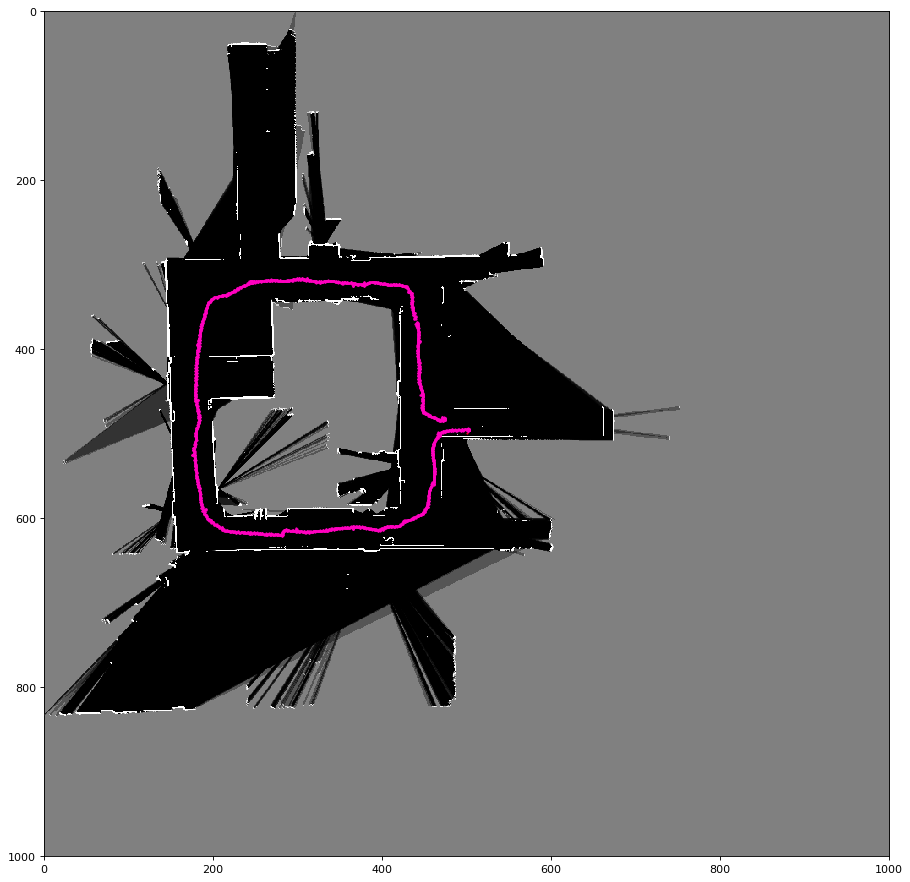

In [6]:
import pylab
indices = slam.coordinate_to_map_index(np.array(states))
plot_map(slam.map_prob, [indices[::5, 0], indices[::5, 1]], 20)

In [7]:
# fig = plt.figure(figsize=(8, 8))
# plt.imshow(np.transpose(slam.map_texture, (1, 0, 2)))
# plt.show()

In [8]:
# fig = plt.figure(figsize=(8, 8))
# plt.imshow(slam.map_texture_trimmed)
# plt.show()